### Packages needed

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split

#import pysal as ps
import scipy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

from torch.nn import functional
from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics

#!pip install dtaidistance
#!pip install plotly
#!pip install tslearn
#source https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
from patsy import dmatrices
#import statsmodels.api as sm

from datetime import datetime

from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
os.chdir(path)
import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

C:\Users\29700\anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [222]:
#!pip install Cython
#!pip install Cython --install-option="--no-cython-compile"
#%load_ext cython
#from setuptools import setup
#from Cython.Build import cythonize



### Functions

In [2]:
#read latlon id with home identified
def read_data(filepath, homepath):
    #read ids with home identified
    id_withhome = pd.read_csv(homepath, header=None, sep='\t')
    id_withhome.columns = ['newid','lat','lon']
    id_latlon = pd.read_csv(filepath, header=0, sep=',')
    #get ids
    homeids = list(np.unique(id_withhome.newid))
    id_latlon = id_latlon[id_latlon.newid.isin(homeids)]
    return(id_latlon)
    print(id_latlon.head(3))
    
def convert_to_shp(filepath, homepath):
    points = read_data(filepath, homepath)
    geo_points = gpd.GeoDataFrame(points,
                                 geometry=gpd.points_from_xy(points['lon'],\
                                                           points['lat']),\
                                crs={'init': 'epsg:4326'})
    return(geo_points)

#make sure the default crs for zone file is espg4326
def spatial_join(zone_path, points):
    Zone = gpd.read_file(zone_path)
    Zone.crs = points.crs
    points = gpd.tools.sjoin(points, Zone, how='left')
    return(points)

#conduct a small test to make sure the spatial join works
def small_sjoin_test(zonepath, data):
    test_dt = spatial_join(zonepath, data.iloc[:15])
    geoid = np.unique(test_dt['GEOID10'])
    if 'nan' in geoid:
        print('join not successfully')
        print(geoid)
    else:
        print(geoid)
    return(test_dt)
    
#plot zone and points to make sure they are in the same projection
def plot_point_zone(zone_path, points):
    zone = gpd.read_file(zone_path)
    base = zone.plot(color='white', edgecolor='grey')
    points.plot(ax=base, marker='o', color='red', markersize=5)
    

    
#convert_data
#get total locts
def get_total_locts(obs_data):
    locts = []
    for geoid in np.unique(obs_data['GEOID10']):
        for hr in np.unique(obs_data['hr']):
            for minut in np.unique(obs_data['minut_5']):
                a = str(geoid)+'_'+str(hr)+'_'+str(minut)
                locts.append(a)
    nb_locts = len(locts)
    return(locts, nb_locts)

#assign demographic information
#percentage calculation based on smartphone demographic variety
def get_sm_per(pop_ids, num_groups):
    num_group = num_groups
    sample_ids = pd.DataFrame()
    est_ratio = []
    sample_ids['GEOID10'] = pop_ids['GEOID10']
    sample_ids['sum'] = pop_ids['sum']
    
    np.random.seed(42)
    for i in range(num_group):
        sample_ids['g'+str(i+1)] = pop_ids['g'+str(i+1)]*(np.random.normal(est_sm['mean'][i], est_sm['se'][i],1)[0])*(np.random.normal(est_sm['mean'][18], est_sm['se'][18],1)[0])
        est_ratio.append(np.random.normal(est_sm['mean'][i], est_sm['se'][i],1)[0])
    est_ratio.append(np.random.normal(est_sm['mean'][18], est_sm['se'][18],1)[0])
        
    sample_ids['per_sum'] = sample_ids[['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
                'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']].sum(axis=1)
    for i in range(num_group):
        sample_ids['g'+str(i+1)] = sample_ids['g'+str(i+1)]/sample_ids['per_sum']
        sample_ids['g'+str(i+1)] = round(sample_ids['g'+str(i+1)]*sample_ids['sum'],1)
    return(sample_ids, est_ratio)

def get_pop_per(sample_ids, num_groups):
    for i in range(num_group):
        sample_ids['g'+str(i+1)] = sample_ids['g'+str(i+1)]/sample_ids['pop']
    for i in range(num_group):
        sample_ids['g'+str(i+1)] = round(sample_ids['g'+str(i+1)]*sample_ids['sum'],1)
    return(sample_ids)

def assign_demo(sample_ids, id_data, random_seed):
    random.seed(random_seed)
    demo_labels = []
    #convert sample ids into int
    sample_ids_dict = {}
    for i in ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
            'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']:
        sample_ids_dict[i] = []
    
    for i in range(len(sample_ids.index)):
        census_demo = sample_ids[['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
            'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']].iloc[i].to_frame()
        census_demo.columns = ['ori']
        census_demo['int'] = (census_demo['ori']).astype('int')
        census_demo['float'] = census_demo['ori']-census_demo['int']
        census_demo['group_num'] = round(census_demo['ori'],0)
        
        current_sum = census_demo['group_num'].sum()
        ct_sum = sample_ids['sum'][i]
        diff = int(current_sum-ct_sum)
        if diff < 0:
            #convert negative number to positive number
            diff = -diff
            index_num = census_demo[(census_demo['float']<=0.4)].sort_values(by=['float','int'], ascending=False).index[:diff]
            for j in index_num:
                census_demo.at[j,'group_num'] = census_demo.at[j,'group_num']+1
        elif diff > 0:
            #get list of data since -1 can cause negative number
            dt = census_demo[(census_demo['float']>=0.5)].sort_values(by=['float','int'])
            #assign an number to match the diff num
            test_num = 0
            for k in dt.index:
                if test_num < diff:
                    if  census_demo.at[k,'group_num']-1 >= 0:
                        census_demo.at[k,'group_num'] = census_demo.at[k,'group_num']-1
                        test_num = test_num+1
                    else:
                        pass
                else:
                    break
        else:
            pass
        
        if census_demo['group_num'].sum()-sample_ids['sum'][i] != 0:
            print('error!, check the code')
            print(i)
            print(census_demo)
            print(census_demo['group_num'].sum())
            print(sample_ids['sum'][i])
        
        else:
            for k in range(len(census_demo['group_num'])):
                sample_ids_dict[census_demo.index[k]].append(census_demo['group_num'][k])
                
            demo_label = []
            #print(i)
            #print(census_demo)
            for m in range(len(census_demo['group_num'])):
                demo_num = census_demo['group_num'].index[m]
                demo_label.extend(list(np.repeat(demo_num, census_demo['group_num'][m])))
            random.shuffle(demo_label)
            demo_labels.extend(demo_label)
            #convert demo label to number lebels
            num_demo_labels = []
            for labels in demo_labels:
                num_demo_labels.append(int(labels[1:]))
    id_data['demo_group'] = num_demo_labels
    
    return(id_data)


def get_demo_ratio(df, num_groups):
    num_group = num_groups
    
    demo_ratio = pd.DataFrame()
    demo_ratio['GEOID10'] = df['GEOID10']
    demo_ratio['pop'] = df['pop']
    for i in range(num_group):
        demo_ratio['g'+str(i+1)] = df['g'+str(i+1)]/df['pop']
    return(demo_ratio)

#percentage of different demo based on the smartphone pop
def get_smart_demo_ratio(df, est_ratio, num_groups):
    smart_ratio = pd.DataFrame()
    smart_ratio['GEOID10'] = df['GEOID10']
    for i in range(num_groups):
        smart_ratio['g'+str(i+1)] = df['g'+str(i+1)]*est_ratio[i]
    smart_ratio['sm_sum'] =  smart_ratio[['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
                'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']].sum(axis=1)
    for i in range(num_groups):
        smart_ratio['g'+str(i+1)] = smart_ratio['g'+str(i+1)]/smart_ratio['sm_sum']
    
    smart_ratio['ratio_sum'] =  smart_ratio[['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
                'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']].sum(axis=1)
    return(smart_ratio)

#calculate the statistical distance
def cal_stat_dist(demo_ratio, smart_ratio):
    stats_df = pd.DataFrame()
    stats_df['GEOID10'] = demo_ratio['GEOID10']
    ws_dist = []
    group_names = ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
                'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']
    for geoid in stats_df['GEOID10']:
        ws_dist.append(wasserstein_distance(demo_ratio[group_names][demo_ratio['GEOID10']==geoid].values[0]*smart_ratio['sm_sum'][smart_ratio['GEOID10']==geoid].values[0],\
                                         smart_ratio[group_names][smart_ratio['GEOID10']==geoid].values[0]*smart_ratio['sm_sum'][smart_ratio['GEOID10']==geoid].values[0]))

    stats_df['ws_dist'] = ws_dist
    return(stats_df)

#conduct mapping 
def get_map_loc(obs_data, locts):
    newid_map = {}
    locts_map = {}
    index_num1 = 0
    index_num2 = 0
    for i in np.unique(obs_data['newid']):
        newid_map[i] = index_num1
        index_num1 = index_num1+1
    for j in locts:
        locts_map[j] = index_num2
        index_num2 = index_num2+1
    return(newid_map, locts_map)

def assign_value2matrix(obs_data, newids_map, locts_map, matrices, obs_value):
    locts = list(obs_data['spatial_temporal_id'])
    newids = list(obs_data['newid'])
    #obs_num = list(obs_data['norm_obs'])
    obs_num = list(obs_data[obs_value])
    for i in range(len(locts)):
        #matrices[locts_map[locts[i]], newids_map[newids[i]]] = obs_num[i]
        matrices[locts_map[locts[i]], newids_map[newids[i]]] = obs_num[i]
        #print(locts_map[locts[i]], newids_map[newids[i]], obs_num[i])
    return(matrices)

#split_matric
def split_1(data, ratio, tensor=False):
    train = np.zeros((len(data), len(data[0]))).tolist()
    valid = np.zeros((len(data), len(data[0]))).tolist()

    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] > 0:
                if np.random.binomial(1, ratio, 1):
                    train[i][j] = data[i][j]
                else:
                    valid[i][j] = data[i][j]

    return [train, valid]

#add demo info
def split_2(data, ratio, tensor=False):
    train = np.zeros((len(data), len(data[0]))).tolist()
    valid = np.zeros((len(data), len(data[0]))).tolist()

    for i in range(len(data)):
        for j in range(len(data[i])):
            if j < 18:
                train[i][j] = data[i][j]
                valid[i][j] = data[i][j]
            else:    
                if data[i][j] > 0:
                    if np.random.binomial(1, ratio, 1):
                        train[i][j] = data[i][j]
                    else:
                        valid[i][j] = data[i][j]

    return [train, valid]

def split_demo(data, list_index=False):
    if list_index == False:
        data_wo_demo = np.zeros((data.shape[0],(data.shape[1]-18)))
        for i in range(data.shape[0]):
            data_wo_demo[i] = data[i][18:] 
    else:
        data_wo_demo = []
        for i in range(len(data)):
            data_wo_demo.append(data[i][18:])
    return(data_wo_demo)

def get_homeloc(selected_ids):
    ids_with_home = pd.read_csv('cuebiq_home_psrc_raw.csv', \
                                header=None, sep='\t')
    ids_with_home.columns = ['newid','lat','lon']
    #conver ids into shapefile
    ids_with_home = ids_with_home[ids_with_home['GEOID10'].isin(selected_idsds)]
    ids_with_home =  gpd.GeoDataFrame(ids_with_home,\
                                      geometry=gpd.points_from_xy(ids_with_home['lon'],\
                                                                  ids_with_home['lat']),\
                                      crs={'init': 'epsg:4326'})
    ids_with_home = gpd.tools.sjoin(ids_with_home, CensusTract, how='left')
    ids_with_home = ids_with_home[['newid','lat', 'lon','GEOID10']]
    return(ids_with_home)

def c2num(x):
    return(int(x[1:]))

#check data popularity
def check_data_popularity(Seattle_df, col4obs_rates):
    len(np.unique(Seattle_df['newid']))
    #get value for each loc,t
    loc_time_popularity = Seattle_df.groupby('spatial_temporal_id')[col4obs_rates].sum().sort_values(ascending=False).reset_index()
    print('top 10 pop loc+time')
    print(loc_time_popularity.head(10))

    plt1 = plt.figure(1)
    plt.plot(loc_time_popularity[col4obs_rates].values)
    plt.title('obs_popularity_frequency')

    #check data in Seattle area
    census_t = []
    hours = []
    for i in loc_time_popularity['spatial_temporal_id'].values:
        cs_time = i.split('_')
        if cs_time[0] not in census_t:
            census_t.append(cs_time[0])
        if cs_time[1] not in hours:
            hours.append(cs_time[1])
    print('popular ct: ', census_t)
    print('popular hr: ', hours)

    #observation popularity
    Seattle_map = CensusTract[CensusTract['GEOID10'].isin(census_t)]
    a = list(Seattle_map['GEOID10'].values)
    vals = []
    ranks_val = []
    num_cts = len(census_t)
    val = num_cts
    for i in range(num_cts):
        vals.append(val)
        val -= 1

    for i in range(num_cts):
        idx = census_t.index(a[i])
        ranks_val.append(vals[idx])
    Seattle_map['pop_rank'] = ranks_val
    
    plttest = plt.figure(3)
    fig, ax = plt.subplots(1, 1)
    Seattle_map.plot(column='pop_rank', ax=ax, legend=True, cmap='OrRd')

    #temporal popularity
    plt2 = plt.figure(2)
    a = 0
    for i in hours:
        hours[a] = int(i)
        a = a+1
    rank_x = list(range(0,24))
    
    plt.scatter(rank_x,hours)
    plt.xlim(-1, 24)
    plt.ylim(-1, 24)
    plt.xlabel('Rank')
    plt.ylabel('Hour')
    plt.grid(True)
    plt.title('Popular rank by hour')
    

In [ ]:
with open('user_tsinfo.txt', 'w') as f:
    lines = ''
    for i in locts_map.keys():
        lines = lines+i+','
    lines = lines+'\n'
    f.write(lines)
    lines = ''
    for i in user_ids:
        lines = lines+str(i)+','
    f.write(lines)
    f.close()

### data processing and popularity check

In [29]:
#read land use data
input_path = 'G:/My Drive/2021/Bias/census_block_data/'
Seattle_01obs = pd.read_csv(input_path+'obs01_landuse.csv', header=None).to_numpy()
Seattle_obs = pd.read_csv(input_path+'obs_landuse.csv', header=None).to_numpy()

C:\Users\29700\anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\29700\AppData\Local\Temp\ipykernel_7488\2789691492.py:55: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  ids_with_home = gpd.tools.sjoin(ids_with_home, CensusTract, how='left')


# of census tracts: 12
# of census newids: 7767
top 10 pop loc+time
  spatial_temporal_id  norm_obs_5
0   53033008100_16_10   25.792683
1   53033008100_17_20   25.182927
2   53033008100_16_15   24.573171
3   53033008100_17_10   24.390244
4   53033008100_16_20   24.268293
5    53033008100_17_0   24.268293
6   53033008100_16_30   24.207317
7    53033008100_17_5   24.024390
8   53033008100_16_35   23.963415
9   53033008100_16_45   23.597561
popular ct:  ['53033008100', '53033007300', '53033007200', '53033008300', '53033008200', '53033008500', '53033007100', '53033008400', '53033008001', '53033007401', '53033008002', '53033007402']
popular hr:  ['16', '17', '12', '15', '18', '11', '9', '14', '13', '8', '10', '19', '7', '22', '20', '6', '21', '5', '4', '23', '0', '1', '3', '2']


C:\Users\29700\anaconda3\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


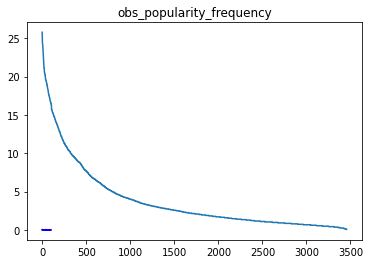

<Figure size 432x288 with 0 Axes>

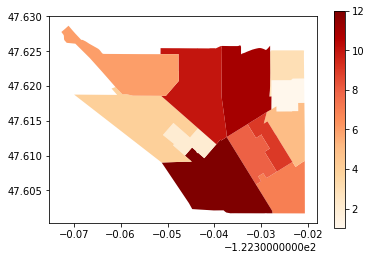

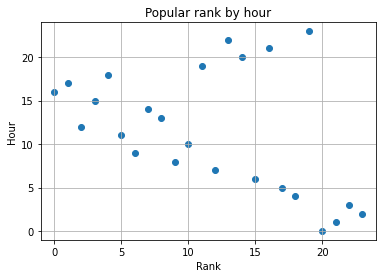

In [30]:
path = 'G:/My Drive/2020/Bias/data-processing/'
os.chdir(path)

latlon_shape = pd.read_csv('latlon_shape.csv')

#get test data
obs_Seattle = pd.read_csv('obs_Seattle.csv', index_col=0)
Seattle_ids = list(np.unique(obs_Seattle['GEOID10']))
#convert_to_string
a = 0 
for ids in Seattle_ids:
    Seattle_ids[a] = str(ids)
    a += 1
latlon_Seattle = latlon_shape[latlon_shape['GEOID10'].isin(Seattle_ids)]
latlon_Seattle = latlon_Seattle.reset_index()
latlon_Seattle.to_csv('latlon_Seattle.csv', index=False)


Seattle_ct = pd.read_csv('Seattle_ct.csv')
latlon_Seattle = pd.read_csv('latlon_Seattle.csv')

newids = list(np.unique(latlon_Seattle['newid']))

test_latlon = latlon_Seattle[latlon_Seattle['newid'].isin(newids[:10])]
#test_latlon.to_csv('test_latlon.csv', index=False)

locts, nb_locts = get_total_locts(obs_Seattle)
nb_ids = len(np.unique(obs_Seattle['newid']))
#obs_Seattle.head(3)


#through checking we found that the demographic data is based on ACS 2017 survey
#thus it matches the data collected from cuebiq
demo_ct = pd.read_csv('data_stage1_v1.csv', header=0)
demo_ct.head()
est_sm =pd.read_csv('../model/poi_res_v32.csv', header=0)

est_sm.columns = ['prob','mean','se','sd','10%','90%','n_eff','Rhat']
demo_ct = demo_ct[['pop', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7',\
       'g8', 'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17',\
       'g18','home_ratio','GEOID10','Count_']]

CensusTract = gpd.read_file('spatial_check/ct2010.shp')
demo_reg_df = pd.read_csv('demo_reg_df.csv')

#obs_Seattle_Bellevue.head(3)
ids_with_home = pd.read_csv('cuebiq_home_psrc_raw.csv', \
                                header=None, sep='\t')
ids_with_home.columns = ['newid','lat','lon']
#conver ids into shapefile
ids_with_home =  gpd.GeoDataFrame(ids_with_home,\
                                  geometry=gpd.points_from_xy(ids_with_home['lon'],\
                                                              ids_with_home['lat']),\
                                  crs={'init': 'epsg:4326'})
ids_with_home = gpd.tools.sjoin(ids_with_home, CensusTract, how='left')
ids_with_home = ids_with_home[['newid','lat', 'lon','GEOID10']]


#current_ids['demo_group'] = current_ids['demo_group'].apply(c2num)
#ids = np.unique(obs_Seattle_Bellevue['newid'])
#ids_with_home_bs = get_homeloc(ids)

#get the sample ratio
#per = group_pop/pop*.81*est_per
#resclae it so that sum_per=1
pop_ids = ids_with_home.groupby(['GEOID10']).size().to_frame()
pop_ids.reset_index(inplace=True)
pop_ids.columns = ['GEOID10','sum']

demo_geo = demo_ct[demo_ct['GEOID10'].isin(pop_ids['GEOID10'])]
demo_geo['GEOID10'] = demo_geo['GEOID10'].astype(str)
pop_ids = pop_ids.merge(demo_geo, on=["GEOID10", "GEOID10"])
pop_ids = pop_ids.sort_values(['GEOID10'])


sample_ids, est_ratio = get_sm_per(pop_ids, 18)
ids_with_home = assign_demo(sample_ids, ids_with_home, 42)


sample_ids, est_ratios = get_sm_per(pop_ids, 18)

demo_ratio_Seattle = get_demo_ratio(pop_ids[pop_ids['GEOID10'].isin(np.unique(obs_Seattle['GEOID10']))], 18)
smart_ratio_Seattle = get_smart_demo_ratio(pop_ids[pop_ids['GEOID10'].isin(np.unique(obs_Seattle['GEOID10']))], \
                                           est_ratios, 18)
ws_dist_test = cal_stat_dist(demo_ratio_Seattle, smart_ratio_Seattle)

newids_map, locts_map = get_map_loc(obs_Seattle, locts) 


test_matrice = np.zeros((nb_locts, nb_ids))
test_matrice_scaled = np.zeros((nb_locts, nb_ids))
test_matrice_scaled = assign_value2matrix(obs_Seattle, \
                    newids_map, locts_map, test_matrice_scaled, 'norm_obs_5')
test_matrice = assign_value2matrix(obs_Seattle, \
                    newids_map, locts_map, test_matrice, 'obs')

print('# of census tracts:', len(np.unique(obs_Seattle['GEOID10'])))
print('# of census newids:', len(np.unique(obs_Seattle['newid'])))

#obs_Seattle.head(3)
user_ids = np.unique(obs_Seattle['newid'])

#row: time_loc, column: ids

#row: ids, column: time_loc: Users * items
test_matrice_reverse = test_matrice.T
test_matrice_scaled_reverse = test_matrice_scaled.T

sparse_checkper_ids = []
obs_values_check = []
for i in test_matrice_reverse:
    #num ids at each ct,t
    sparse_checkper_ids.append(np.count_nonzero(i)/len(i))
    #num obs
    obs_values_check.append(np.sum(i)/len(i))
    
#summary of the number of ids
#pd.DataFrame(sparse_checkper_ids).describe()
#summary of observations
#pd.DataFrame(obs_values_check).describe()

plt.plot(sparse_checkper_ids[:100], color='red')
plt.plot(obs_values_check[:100], color='blue')
plt.title('obs vs. num ids')

#trnaslate group infomation
#user info
current_ids = ids_with_home[ids_with_home['newid'].isin(np.unique(obs_Seattle['newid']))]
#convert demo_group to number

current_ids = current_ids.set_index(current_ids['newid'])

demo_matrix = np.zeros((nb_ids, 18))
user_ids = list(newids_map.keys())
for k in range(len(newids_map.keys())):
    ids_index = user_ids[k]
    demo_matrix[k, current_ids.loc[ids_index]['demo_group']-1] = 1

test_matrice_scaled_reverse_demo = np.hstack([test_matrice_scaled_reverse, demo_matrix])

current_ids = current_ids.set_index(current_ids['newid'])

demo_matrix = np.zeros((nb_ids, 18))
user_ids = list(newids_map.keys())
for k in range(len(newids_map.keys())):
    ids_index = user_ids[k]
    demo_matrix[k, current_ids.loc[ids_index]['demo_group']-1] = 1

test_matrice_scaled_reverse_demo = np.hstack([test_matrice_scaled_reverse, demo_matrix])


#add user index id
user_ids_index = np.array(list(newids_map.keys()))
user_ids_index = user_ids_index.reshape(user_ids_index.shape[0],1)

test_matrice_scaled_reverse = np.hstack([user_ids_index,test_matrice_scaled_reverse])
#data not scaled
test_matrice_reverse = np.hstack([user_ids_index,test_matrice_reverse])


train_scaled, test_scaled = train_test_split(test_matrice_scaled_reverse, \
                                   test_size=0.2, random_state=42)

#method 2, not using the train, user, splitting method
#train_demo, test_demo = train_test_split(test_matrice_scaled_reverse_demo, test_size=0.2, random_state=42)
#train1, valid1 = train_test_split(train1, test_size=0.2, random_state=42)
#train_user_loct = split(train_user_loct, 0.8)


train, test = train_test_split(test_matrice_reverse, test_size=0.2,\
                              random_state=42)

Seattle_df = pd.read_csv('Seattle_obs_1.csv')
Seattle_df.head(3)


check_data_popularity(Seattle_df, 'norm_obs_5')



In [ ]:
Seattle_01obs

### collaborative filtering 

One important thing to keep in mind is that in an approach based purely on collaborative filtering, the similarity is not calculated using factors like the age of users, genre of the movie, or any other data about users or items. It is calculated only on the basis of the rating (explicit or implicit) a user gives to an item. For example, two users can be considered similar if they give the same ratings to ten movies despite there being a big difference in their age.

Source: https://realpython.com/build-recommendation-engine-collaborative-filtering/

In [31]:
np.unique(obs_Seattle['GEOID10'])

array([53033007100, 53033007200, 53033007300, 53033007401, 53033007402,
       53033008001, 53033008002, 53033008100, 53033008200, 53033008300,
       53033008400, 53033008500], dtype=int64)

In [4]:
#example of NMF
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

#### functions for CF method

In [3]:
def CF(test_dt, num_of_latent_factors, scaled):
    #use matrice without the id index
    test_sparse_matrix = csr_matrix(test_dt[:, 1:])
    #The number of factors to factor the user-item matrix.
    #Performs matrix factorization of the original user item matrix
    U, sigma, Vt = svds(test_sparse_matrix, k = num_of_latent_factors)
    sigma = np.diag(sigma)
    predicted = np.dot(np.dot(U, sigma), Vt)
    if scaled==True:
        predicted_norm = ((predicted - predicted.min())/(predicted.max()-predicted.min()))*5
        return(predicted_norm)
    else:
        return(predicted)
    
def cal_rmse(test_dt, pred_dt, single_id = False, withids=True):
    if single_id == True:
        if withids == False:
            return(mean_squared_error(test_dt, pred_dt, squared=False))
        else:
            return(mean_squared_error(test_dt[1:], pred_dt, squared=False))
    elif withids == False:
        return(mean_squared_error(test_dt, pred_dt, squared=False))
    else:
        return(mean_squared_error(test_dt[:, 1:], pred_dt, squared=False))
    
def cal_mae(test_dt, pred_dt, withids=False, single_id = False):
    if single_id == True:
        if withids == False:
            return(mae(test_dt, pred_dt))
        else:
            return(mae(test_dt[1:], pred_dt))
    elif withids == False:
        return(mae(test_dt, pred_dt))
    else:
        return(mae(test_dt[:, 1:], pred_dt))

def cal_r2(test_dt, pred_dt, single_id = False):
    if single_id == True:
        return(r2_score(test_dt[1:], pred_dt))
    else:
        return(r2_score(test_dt[:, 1:], pred_dt))
    

def get_best_svd(test_matrix, scaled=True):
    rmse_result = []
    #test_lf=test latent factors
    test_lf = list(range(2, 101))
    best_lf_rmse = 0
    test_rmse = 1
    best_pred_dt_rmse = 0
    rmse_dict = {}
    for num_lf in test_lf:
        pred_dt = CF(test_matrix, num_lf, scaled)
        rmse = cal_rmse(test_matrix, pred_dt)
        rmse_dict[num_lf] = rmse
        if rmse < test_rmse:
            test_rmse = rmse
            best_lf_rmse = num_lf
            best_pred_dt_rmse = pred_dt
            
    #rmse_result.append(rmse)
    print('based on rmse', test_rmse, best_lf_rmse)
    return(best_pred_dt_rmse, best_lf_rmse, rmse_dict)

def NMF_est(test_matrix, num_lf, reg_l, a):
    #use nndsvd for sparseness
    model = NMF(n_components=num_lf, init='nndsvd', max_iter=1000, l1_ratio=reg_l, alpha=a)
    W = model.fit_transform(test_matrix[:, 1:])
    H = model.components_
    return(np.matmul(W, H))      

#example of NMF
def NMF_est_with_zeros(test_matrix, num_lf, reg_l, a, Zero_index):
    #start = time.time()
    model = NMF(n_components=num_lf, init='nndsvd', max_iter=5000, l1_ratio=reg_l, alpha=a)
    W = model.fit_transform(test_matrix[:, 1:])
    H = model.components_
    WH = np.dot(W, H)
    Zero_est = np.multiply(WH, Zero_index)
    Zeros = np.zeros(WH.shape) 
    Zeros_diff = Zero_est - Zeros
    zero_val = np.linalg.norm(Zeros_diff)
    return(WH, zero_val)
    
def get_best_NMF(test_matrix):
    #test
    test_lf = list(range(2, 19))
    l1 = np.round(0.05*np.array(list(range(20))),2)
    alpha_para = np.round(0.05*np.array(list(range(20))),2)
    best_lf_rmse = 0
    best_lf_mae = 0
    test_rmse = 1
    test_mae = 1
    
    best_pred_dt_rmse = 0
    best_pred_dt_mae = 0
    best_regl_rmse = 0
    best_regl_mae = 0
    
    best_alpha_rmse = 0
    best_alpha_mae = 0
    rmse_dict = {}
    mae_dict = {}
    for num_lf in test_lf:
        for reg_l in l1:
            for a in alpha_para:
                pred_dt = NMF_est(test_matrix, num_lf, reg_l, a)
                rmse = cal_rmse(test_matrix, pred_dt)
                rmse_dict['k='+str(num_lf)+', lambda='+str(reg_l)+', alpha='+str(a)] = round(rmse,9)
                mae_ = cal_mae(test_matrix, pred_dt)
                mae_dict['k='+str(num_lf)+', lambda='+str(reg_l)+', alpha='+str(a)] = round(mae_,9)
                if rmse < test_rmse:
                    test_rmse = rmse
                    best_lf_rmse = num_lf
                    best_pred_dt_rmse = pred_dt
                    best_regl_rmse = reg_l
                    best_alpha_rmse = a
                if mae_ < test_mae:
                    test_mae = mae_
                    best_lf_mae = num_lf
                    best_regl_mae = reg_l
                    best_pred_dt_mae = pred_dt  
                    best_alpha_mae = a
            
        #rmse_result.append(rmse)
    print('based on rmse: '+'best val='+str(round(test_rmse,9))+', best k='+str(best_lf_rmse)+', best lambda='+str(best_regl_rmse)+', best alpha='+str(best_alpha_rmse))
    print('based on mae: '+'best val='+str(round(test_mae,9))+', best k='+str(best_lf_mae)+', best lambda='+str(best_regl_mae)+', best alpha='+str(best_alpha_mae))
    return(best_pred_dt_rmse, best_pred_dt_mae, rmse_dict, mae_dict)

def get_best_NMFwzero(test_matrix, Zero_index):
    #test
    test_lf = list(range(2, 19))
    l1 = np.round(0.1*np.array(list(range(10))),2)
    alpha_para = np.round(0.1*np.array(list(range(10))),2)
    zero_w = [0.1, 0.3, 0.5]
    #best_lf_rmse = 0
    #test_rmse = 100
    #best_pred_dt_rmse = 0
    #best_regl_rmse = 0
    #best_alpha_rmse = 0
    rmse_dict = {}
    zero_score = {}
    rmse_w0 = {}
    
    #best_lf_mae = 0
    #test_mae = 100
    #best_pred_dt_mae = 0
    #best_regl_mae = 0
    #best_alpha_mae = 0
    mae_dict = {}
    mae_w0 = {}
    
    for num_lf in test_lf:
        for reg_l in l1:
            for a in alpha_para:
                dict_keys = 'k='+str(num_lf)+', lambda='+str(reg_l)+', alpha='+str(a)
                start = time.time()
                pred_dt, zero_constriant = NMF_est_with_zeros(test_matrix, num_lf, reg_l, a, Zero_index)
                end = time.time()
                print(dict_keys)
                print(f'running time={end-start}')

                rmse_dict[dict_keys]= round(cal_rmse(test_matrix, pred_dt),9)
                mae_dict[dict_keys] = round(cal_mae(test_matrix, pred_dt),9)
                for w0 in zero_w:
                    dict_keys_0 = dict_keys+', w0='+str(w0)
                    zero_score[dict_keys_0] = w0*zero_constriant
                    rmse_w0[dict_keys_0] = rmse_dict[dict_keys]+zero_score[dict_keys_0]
                    mae_w0[dict_keys_0] = mae_dict[dict_keys]+zero_score[dict_keys_0]
    #            if rmse < test_rmse:
    #                test_rmse = rmse
    #                best_lf_rmse = num_lf
    #                best_pred_dt_rmse = pred_dt
    #                best_regl_rmse = reg_l
    #                best_alpha_rmse = a
    #            if mae < test_mae:
    #                test_mae = mae
    #                best_lf_mae = num_lf
    #                best_regl_mae = reg_l
    #                best_pred_dt_mae = pred_dt
    #                best_alpha_mae = a
            
        #rmse_result.append(rmse)
    #print('based on rmse: '+'best val='+str(round(test_rmse,9))+', best k='+str(best_lf_rmse)+', best lambda='+str(best_regl_rmse)+', best alpha='+str(best_alpha_rmse))
    #print('based on mae: '+'best val='+str(round(test_mae,9))+', best k='+str(best_lf_mae)+', best lambda='+str(best_regl_mae)+', best alpha='+str(best_alpha_mae))
    return(rmse_dict, zero_score, mae_dict, rmse_w0, mae_w0)


#post data processing
#Functions
#for the ods at the same location
#the other location at the same time should be 0
#time_diff <= 10 min

#for the ods at different location
#the other location which not belongs to the route or neatby od should be 0
#time_diff <= 20 min

#get 0 value

#besides,if appears in one place already, the location will not appear in the other census tract
def extract_od(dt, sameod = True):
    if sameod == True:
        test_dt = dt[(dt['od_euqal']==1) & (dt['time_diff']<=10)]
    else:
        test_dt = dt[(dt['od_euqal']==0) & (dt['time_diff']<=20)]
    return(test_dt)

def convert2stid(hr, minut_5, census):
    return(str(census)+'_'+str(hr)+'_'+str(minut_5))

def process_dt4convert(shr, ehr, smin, emin):
    if ehr-shr<0:
        print('data error')
        return(None)
    if ehr-shr == 0:
        if emin-smin == 0:
            return([shr], [smin])
        elif emin-smin <0:
            print('data error')
            return(None)
        else:
            interval = int((emin-smin)/5)
            min_lst = [smin]
            hr_lst = [shr]
            if interval > 1:
                for i in range(interval):
                    min_lst.append(int(smin+5*(i+1)))
                    hr_lst.append(shr)
            else:
                min_lst.append(emin)
                hr_lst.append(shr)
            return(hr_lst, min_lst)
    else:
        if emin+60-smin == 0:
            return([shr], [smin]) 
        else:
            interval = int((emin+60-smin)/5)    
            hr_lst = [shr]
            min_lst = [smin]
            if interval > 1:
                for i in range(interval):
                    if smin+(i+1)*5 >= 60:
                        min_lst.append(smin+(i+1)*5-60)
                        hr_lst.append(ehr)
                    else:
                        min_lst.append(smin+(i+1)*5)
                        hr_lst.append(shr)
            else:             
                min_lst.append(emin)
                hr_lst.append(ehr)
            return(hr_lst, min_lst) 
        
def add_zero_loc(shr, ehr, s5min, e5min, nocrossedcts, zero_loclst):
    for i in range(len(shr)):
        hr, minut = process_dt4convert(shr[i], ehr[i], s5min[i], e5min[i])
        for j in nocrossedcts[i]:
            for k in range(len(hr)):
                loc_timeids = convert2stid(hr[k], minut[k], j)
                if loc_timeids not in zero_loclst:
                    zero_loclst.append(loc_timeids)
    return(zero_loclst)

def get_nocrossed_stids(dt, zero_loc_time):
    dt = dt.sort_values(by=['newid'])
    newids = np.unique(dt['newid'])
    
    for ids in newids:
        if ids not in zero_loc_time:
            zero_loc_time[ids] = []
        #get start and end hr
        s_hr = list(dt['s_hr'][dt['newid']==ids].values)
        e_hr = list(dt['e_hr'][dt['newid']==ids].values)
        s_5min = list(dt['s_minut_5'][dt['newid']==ids].values)
        e_5min = list(dt['e_minut_5'][dt['newid']==ids].values)
        no_crossed_cts = list(dt['no_crossedcts'][dt['newid']==ids].values)
        
        zero_loc_time[ids] = add_zero_loc(s_hr, e_hr, s_5min, e_5min, no_crossed_cts, zero_loc_time[ids])
    return(zero_loc_time)

def getzero_info(dt):
    zero_loc_time = {}
    dt1 = extract_od(dt, sameod = True)
    dt2 = extract_od(dt, sameod = False)
    zero_loc_time = get_nocrossed_stids(dt1, zero_loc_time)
    zero_loc_time = get_nocrossed_stids(dt2, zero_loc_time)
    return(zero_loc_time)

def get_revised_matrix(pred_matrix, zero_loc_time):
    for ids in zero_loc_time:
        for loct_time in zero_loc_time[ids]:
            pred_matrix[newids_map[ids]][locts_map[loct_time]] = 0
    return(pred_matrix)

def convert_missingids(time_lst, ids, time_spatial_ids):
    for t in time_lst:
        hr = (Seattle_latlon['hr'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        minut = (Seattle_latlon['minut_5'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        geoid = (Seattle_latlon['geoid'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        newgeo = (Seattle_latlon['new_geos'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        geos = list(np.unique([geoid, newgeo]))
        if 0 in geos:
            geos.remove(0)
        #get no observed census_t
        diff_ct = list(set(census_t) ^ set(geos))
        for geoid in diff_ct:
            time_spatial_id = convert2stid(hr, minut, geoid)
            if time_spatial_id not in time_spatial_ids:
                time_spatial_ids.append(time_spatial_id)
    return(time_spatial_ids)

In [33]:
#convert data with estimated shortest path info
file_path = 'G:/My Drive/2021/Bias/census_tract_process/crossed_routes.csv'
crossed_rt = pd.read_csv(file_path)

get_hr = lambda x: datetime.fromtimestamp(x).hour
get_minute = lambda x: datetime.fromtimestamp(x).minute
crossed_rt['s_hr'] = crossed_rt['start_time'].apply(get_hr).values
crossed_rt['e_hr'] = crossed_rt['end_time'].apply(get_hr).values
crossed_rt['s_min'] = crossed_rt['start_time'].apply(get_minute).values
crossed_rt['e_min'] = crossed_rt['end_time'].apply(get_minute).values

to5min = lambda x: int(x/5)*5
crossed_rt['s_minut_5'] = crossed_rt['s_min'].apply(to5min)
crossed_rt['e_minut_5'] = crossed_rt['e_min'].apply(to5min)

get_timeloct_id = lambda x: str(x)+'_'
remove_last_symbol = lambda x: x[:-1]
crossed_rt['ori_st'] = (crossed_rt['new_ori'].apply(get_timeloct_id)+\
crossed_rt['s_hr'].apply(get_timeloct_id)+\
crossed_rt['s_minut_5'].apply(get_timeloct_id)).apply(remove_last_symbol)

crossed_rt['dest_st'] = (crossed_rt['new_dest'].apply(get_timeloct_id)+\
crossed_rt['e_hr'].apply(get_timeloct_id)+\
crossed_rt['e_minut_5'].apply(get_timeloct_id)).apply(remove_last_symbol)

crossed_rt = crossed_rt[crossed_rt.columns[5:]]
crossed_rt.columns


### sparse svd
#predsvd_rmse_s, lfsvd_rmse_s, rmse_svd_s = get_best_svd(test_matrice_scaled_reverse, False)
#predsvd_rmse, lfsvd_rmse, rmse_svd = get_best_svd(test_matrice_reverse, False)

#nmf_rmse_dict, nmf_zero_score, nmf_mae_dict, nmf_rmse_w0, nmf_mae_w0 = get_best_NMFwzero(test_matrice_reverse, Zero_index)

Index(['newid', 'ori_geo', 'dest_geo', 'start_time', 'end_time', 'time_diff',
       'od_euqal', 'new_ori', 'new_dest', 'crossed_ct', 'ct_check',
       'no_crossed_ct', 'travel_time', 's_hr', 'e_hr', 's_min', 'e_min',
       's_minut_5', 'e_minut_5', 'ori_st', 'dest_st'],
      dtype='object')

#### post data processing

In [45]:
#latlon_path = 'G:/My Drive/2021/Bias/data-processing/'
Seattle_latlon = pd.read_csv('Seattle_latlon.csv', index_col=0)

,index,newid,ori_geo,dest_geo,start_time,end_time,time_diff,od_euqal,new_ori,new_dest,...,travel_time,s_hr,e_hr,s_min,e_min,s_minut_5,e_minut_5,ori_st,dest_st,no_crossedcts
0,0,32,53033008100,53033008100,1491399907,1491400869,16.0,False,53033008100,53033007200,...,6,6,7,45,1,45,0,53033008100_6_45,53033007200_7_0,"[53033008001, 53033008002, 53033007300, 530330..."
1,1,32,53033008100,53033008100,1491402457,1491402870,6.0,False,53033007200,53033007300,...,1,7,7,27,34,25,30,53033007200_7_25,53033007300_7_30,"[53033008001, 53033008002, 53033008200, 530330..."
2,2,32,53033008100,53033008100,1491403589,1491403987,6.0,False,53033007300,53033007200,...,3,7,7,46,53,45,50,53033007300_7_45,53033007200_7_50,"[53033008001, 53033008002, 53033007401, 530330..."


# of ids with shortest path:  5955
# of identified ids:  7767
# of missing ids without shortest path:  1812
worst data accuracy:  200


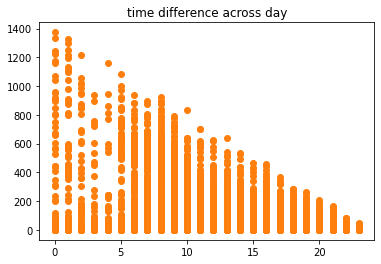

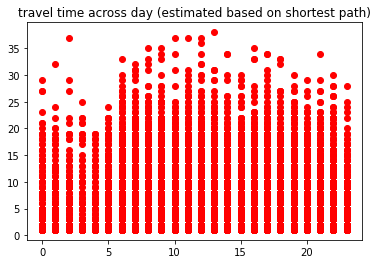

In [34]:
#get neighborhood census tract info
os.chdir('G:/My Drive/2021/Bias/census_tract_process')
pathfile = 'G:/My Drive/2021/Bias/census_tract_process/'
Seattle_ct = pd.read_csv(pathfile+'Seattle_ct.csv')
Seattle_ct.columns
Seattle_ct = Seattle_ct[['GEOID10','Nb_interse', 'nb_count', 'nb_touch', 'nb_bf_5', 'nb_bf10', \
                         'nb_bf100','nb_bf1mi','Area', 'Distance m','Distance_1', 'field_1', 'index']]

#check time difference change for each individual
newids = list(newids_map.keys())
a = 0
index = 0
for ids in newids:
    if a <= index:
        test_dt = crossed_rt[['time_diff', 'travel_time','s_hr','e_hr','od_euqal']][crossed_rt['newid'] == ids]
        test_dt = test_dt.sort_values(by=['time_diff'])
        plt.figure(a)
        x = list(test_dt['s_hr'].values)
        y = list(test_dt['time_diff'].values)
        plt.plot(x,y,'o')
        plt.title('time difference between each time segement for ids = '+str(ids))
        a += 1
        
test_dt = crossed_rt[['s_hr', 'time_diff', 'travel_time']][crossed_rt['od_euqal']==0].sort_values(by=['s_hr', 'time_diff'])
plt.figure(0)
plt.plot(list(test_dt['s_hr'].values), list(test_dt['time_diff'].values),'o')
plt.title('time difference across day')
plt.figure(1)
plt.plot(list(test_dt['s_hr'].values), list(test_dt['travel_time'].values),'ro')
plt.title('travel time across day (estimated based on shortest path)')

#keep previous census tract
ori_geo = crossed_rt['ori_geo'].values
dest_geo = crossed_rt['dest_geo'].values
no_crossed_ct = crossed_rt['no_crossed_ct'].values
no_crossed_cts = []
for i in range(len(ori_geo)):
    no_crossed = no_crossed_ct[i].strip('[]').split(', ')
    if str(ori_geo[i]) in no_crossed:
        no_crossed.remove(str(ori_geo[i]))
    if str(dest_geo[i]) in no_crossed:
        no_crossed.remove(str(dest_geo[i]))
    no_crossed_cts.append(no_crossed)

del(ori_geo)
del(dest_geo)
del(no_crossed_ct)

crossed_rt['no_crossedcts'] = no_crossed_cts
crossed_rt = crossed_rt.sort_values(by=['newid','time_diff','s_hr'])


#we found missing valeues after we processing the data
#latlon_path = 'G:/My Drive/2021/Bias/data-processing/'
Seattle_latlon = pd.read_csv('Seattle_latlon.csv', index_col=0)

selected_colname = list(Seattle_latlon.columns)
selected_colname.remove('Unnamed: 0.1')
Seattle_latlon = Seattle_latlon[selected_colname]
Seattle_latlon['minut_5'] = (Seattle_latlon['minut'].apply(to5min)).values
#through the checking, it is found there are individuals missing after the shortest path algorithm
ids_in_dt = list(np.unique(crossed_rt['newid']))
diff = set(newids)^set(ids_in_dt)

print('# of ids with shortest path: ', len(ids_in_dt))
print('# of identified ids: ', len(newids_map.keys()))
print('# of missing ids without shortest path: ', len(diff))

#check the missed data in detail

crossed_rt = crossed_rt.sort_values(by=['newid','start_time'])
crossed_rt.reset_index(inplace=True)
crossed_rt.head(3)

newids = np.unique(crossed_rt['newid'])
kept_data_start = {}
kept_data_end = {}
for ids in newids:
    kept_data_start[ids] = list(crossed_rt['start_time'][crossed_rt['newid']==ids].values)
    kept_data_end[ids] = list(crossed_rt['end_time'][crossed_rt['newid']==ids].values)
    
#get missing trips
#missing ids with missing data
newids = np.unique(crossed_rt['newid'])
newids_all = list(newids_map.keys())
missing_ids = {}
for ids in newids_all:
    missing_ids[ids] = []
    time_data = list(Seattle_latlon['timestamp'][Seattle_latlon['newid']==ids].values)
    if ids not in newids:
        missing_ids[ids] = time_data
    else:    
        for time in time_data:
            if time not in kept_data_end[ids] and time not in kept_data_start[ids]:
                missing_ids[ids].append(time)
                
missing_pairs = {}
for ids in newids:
    missing_pairs[ids] = {'o':[],'d':[]}
    cur_odpairs = crossed_rt[['start_time', 'end_time']][crossed_rt['newid']==ids].values
    time_data = list(Seattle_latlon['timestamp'][Seattle_latlon['newid']==ids].values)
    for i in range(len(time_data)):
        if i < len(time_data)-1:
            od_pairs = []
            od_pairs.append(time_data[i]) 
            od_pairs.append(time_data[i+1])
            if od_pairs not in cur_odpairs:
                missing_pairs[ids]['o'].append(od_pairs[0])
                missing_pairs[ids]['d'].append(od_pairs[1]) 
                
                
print('worst data accuracy: ', np.max(Seattle_latlon['accuracy']))

census_t = list(np.unique(Seattle_latlon['GEOID10']))

zero_loc_time = {}
for ids in missing_ids:
    if ids not in zero_loc_time:
        zero_loc_time[ids] = []
    zero_loc_time[ids] = convert_missingids(missing_ids[ids], ids, zero_loc_time[ids])
    
# create the zero index matrix
Zero_index = np.zeros(test_matrice_reverse[:, 1:].shape)
for row in zero_loc_time:
    for col in zero_loc_time[row]:
        Zero_index[newids_map[row]][locts_map[col]] = 1

In [4]:
import numbers
import scipy.sparse as sp
import warnings
from math import sqrt
import time

from sklearn.decomposition._cdnmf_fast import _update_cdnmf_fast #not able to be revised, visual studio version not matched
from sklearn._config import config_context
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import randomized_svd, safe_sparse_dot, squared_norm
from sklearn.utils.validation import check_is_fitted, check_non_negative
#code reference https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09bcc2eaeba98f7e737aac2ac782f0e5f1/sklearn/decomposition/_nmf.py

In [5]:
EPSILON = np.finfo(np.float32).eps

def norm(x):
    return sqrt(squared_norm(x))


def trace_dot(X, Y):
    return np.dot(X.ravel(), Y.ravel())


def _check_init(A, shape, whom):
    A = check_array(A)
    if np.shape(A) != shape:
        raise ValueError(
            "Array with wrong shape passed to %s. Expected %s, but got %s "
            % (whom, shape, np.shape(A))
        )
    check_non_negative(A, whom)
    if np.max(A) == 0:
        raise ValueError("Array passed to %s is full of zeros." % whom)
        
def _beta_divergence(X, W, H, beta, square_root=False):
    beta = _beta_loss_to_float(beta)

    # The method can be called with scalars
    if not sp.issparse(X):
        X = np.atleast_2d(X)
    W = np.atleast_2d(W)
    H = np.atleast_2d(H)

    # Frobenius norm
    if beta == 2:
        # Avoid the creation of the dense np.dot(W, H) if X is sparse.
        if sp.issparse(X):
            norm_X = np.dot(X.data, X.data)
            norm_WH = trace_dot(np.linalg.multi_dot([W.T, W, H]), H)
            cross_prod = trace_dot((X * H.T), W)
            res = (norm_X + norm_WH - 2.0 * cross_prod) / 2.0
        else:
            res = squared_norm(X - np.dot(W, H)) / 2.0

        if square_root:
            return np.sqrt(res * 2)
        else:
            return res

    if sp.issparse(X):
        # compute np.dot(W, H) only where X is nonzero
        WH_data = _special_sparse_dot(W, H, X).data
        X_data = X.data
    else:
        WH = np.dot(W, H)
        WH_data = WH.ravel()
        X_data = X.ravel()

    # do not affect the zeros: here 0 ** (-1) = 0 and not infinity
    indices = X_data > EPSILON
    WH_data = WH_data[indices]
    X_data = X_data[indices]

    # used to avoid division by zero
    WH_data[WH_data == 0] = EPSILON

    # generalized Kullback-Leibler divergence
    if beta == 1:
        # fast and memory efficient computation of np.sum(np.dot(W, H))
        sum_WH = np.dot(np.sum(W, axis=0), np.sum(H, axis=1))
        # computes np.sum(X * log(X / WH)) only where X is nonzero
        div = X_data / WH_data
        res = np.dot(X_data, np.log(div))
        # add full np.sum(np.dot(W, H)) - np.sum(X)
        res += sum_WH - X_data.sum()

    # Itakura-Saito divergence
    elif beta == 0:
        div = X_data / WH_data
        res = np.sum(div) - np.product(X.shape) - np.sum(np.log(div))

    # beta-divergence, beta not in (0, 1, 2)
    else:
        if sp.issparse(X):
            # slow loop, but memory efficient computation of :
            # np.sum(np.dot(W, H) ** beta)
            sum_WH_beta = 0
            for i in range(X.shape[1]):
                sum_WH_beta += np.sum(np.dot(W, H[:, i]) ** beta)

        else:
            sum_WH_beta = np.sum(WH ** beta)

        sum_X_WH = np.dot(X_data, WH_data ** (beta - 1))
        res = (X_data ** beta).sum() - beta * sum_X_WH
        res += sum_WH_beta * (beta - 1)
        res /= beta * (beta - 1)

    if square_root:
        return np.sqrt(2 * res)
    else:
        return res


def _special_sparse_dot(W, H, X):
    if sp.issparse(X):
        ii, jj = X.nonzero()
        n_vals = ii.shape[0]
        dot_vals = np.empty(n_vals)
        n_components = W.shape[1]

        batch_size = max(n_components, n_vals // n_components)
        for start in range(0, n_vals, batch_size):
            batch = slice(start, start + batch_size)
            dot_vals[batch] = np.multiply(W[ii[batch], :], H.T[jj[batch], :]).sum(
                axis=1
            )

        WH = sp.coo_matrix((dot_vals, (ii, jj)), shape=X.shape)
        return WH.tocsr()
    else:
        return np.dot(W, H)


def _compute_regularization(alpha, alpha_W, alpha_H, l1_ratio, regularization):
    if alpha_W != 0 or alpha_H != "same":
        # if alpha_W or alpha_H is not left to its default value we ignore alpha and
        # regularization.
        alpha_H = alpha_W if alpha_H == "same" else alpha_H
        l1_reg_W = alpha_W * l1_ratio
        l1_reg_H = alpha_H * l1_ratio
        l2_reg_W = alpha_W * (1.0 - l1_ratio)
        l2_reg_H = alpha_H * (1.0 - l1_ratio)
    else:
        # TODO remove in 1.2
        l1_reg_W, l2_reg_W, l1_reg_H, l2_reg_H = 0.0, 0.0, 0.0, 0.0
        if regularization in ("both", "transformation"):
            l1_reg_W = alpha * l1_ratio
            l2_reg_W = alpha * (1.0 - l1_ratio)
        if regularization in ("both", "components"):
            l1_reg_H = alpha * l1_ratio
            l2_reg_H = alpha * (1.0 - l1_ratio)

    return l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H


def _beta_loss_to_float(beta_loss):
    """Convert string beta_loss to float."""
    allowed_beta_loss = {"frobenius": 2, "kullback-leibler": 1, "itakura-saito": 0}
    if isinstance(beta_loss, str) and beta_loss in allowed_beta_loss:
        beta_loss = allowed_beta_loss[beta_loss]

    if not isinstance(beta_loss, numbers.Number):
        raise ValueError(
            "Invalid beta_loss parameter: got %r instead of one of %r, or a float."
            % (beta_loss, allowed_beta_loss.keys())
        )
    return beta_loss


def _initialize_nmf(X, n_components, init="warn", eps=1e-6, random_state=None):
    """Algorithms for NMF initialization.
    Computes an initial guess for the non-negative
    rank k matrix approximation for X: X = WH.
    """
    if init == "warn":
        warnings.warn(
            "The 'init' value, when 'init=None' and "
            "n_components is less than n_samples and "
            "n_features, will be changed from 'nndsvd' to "
            "'nndsvda' in 1.1 (renaming of 0.26).",
            FutureWarning,
        )
        init = None

    check_non_negative(X, "NMF initialization")
    n_samples, n_features = X.shape

    if (
        init is not None
        and init != "random"
        and n_components > min(n_samples, n_features)
    ):
        raise ValueError(
            "init = '{}' can only be used when "
            "n_components <= min(n_samples, n_features)".format(init)
        )

    if init is None:
        if n_components <= min(n_samples, n_features):
            init = "nndsvd"
        else:
            init = "random"

    # Random initialization
    if init == "random":
        avg = np.sqrt(X.mean() / n_components)
        rng = check_random_state(random_state)
        H = avg * rng.randn(n_components, n_features).astype(X.dtype, copy=False)
        W = avg * rng.randn(n_samples, n_components).astype(X.dtype, copy=False)
        np.abs(H, out=H)
        np.abs(W, out=W)
        return W, H

    # NNDSVD initialization
    U, S, V = randomized_svd(X, n_components, random_state=random_state)
    W = np.zeros_like(U)
    H = np.zeros_like(V)

    # The leading singular triplet is non-negative
    # so it can be used as is for initialization.
    W[:, 0] = np.sqrt(S[0]) * np.abs(U[:, 0])
    H[0, :] = np.sqrt(S[0]) * np.abs(V[0, :])

    for j in range(1, n_components):
        x, y = U[:, j], V[j, :]

        # extract positive and negative parts of column vectors
        x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
        x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

        # and their norms
        x_p_nrm, y_p_nrm = norm(x_p), norm(y_p)
        x_n_nrm, y_n_nrm = norm(x_n), norm(y_n)

        m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

        # choose update
        if m_p > m_n:
            u = x_p / x_p_nrm
            v = y_p / y_p_nrm
            sigma = m_p
        else:
            u = x_n / x_n_nrm
            v = y_n / y_n_nrm
            sigma = m_n

        lbd = np.sqrt(S[j] * sigma)
        W[:, j] = lbd * u
        H[j, :] = lbd * v

    W[W < eps] = 0
    H[H < eps] = 0

    if init == "nndsvd":
        pass
    elif init == "nndsvda":
        avg = X.mean()
        W[W == 0] = avg
        H[H == 0] = avg
    elif init == "nndsvdar":
        rng = check_random_state(random_state)
        avg = X.mean()
        W[W == 0] = abs(avg * rng.randn(len(W[W == 0])) / 100)
        H[H == 0] = abs(avg * rng.randn(len(H[H == 0])) / 100)
    else:
        raise ValueError(
            "Invalid init parameter: got %r instead of one of %r"
            % (init, (None, "random", "nndsvd", "nndsvda", "nndsvdar"))
        )

    return W, H


def _update_coordinate_descent(X, W, Ht, l1_reg, l2_reg, shuffle, random_state):
    """Helper function for _fit_coordinate_descent.
    Update W to minimize the objective function, iterating once over all
    coordinates. By symmetry, to update H, one can call
    _update_coordinate_descent(X.T, Ht, W, ...).
    """
    n_components = Ht.shape[1]

    HHt = np.dot(Ht.T, Ht)
    XHt = safe_sparse_dot(X, Ht)

    # L2 regularization corresponds to increase of the diagonal of HHt
    if l2_reg != 0.0:
        # adds l2_reg only on the diagonal
        HHt.flat[:: n_components + 1] += l2_reg
    # L1 regularization corresponds to decrease of each element of XHt
    if l1_reg != 0.0:
        XHt -= l1_reg

    if shuffle:
        permutation = random_state.permutation(n_components)
    else:
        permutation = np.arange(n_components)
    # The following seems to be required on 64-bit Windows w/ Python 3.5.
    permutation = np.asarray(permutation, dtype=np.intp)
    return _update_cdnmf_fast(W, HHt, XHt, permutation)


def _fit_coordinate_descent(
    X,
    W,
    H,
    tol=1e-4,
    max_iter=200,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    verbose=0,
    shuffle=False,
    random_state=None,
):
    """Compute Non-negative Matrix Factorization (NMF) with Coordinate Descent
    The objective function is minimized with an alternating minimization of W
    and H. Each minimization is done with a cyclic (up to a permutation of the
    features) Coordinate Descent.
    """
    # so W and Ht are both in C order in memory
    Ht = check_array(H.T, order="C")
    X = check_array(X, accept_sparse="csr")

    rng = check_random_state(random_state)

    for n_iter in range(1, max_iter + 1):
        violation = 0.0

        # Update W
        violation += _update_coordinate_descent(
            X, W, Ht, l1_reg_W, l2_reg_W, shuffle, rng
        )
        # Update H
        if update_H:
            violation += _update_coordinate_descent(
                X.T, Ht, W, l1_reg_H, l2_reg_H, shuffle, rng
            )

        if n_iter == 1:
            violation_init = violation

        if violation_init == 0:
            break

        if verbose:
            print("violation:", violation / violation_init)

        if violation / violation_init <= tol:
            if verbose:
                print("Converged at iteration", n_iter + 1)
            break
    #print(violation)

    return W, Ht.T, n_iter


def _multiplicative_update_w(
    X,
    W,
    H,
    beta_loss,
    l1_reg_W,
    l2_reg_W,
    gamma,
    H_sum=None,
    HHt=None,
    XHt=None,
    update_H=True,
):
    """Update W in Multiplicative Update NMF."""
    if beta_loss == 2:
        # Numerator
        if XHt is None:
            XHt = safe_sparse_dot(X, H.T)
        if update_H:
            # avoid a copy of XHt, which will be re-computed (update_H=True)
            numerator = XHt
        else:
            # preserve the XHt, which is not re-computed (update_H=False)
            numerator = XHt.copy()

        # Denominator
        if HHt is None:
            HHt = np.dot(H, H.T)
        denominator = np.dot(W, HHt)

    else:
        # Numerator
        # if X is sparse, compute WH only where X is non zero
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid taking a negative power of zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(X * (dot(W, H) ** (beta_loss - 2)), H.T)
        numerator = safe_sparse_dot(WH_safe_X, H.T)

        # Denominator
        if beta_loss == 1:
            if H_sum is None:
                H_sum = np.sum(H, axis=1)  # shape(n_components, )
            denominator = H_sum[np.newaxis, :]

        else:
            # computation of WHHt = dot(dot(W, H) ** beta_loss - 1, H.T)
            if sp.issparse(X):
                # memory efficient computation
                # (compute row by row, avoiding the dense matrix WH)
                WHHt = np.empty(W.shape)
                for i in range(X.shape[0]):
                    WHi = np.dot(W[i, :], H)
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WHHt[i, :] = np.dot(WHi, H.T)
            else:
                WH **= beta_loss - 1
                WHHt = np.dot(WH, H.T)
            denominator = WHHt

    # Add L1 and L2 regularization
    if l1_reg_W > 0:
        denominator += l1_reg_W
    if l2_reg_W > 0:
        denominator = denominator + l2_reg_W * W
    denominator[denominator == 0] = EPSILON

    numerator /= denominator
    delta_W = numerator

    # gamma is in ]0, 1]
    if gamma != 1:
        delta_W **= gamma

    return delta_W, H_sum, HHt, XHt


def _multiplicative_update_h(X, W, H, beta_loss, l1_reg_H, l2_reg_H, gamma):
    """Update H in Multiplicative Update NMF."""
    if beta_loss == 2:
        numerator = safe_sparse_dot(W.T, X)
        denominator = np.linalg.multi_dot([W.T, W, H])

    else:
        # Numerator
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid division by zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(W.T, (dot(W, H) ** (beta_loss - 2)) * X)
        numerator = safe_sparse_dot(W.T, WH_safe_X)

        # Denominator
        if beta_loss == 1:
            W_sum = np.sum(W, axis=0)  # shape(n_components, )
            W_sum[W_sum == 0] = 1.0
            denominator = W_sum[:, np.newaxis]

        # beta_loss not in (1, 2)
        else:
            # computation of WtWH = dot(W.T, dot(W, H) ** beta_loss - 1)
            if sp.issparse(X):
                # memory efficient computation
                # (compute column by column, avoiding the dense matrix WH)
                WtWH = np.empty(H.shape)
                for i in range(X.shape[1]):
                    WHi = np.dot(W, H[:, i])
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WtWH[:, i] = np.dot(W.T, WHi)
            else:
                WH **= beta_loss - 1
                WtWH = np.dot(W.T, WH)
            denominator = WtWH

    # Add L1 and L2 regularization
    if l1_reg_H > 0:
        denominator += l1_reg_H
    if l2_reg_H > 0:
        denominator = denominator + l2_reg_H * H
    denominator[denominator == 0] = EPSILON

    numerator /= denominator
    delta_H = numerator

    # gamma is in ]0, 1]
    if gamma != 1:
        delta_H **= gamma

    return delta_H


def _fit_multiplicative_update(
    X,
    W,
    H,
    beta_loss="frobenius",
    max_iter=200,
    tol=1e-4,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    verbose=0,
):
    """Compute Non-negative Matrix Factorization with Multiplicative Update.
    The objective function is _beta_divergence(X, WH) and is minimized with an
    alternating minimization of W and H. Each minimization is done with a
    Multiplicative Update.
    
    """
    start_time = time.time()

    beta_loss = _beta_loss_to_float(beta_loss)

    # gamma for Maximization-Minimization (MM) algorithm [Fevotte 2011]
    if beta_loss < 1:
        gamma = 1.0 / (2.0 - beta_loss)
    elif beta_loss > 2:
        gamma = 1.0 / (beta_loss - 1.0)
    else:
        gamma = 1.0

    # used for the convergence criterion
    error_at_init = _beta_divergence(X, W, H, beta_loss, square_root=True)
    previous_error = error_at_init

    H_sum, HHt, XHt = None, None, None
    for n_iter in range(1, max_iter + 1):
        # update W
        # H_sum, HHt and XHt are saved and reused if not update_H
        delta_W, H_sum, HHt, XHt = _multiplicative_update_w(
            X, W, H, beta_loss, l1_reg_W, l2_reg_W, gamma, H_sum, HHt, XHt, update_H
        )
        W *= delta_W

        # necessary for stability with beta_loss < 1
        if beta_loss < 1:
            W[W < np.finfo(np.float64).eps] = 0.0

        # update H
        if update_H:
            delta_H = _multiplicative_update_h(
                X, W, H, beta_loss, l1_reg_H, l2_reg_H, gamma
            )
            H *= delta_H

            # These values will be recomputed since H changed
            H_sum, HHt, XHt = None, None, None

            # necessary for stability with beta_loss < 1
            if beta_loss <= 1:
                H[H < np.finfo(np.float64).eps] = 0.0

        # test convergence criterion every 10 iterations
        if tol > 0 and n_iter % 10 == 0:
            error = _beta_divergence(X, W, H, beta_loss, square_root=True)

            if verbose:
                iter_time = time.time()
                print(
                    "Epoch %02d reached after %.3f seconds, error: %f"
                    % (n_iter, iter_time - start_time, error)
                )

            if (previous_error - error) / error_at_init < tol:
                break
            previous_error = error

    # do not print if we have already printed in the convergence test
    if verbose and (tol == 0 or n_iter % 10 != 0):
        end_time = time.time()
        print(
            "Epoch %02d reached after %.3f seconds." % (n_iter, end_time - start_time)
        )

    return W, H, n_iter


def non_negative_factorization_w0(
    X,
    ZERO,
    W=None,
    H=None,
    n_components=None,
    *,
    init="warn",
    update_H=True,
    solver="cd",
    beta_loss="frobenius",
    tol=1e-4,
    max_iter=200,
    alpha="deprecated",
    alpha_W=0.0,
    alpha_H="same",
    l1_ratio=0.0,
    regularization="deprecated",
    random_state=None,
    verbose=0,
    shuffle=False,
):
    """Compute Non-negative Matrix Factorization (NMF).
    Find two non-negative matrices (W, H) whose product approximates the non-
    negative matrix X. This factorization can be used for example for
    dimensionality reduction, source separation or topic extraction.
   
    """
    X = check_array(X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32])
    
    if type(ZERO) != int:
        zero_reg = ZEROS
    else:
        zero_reg = 0
    
    est = NMF_w0(
        n_components=n_components,
        init=init,
        solver=solver,
        beta_loss=beta_loss,
        tol=tol,
        max_iter=max_iter,
        random_state=random_state,
        alpha=alpha,
        alpha_W=alpha_W,
        alpha_H=alpha_H,
        l1_ratio=l1_ratio,
        verbose=verbose,
        shuffle=shuffle,
        regularization=regularization,
        zero_weight=zero_weight,
    )

    with config_context(assume_finite=True):
        W, H, n_iter = est._fit_transform_w0(X, zero_reg, W=W, H=H, update_H=update_H)

    return W, H, n_iter

def check_nan(matrix, var):
    if True in np.isnan(matrix):
        print('nan in '+var)
        return(1)
    else:
        pass

def revise_nan(matrix):
    matrix[np.isnan(matrix)==True] = 0
    
def check_inf(matrix, var):
    if True in np.isinf(matrix):
        print('inf in '+var)
        return(1)
    else:
        pass
    
def check_non_zero(matrix, zero_index):
    if np.count_nonzero(zero_index) == 0:
        if np.count_nonzero(matrix) != 0:
            print('Warning, zero matrix return non zero')

def obj_loss_w0(
    X, 
    zero_reg,
    W, 
    H,
    zero_weight,
    l1_reg_W,
    l1_reg_H,
    l2_reg_W,
    l2_reg_H,
):
    obj = 0.5*np.linalg.norm(X-np.dot(W, H))
    if l1_reg_W != 0:
        obj += l1_reg_W*np.linalg.norm(W.flatten(order="F"), 1)
    else:
        pass
        
    if l1_reg_H != 0:
        obj += l1_reg_H*np.linalg.norm(H.flatten(order="F"), 1)
    else:
        pass
        
    if l2_reg_W != 0:
        obj += l2_reg_W*np.linalg.norm(W)
    else:
        pass
        
    if l2_reg_H != 0:
        obj += l2_reg_H*np.linalg.norm(H)
    else:
        pass
        
    if zero_weight != 0:
        obj += zero_weight*np.linalg.norm((np.multiply(np.dot(W, H), zero_reg)-np.zeros(X.shape)))
    else:
        pass
        
    return(obj)

def _gradient_update_w(
    X,
    zero_reg,
    W,
    H,
    l1_reg_W,
    l2_reg_W,
    zero_weight=0.0,
    HHt=None,
    XHt=None,
    update_H=True,
):
    """Update W in Multiplicative Update NMF."""
    #print('X', X.shape)
    #print('zero index', zero_reg.shape)
    #print('W', W.shape)
    #print('H', H.shape)
    if type(zero_reg) != int:
        zero_matrix = np.zeros(X.shape)
        
    # Numerator
    if XHt is None:
        XHt = safe_sparse_dot(X, H.T)
    #if update_H:
        # avoid a copy of XHt, which will be re-computed (update_H=True)
     #   numerator = XHt
    #else:
        # preserve the XHt, which is not re-computed (update_H=False)
    
    numerator = XHt.copy()
    #n_components = W.shape[1]
    
    # Denominator
    if HHt is None:
        HHt = np.dot(H, H.T)

    #Notice no need to add this since zero multiple anything would be zero still
    #if zero_weight != 0 and type(zero_reg) != int:
     #   numerator += zero_weight*np.dot(np.multiply(zero_matrix, zero_reg), H.T)
     #   check_non_zero(zero_weight*np.dot(np.multiply(zero_matrix, zero_reg), H.T), zero_reg)
        #check_nan(np.dot(np.multiply(zero_matrix, zero_reg), H.T),'numerator WHL')
        #check_inf(np.dot(np.multiply(zero_matrix, zero_reg), H.T),'numerator WHL')

    #if l2_reg_W != 0:
    #    numerator -= 2*l2_reg_W*np.dot(W, (np.dot(W.T, W)-np.identity(np.dot(W.T, W).shape[0])))
        #print('W, ', reg_constriant)
        #print(numerator)
        #del(WtW)
        #del(reg_constriant)
        #check_nan(numerator,'numerator l2')
        #check_inf(numerator,'numerator l2')

    #if l1_reg_W != 0:
    #    numerator -= l1_reg_W
        #check_nan(numerator, 'numerator l1')
        #check_inf(numerator, 'numerator l1')
    
    denominator = np.dot(W, HHt)
    if zero_weight != 0 and type(zero_reg) != int:
        denominator += zero_weight*np.dot(np.multiply(np.dot(W, H), zero_reg), H.T)
        check_non_zero(np.dot(np.multiply(np.dot(W, H), zero_reg), H.T), zero_reg)
    
    if l1_reg_W > 0:
        denominator += l1_reg_W
    if l2_reg_W > 0:
        denominator = denominator + l2_reg_W * W
        
    #revise_nan(denominator)
    denominator[denominator == 0] = EPSILON
    #check_inf(numerator, 'denominator')
    
    numerator /= denominator
    delta_W = numerator
    
    return delta_W, HHt, XHt


def _gradient_update_h(X, zero_reg, W, H, l1_reg_H, l2_reg_H, zero_weight):
    #print(zero_weight)
    
    numerator = np.dot(W.T, X).copy()
    #revise_nan(numerator)
    #n_components = W.shape[1]

    if type(zero_reg) != int:
        zero_matrix = np.zeros(X.shape)
    
    #zero matrix multiply anything would be zero, thus no need to add this part
    #if zero_weight != 0 and type(zero_reg) != int:
     #   numerator += zero_weight*np.dot(W.T, np.multiply(zero_matrix, zero_reg))
     #   check_non_zero(np.dot(W.T, np.multiply(zero_matrix, zero_reg)), zero_reg)
    
    #if l2_reg_H != 0:    
     #   numerator -= 2*l2_reg_H*np.dot(H, (np.dot(H.T, H)-np.identity(np.dot(H.T, H).shape[0])))
        #print('H, ', reg_constriant)
        #print(numerator)
        #del(HtH)
        #del(reg_constriant)
     #   check_nan(numerator,'l2')
     #   check_inf(numerator,'l2')

    #if l1_reg_H != 0:
    #    numerator -= l1_reg_H
    #    check_nan(numerator, 'l1')
    #    check_inf(numerator, 'l1')
    
    # Add L1 and L2 regularization
   # check_nan(W.T,'W.T')
   # check_nan(W,'W')
   # check_nan(H,'H')
    
   # check_inf(W.T,'W.T')
   # check_inf(W,'W')
   # check_inf(H,'H')
    
    denominator = np.linalg.multi_dot([W.T, W, H])
    if zero_weight != 0 and type(zero_reg) != int:
        denominator += zero_weight*np.dot(W.T,np.multiply(np.dot(W, H), zero_reg))
        check_non_zero(np.dot(W.T,np.multiply(np.dot(W, H), zero_reg)), zero_reg)

    if l1_reg_H > 0:
        denominator += l1_reg_H
    if l2_reg_H > 0:
        denominator = denominator + l2_reg_H * H
    denominator[denominator == 0] = EPSILON
    
   # check_nan(denominator,'denominator')
   # check_inf(denominator,'denominator')
    numerator /= denominator
    delta_H = numerator
    
   # check_nan(numerator,'numerator')
   # check_nan(delta_H,'delta H')
    
   # check_inf(numerator,'numerator')
   # check_inf(delta_H,'delta H')
    return delta_H

  
def _fit_gradient_descent_w0(
    X,
    zero_reg,
    W,
    H,
    tol=1e-4,
    max_iter=200,
    zero_weight=0.0,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    random_state=None,
):
    # used for the convergence criterion
    error_at_init = obj_loss_w0(
    X, 
    zero_reg,
    W, 
    H,
    zero_weight,
    l1_reg_W,
    l1_reg_H,
    l2_reg_W,
    l2_reg_H,)

    #previous_error = error_at_init
    #current_error = 0
    
    HHt, XHt = None, None
    for n_iter in range(1, max_iter + 1):
        # update W
        # H_sum, HHt and XHt are saved and reused if not update_H
        
        #print('iter='+str(n_iter)+' W')
        
        delta_W, HHt, XHt = _gradient_update_w(
            X, zero_reg, W, H, l1_reg_W, l2_reg_W, zero_weight, HHt, XHt, update_H
        )
        
        W *= delta_W
        #check_nan(delta_W, 'update result delta W')
        #check_nan(W, 'update result W')
        
        # update H
        if update_H:
            #print('iter='+str(n_iter)+' H')
            delta_H = _gradient_update_h(
                X, zero_reg, W, H, l1_reg_H, l2_reg_H, zero_weight
            )
            H *= delta_H
            #check_nan(delta_H, 'update result delta H')
            #check_nan(H, 'update result H')
            
            # These values will be recomputed since H changed
            HHt, XHt = None, None
            
            #if tol > 0 and n_iter % 10 == 0:
            #    current_error = obj_loss_w0(X, zero_reg, W, H, zero_weight, l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)

            #if (previous_error - current_error) / error_at_init < tol:
            #    break
            
            #previous_error = current_error
    
    return W, H, n_iter

def zero_est_eval(est_matrix, zero_index, print_non_zero=False):
    zero_est = np.count_nonzero(np.round(np.multiply(np.round(est_matrix,0), zero_index),0))
    zero_est_index = 1 - zero_est/np.count_nonzero(zero_index)
    if print_non_zero == True:
        print(zero_est)
        return(zero_est, zero_est_index)
    else:
        return(zero_est_index)

def non_zero_est_eval(test_matrix, est_matrix, zero_index, withid=False):
    #delete estimated zeros
    if withid == True:
        test = test_matrix[:, 1:].copy() 
    else:
        test = test_matrix.copy()
        
    test = test - np.multiply(test, zero_index)
    est = est_matrix.copy()
    est = np.round(est - np.multiply(est, zero_index),0)
    rmse_ = cal_rmse(test, est, withids=False)
    mae_ = cal_mae(test, est, withids=False)
    
    return(rmse_, mae_)  


class NMF_w0(TransformerMixin, BaseEstimator):
    """Non-Negative Matrix Factorization (NMF).
    Find two non-negative matrices (W, H) whose product approximates the non-
    negative matrix X. This factorization can be used for example for
    dimensionality reduction, source separation or topic extraction.
    The objective function is:
    """

    def __init__(
        self,
        n_components=None,
        *,
        init="warn",
        solver="cd",
        beta_loss="frobenius",
        tol=1e-4,
        max_iter=200,
        random_state=None,
        alpha="deprecated",
        alpha_W=0.0,
        alpha_H="same",
        l1_ratio=0.0,
        verbose=0,
        shuffle=False,
        regularization="deprecated",
        zero_weight=0.0,
    ):
        self.n_components = n_components
        self.init = init
        self.solver = solver
        self.beta_loss = beta_loss
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.alpha = alpha
        self.alpha_W = alpha_W
        self.alpha_H = alpha_H
        self.l1_ratio = l1_ratio
        self.verbose = verbose
        self.shuffle = shuffle
        self.regularization = regularization
        self.zero_weight = zero_weight

    def _more_tags(self):
        return {"requires_positive_X": True}

    def _check_params(self, X):
        # n_components
        self._n_components = self.n_components
        if self._n_components is None:
            self._n_components = X.shape[1]
        if (
            not isinstance(self._n_components, numbers.Integral)
            or self._n_components <= 0
        ):
            raise ValueError(
                "Number of components must be a positive integer; got "
                f"(n_components={self._n_components!r})"
            )

        # max_iter
        if not isinstance(self.max_iter, numbers.Integral) or self.max_iter < 0:
            raise ValueError(
                "Maximum number of iterations must be a positive "
                f"integer; got (max_iter={self.max_iter!r})"
            )

        # tol
        if not isinstance(self.tol, numbers.Number) or self.tol < 0:
            raise ValueError(
                "Tolerance for stopping criteria must be positive; got "
                f"(tol={self.tol!r})"
            )

        # beta_loss
        self._beta_loss = _beta_loss_to_float(self.beta_loss)
        
        #obj_loss

        # solver
        allowed_solver = ("cd", "mu", "zero")
        if self.solver not in allowed_solver:
            raise ValueError(
                f"Invalid solver parameter: got {self.solver!r} instead of one of "
                f"{allowed_solver}"
            )
        if self.solver != "mu" and self.beta_loss not in (2, "frobenius"):
            # 'mu' is the only solver that handles other beta losses than 'frobenius'
            raise ValueError(
                f"Invalid beta_loss parameter: solver {self.solver!r} does not handle "
                f"beta_loss = {self.beta_loss!r}"
            )
        if self.solver == "mu" and self.init == "nndsvd":
            warnings.warn(
                "The multiplicative update ('mu') solver cannot update "
                "zeros present in the initialization, and so leads to "
                "poorer results when used jointly with init='nndsvd'. "
                "You may try init='nndsvda' or init='nndsvdar' instead.",
                UserWarning,
            )

        # alpha and regularization are deprecated in favor of alpha_W and alpha_H
        # TODO clean up in 1.2
        if self.alpha != "deprecated":
            warnings.warn(
                "`alpha` was deprecated in version 1.0 and will be removed "
                "in 1.2. Use `alpha_W` and `alpha_H` instead",
                FutureWarning,
            )
            alpha = self.alpha
        else:
            alpha = 0.0            

        if self.regularization != "deprecated":
            warnings.warn(
                "`regularization` was deprecated in version 1.0 and will be "
                "removed in 1.2. Use `alpha_W` and `alpha_H` instead",
                FutureWarning,
            )
            allowed_regularization = ("both", "components", "transformation", None)
            if self.regularization not in allowed_regularization:
                raise ValueError(
                    f"Invalid regularization parameter: got {self.regularization!r} "
                    f"instead of one of {allowed_regularization}"
                )
            regularization = self.regularization
        else:
            regularization = "both"

        (
            self._l1_reg_W,
            self._l1_reg_H,
            self._l2_reg_W,
            self._l2_reg_H,
        ) = _compute_regularization(
            alpha, self.alpha_W, self.alpha_H, self.l1_ratio, regularization
        )

        return self

    def _check_w_h(self, X, zero_reg, W, H, update_H):
        # check W and H, or initialize them
        n_samples, n_features = X.shape
        if self.init == "custom" and update_H:
            _check_init(H, (self._n_components, n_features), "NMF (input H)")
            _check_init(W, (n_samples, self._n_components), "NMF (input W)")
            if H.dtype != X.dtype or W.dtype != X.dtype:
                raise TypeError(
                    "H and W should have the same dtype as X. Got "
                    "H.dtype = {} and W.dtype = {}.".format(H.dtype, W.dtype)
                )
        elif not update_H:
            _check_init(H, (self._n_components, n_features), "NMF (input H)")
            if H.dtype != X.dtype:
                raise TypeError(
                    "H should have the same dtype as X. Got H.dtype = {}.".format(
                        H.dtype
                    )
                )
            # 'mu' solver should not be initialized by zeros
            if self.solver == "mu" or type(zero_reg) != int:
                avg = np.sqrt(X.mean() / self._n_components)
                W = np.full((n_samples, self._n_components), avg, dtype=X.dtype)
            else:
                W = np.zeros((n_samples, self._n_components), dtype=X.dtype)
        else:
            W, H = _initialize_nmf(
                X, self._n_components, init=self.init, random_state=self.random_state
            )
        return W, H

    def _scale_regularization(self, X):
        n_samples, n_features = X.shape
        if self.alpha_W != 0 or self.alpha_H != "same":
            # if alpha_W or alpha_H is not left to its default value we ignore alpha
            # and regularization, and we scale the regularization terms.
            l1_reg_W = n_features * self._l1_reg_W
            l1_reg_H = n_samples * self._l1_reg_H
            l2_reg_W = n_features * self._l2_reg_W
            l2_reg_H = n_samples * self._l2_reg_H
       # elif self.alpha != 0:
       #     l1_reg_W = n_features * self._l1_reg_W
       #     l1_reg_H = n_samples * self._l1_reg_H
       #     l2_reg_W = n_features * self._l2_reg_W
       #     l2_reg_H = n_samples * self._l2_reg_H
        else:
            # Otherwise we keep the old behavior with no scaling
            # TODO remove in 1.2
            l1_reg_W = self._l1_reg_W
            l1_reg_H = self._l1_reg_H
            l2_reg_W = self._l2_reg_W
            l2_reg_H = self._l2_reg_H

        return l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H

    def fit_transform_w0(self, X, zero_reg, y=None, W=None, H=None):
        """Learn a NMF model for the data X and returns the transformed data.
        This is more efficient than calling fit followed by transform.
        """
        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32]
        )

        with config_context(assume_finite=True):
            W, H, n_iter = self._fit_transform_w0(X, zero_reg, W=W, H=H)

        self.reconstruction_err_ = _beta_divergence(
            X, W, H, self._beta_loss, square_root=True
        )

        self.n_components_ = H.shape[0]
        self.components_ = H
        self.n_iter_ = n_iter

        return W
    
    # w0 = with zero
    def _fit_transform_w0(self, X, zero_reg, y=None, W=None, H=None, update_H=True):
        """Learn a NMF model for the data X and returns the transformed data.
        """
        check_non_negative(X, "NMF (input X)")

        # check parameters
        self._check_params(X)

        if X.min() == 0 and self._beta_loss <= 0:
            raise ValueError(
                "When beta_loss <= 0 and X contains zeros, "
                "the solver may diverge. Please add small values "
                "to X, or use a positive beta_loss."
            )

        # initialize or check W and H
        W, H = self._check_w_h(X, zero_reg, W, H, update_H)

        # scale the regularization terms
        l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H = self._scale_regularization(X)
        
        #print(l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)
        
       # print(zero_reg)
       # if type(zero_reg) == int: #keep the original method when not considering the zero matrix
        if type(zero_reg) != int or self.solver == "zero":  
            #print('apply zero od method')
            W, H, n_iter = _fit_gradient_descent_w0(
                X,
                zero_reg,
                W,
                H,                
                self.tol,
                self.max_iter,
                self.zero_weight,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,                
            )
        elif self.solver == "cd":
            print('apply cd')
            W, H, n_iter = _fit_coordinate_descent(
                X,
                W,
                H,
                self.tol,
                self.max_iter,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,
                update_H=update_H,
                verbose=self.verbose,
                shuffle=self.shuffle,
                random_state=self.random_state,
            )
        elif self.solver == "mu":
            print('apply mu')
            W, H, n_iter = _fit_multiplicative_update(
                X,
                W,
                H,
                self._beta_loss,
                self.max_iter,
                self.tol,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,
                update_H=update_H,
                verbose=self.verbose,
            )
    #else: #add the zero constriants
        else:
            raise ValueError("Invalid solver parameter '%s'." % self.solver)

        '''if n_iter == self.max_iter and self.tol > 0:
            warnings.warn(
                "Maximum number of iterations %d reached. Increase "
                "it to improve convergence."
                % self.max_iter,
                ConvergenceWarning,
            )'''

        return W, H, n_iter

    def fit(self, X, y=None, **params):
        """Learn a NMF model for the data X.
        """
        self.fit_transform_w0(X, **params)
        return self

    def transform(self, X):
        """Transform the data X according to the fitted NMF model.
        """
        check_is_fitted(self)
        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32], reset=False
        )

        with config_context(assume_finite=True):
            W, *_ = self._fit_transform_w0(X, zero_reg, H=self.components_, update_H=False)

        return W

    def inverse_transform(self, W):
        """Transform data back to its original space.
        """
        check_is_fitted(self)
        return np.dot(W, self.components_)



In [6]:
os.chdir('G:/My Drive/2021/Bias')
#save matrice
#np.savetxt('test_matrice_reverse.csv', test_matrice_reverse, delimiter=",")
#np.savetxt('Zero_index.csv', Zero_index, delimiter=",")

#read the test matrice and data
test_matrice_reverse = pd.read_csv('test_matrice_reverse.csv', header=None).to_numpy()
Zero_index = pd.read_csv('Zero_index.csv', header=None).to_numpy()

In [7]:
#Functions
#for the ods at the same location
#the other location at the same time should be 0
#time_diff <= 10 min

#for the ods at different location
#the other location which not belongs to the route or neatby od should be 0
#time_diff <= 20 min

#get 0 value

#besides,if appears in one place already, the location will not appear in the other census tract
def extract_od(dt, sameod = True):
    if sameod == True:
        test_dt = dt[(dt['od_euqal']==1) & (dt['time_diff']<=10)]
    else:
        test_dt = dt[(dt['od_euqal']==0) & (dt['time_diff']<=20)]
    return(test_dt)

def convert2stid(hr, minut_5, census):
    return(str(census)+'_'+str(hr)+'_'+str(minut_5))

def process_dt4convert(shr, ehr, smin, emin):
    if ehr-shr<0:
        print('data error')
        return(None)
    if ehr-shr == 0:
        if emin-smin == 0:
            return([shr], [smin])
        elif emin-smin <0:
            print('data error')
            return(None)
        else:
            interval = int((emin-smin)/5)
            min_lst = [smin]
            hr_lst = [shr]
            if interval > 1:
                for i in range(interval):
                    min_lst.append(int(smin+5*(i+1)))
                    hr_lst.append(shr)
            else:
                min_lst.append(emin)
                hr_lst.append(shr)
            return(hr_lst, min_lst)
    else:
        if emin+60-smin == 0:
            return([shr], [smin]) 
        else:
            interval = int((emin+60-smin)/5)    
            hr_lst = [shr]
            min_lst = [smin]
            if interval > 1:
                for i in range(interval):
                    if smin+(i+1)*5 >= 60:
                        min_lst.append(smin+(i+1)*5-60)
                        hr_lst.append(ehr)
                    else:
                        min_lst.append(smin+(i+1)*5)
                        hr_lst.append(shr)
            else:             
                min_lst.append(emin)
                hr_lst.append(ehr)
            return(hr_lst, min_lst) 
        
def add_zero_loc(shr, ehr, s5min, e5min, nocrossedcts, zero_loclst):
    for i in range(len(shr)):
        hr, minut = process_dt4convert(shr[i], ehr[i], s5min[i], e5min[i])
        for j in nocrossedcts[i]:
            for k in range(len(hr)):
                loc_timeids = convert2stid(hr[k], minut[k], j)
                if loc_timeids not in zero_loclst:
                    zero_loclst.append(loc_timeids)
    return(zero_loclst)

def get_nocrossed_stids(dt, zero_loc_time):
    dt = dt.sort_values(by=['newid'])
    newids = np.unique(dt['newid'])
    
    for ids in newids:
        if ids not in zero_loc_time:
            zero_loc_time[ids] = []
        #get start and end hr
        s_hr = list(dt['s_hr'][dt['newid']==ids].values)
        e_hr = list(dt['e_hr'][dt['newid']==ids].values)
        s_5min = list(dt['s_minut_5'][dt['newid']==ids].values)
        e_5min = list(dt['e_minut_5'][dt['newid']==ids].values)
        no_crossed_cts = list(dt['no_crossedcts'][dt['newid']==ids].values)
        
        zero_loc_time[ids] = add_zero_loc(s_hr, e_hr, s_5min, e_5min, no_crossed_cts, zero_loc_time[ids])
    return(zero_loc_time)

def getzero_info(dt):
    zero_loc_time = {}
    dt1 = extract_od(dt, sameod = True)
    dt2 = extract_od(dt, sameod = False)
    zero_loc_time = get_nocrossed_stids(dt1, zero_loc_time)
    zero_loc_time = get_nocrossed_stids(dt2, zero_loc_time)
    return(zero_loc_time)

def get_revised_matrix(pred_matrix, zero_loc_time):
    for ids in zero_loc_time:
        for loct_time in zero_loc_time[ids]:
            pred_matrix[newids_map[ids]][locts_map[loct_time]] = 0
    return(pred_matrix)

def convert_missingids(time_lst, ids, time_spatial_ids):
    for t in time_lst:
        hr = (Seattle_latlon['hr'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        minut = (Seattle_latlon['minut_5'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        geoid = (Seattle_latlon['geoid'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        newgeo = (Seattle_latlon['new_geos'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        geos = list(np.unique([geoid, newgeo]))
        if 0 in geos:
            geos.remove(0)
        #get no observed census_t
        diff_ct = list(set(census_t) ^ set(geos))
        for geoid in diff_ct:
            time_spatial_id = convert2stid(hr, minut, geoid)
            if time_spatial_id not in time_spatial_ids:
                time_spatial_ids.append(time_spatial_id)
    return(time_spatial_ids)

In [40]:
#we found missing valeues after we processing the data
latlon_path = 'G:/My Drive/2021/Bias/census_tract_process/'
Seattle_latlon = pd.read_csv(latlon_path+'Seattle_latlon.csv', index_col=0)

In [42]:
Seattle_latlon.columns

Index(['index', 'Unnamed: 0.1', 'timestamp', 'lat', 'lon', 'accuracy',
       'idtype', 'newid', 'd', 'hr', 'minut', 'obs', 'time', 'geometry',
       'index_right', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10',
       'NAME10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geoid', 'new_geos'],
      dtype='object')

In [ ]:
#we found missing valeues after we processing the data
latlon_path = 'G:/My Drive/2021/Bias/cen'
Seattle_latlon = pd.read_csv('Seattle_latlon.csv', index_col=0)

selected_colname = list(Seattle_latlon.columns)
selected_colname.remove('Unnamed: 0.1')
Seattle_latlon = Seattle_latlon[selected_colname]
Seattle_latlon['minut_5'] = (Seattle_latlon['minut'].apply(to5min)).values
#through the checking, it is found there are individuals missing after the shortest path algorithm
ids_in_dt = list(np.unique(crossed_rt['newid']))
diff = set(newids)^set(ids_in_dt)

print('# of ids with shortest path: ', len(ids_in_dt))
print('# of identified ids: ', len(newids_map.keys()))
print('# of missing ids without shortest path: ', len(diff))

#check the missed data in detail

crossed_rt = crossed_rt.sort_values(by=['newid','start_time'])
crossed_rt.reset_index(inplace=True)
crossed_rt.head(3)

newids = np.unique(crossed_rt['newid'])
kept_data_start = {}
kept_data_end = {}
for ids in newids:
    kept_data_start[ids] = list(crossed_rt['start_time'][crossed_rt['newid']==ids].values)
    kept_data_end[ids] = list(crossed_rt['end_time'][crossed_rt['newid']==ids].values)
    
#get missing trips
#missing ids with missing data
newids = np.unique(crossed_rt['newid'])
newids_all = list(newids_map.keys())
missing_ids = {}
for ids in newids_all:
    missing_ids[ids] = []
    time_data = list(Seattle_latlon['timestamp'][Seattle_latlon['newid']==ids].values)
    if ids not in newids:
        missing_ids[ids] = time_data
    else:    
        for time in time_data:
            if time not in kept_data_end[ids] and time not in kept_data_start[ids]:
                missing_ids[ids].append(time)
                
missing_pairs = {}
for ids in newids:
    missing_pairs[ids] = {'o':[],'d':[]}
    cur_odpairs = crossed_rt[['start_time', 'end_time']][crossed_rt['newid']==ids].values
    time_data = list(Seattle_latlon['timestamp'][Seattle_latlon['newid']==ids].values)
    for i in range(len(time_data)):
        if i < len(time_data)-1:
            od_pairs = []
            od_pairs.append(time_data[i]) 
            od_pairs.append(time_data[i+1])
            if od_pairs not in cur_odpairs:
                missing_pairs[ids]['o'].append(od_pairs[0])
                missing_pairs[ids]['d'].append(od_pairs[1]) 
                
                
print('worst data accuracy: ', np.max(Seattle_latlon['accuracy']))

census_t = list(np.unique(Seattle_latlon['GEOID10']))

zero_loc_time = {}
for ids in missing_ids:
    if ids not in zero_loc_time:
        zero_loc_time[ids] = []
    zero_loc_time[ids] = convert_missingids(missing_ids[ids], ids, zero_loc_time[ids])
    
# create the zero index matrix
Zero_index = np.zeros(test_matrice_reverse[:, 1:].shape)
for row in zero_loc_time:
    for col in zero_loc_time[row]:
        Zero_index[newids_map[row]][locts_map[col]] = 1
        

In [11]:
model = NMF_w0(n_components=10, alpha=0.1, max_iter=1000, l1_ratio=0.1, zero_weight=0.5, solver="zero", random_state=42)

In [ ]:
model = NMF_w0(n_components=10, alpha=0.1, max_iter=1000, l1_ratio=0.1, random_state=42)
W = model.fit_transform_w0(Seattle_01obs, 0)
H = model.components_
WH_w01 = np.dot(W, H)

In [271]:
W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
H = model.components_
WH_w01 = np.dot(W, H)

C:\Users\29700\AppData\Local\Temp\ipykernel_19100\1734139133.py:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\29700\AppData\Local\Temp\ipykernel_19100\1734139133.py:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [8]:
input_path = 'G:/My Drive/2021/Bias/census_tract_process/'

In [9]:
def get_data(user_t_data_path, test_matrice):
    #with open('user_tsinfo.txt') as f:
    with open(user_t_data_path) as f:
        infos = f.readlines()
    
    n_user, n_item = test_matrice[:, 1:].shape
    user_ids = infos[1].split(',')
    item_ids = infos[0].split(',')
    user_ids = user_ids[:-1]
    item_ids = item_ids[:-1]

    test_dt_obs = test_matrice[:,1:].flatten('F')
    test_dt_users = np.tile(user_ids, n_item)
    test_dt_items = np.repeat(item_ids, n_user)

    test_dt = pd.DataFrame(test_dt_users, columns=['userID'])
    test_dt['item'] = test_dt_items
    test_dt['obs'] = test_dt_obs
    
    return(test_dt, user_ids, item_ids)

#test_sparse = get_sparsity(test_matrice_reverse[:, 1:])

test_dt, user_ids, item_ids = get_data(input_path+'user_tsinfo.txt', test_matrice_reverse)
#test_dt_non_zero = test_dt[test_dt['obs'] > 0]


In [11]:
#home test
model = NMF_w0(n_components=10, alpha=0.1, max_iter=1000, l1_ratio=0.1, zero_weight=0.5, solver="zero", random_state=42)
W_0 = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
#W = model.fit_transform_w0(Seattle_01obs, 0)
H_0 = model.components_
WH_ct = np.dot(W_0, H_0)

Wno0 = model.fit_transform_w0(test_matrice_reverse[:, 1:], 0)
#W = model.fit_transform_w0(Seattle_01obs, 0)
Hno0 = model.components_
WH_ct_nozero = np.dot(Wno0, Hno0)

cal_rmse(test_matrice_reverse[:, 1:], WH_ct, withids=False)
cal_rmse(test_matrice_reverse[:, 1:], WH_ct_nozero, withids=False)
#import census tract information
#os.chdir('G:/My Drive/2021/Bias')
#check population 
os.listdir('census_tract_process/')
Seattle_ct = pd.read_csv('census_tract_process/Seattle_ct.csv')

ct_pop = Seattle_ct['pop'].values

C:\Users\29700\AppData\Local\Temp\ipykernel_2096\1734139133.py:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\29700\AppData\Local\Temp\ipykernel_2096\1734139133.py:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\29700\AppData\Local\Temp\ipykernel_2096\1734139133.py:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\29700\AppData\Local\Temp\ipykernel_2096\1734139133.py:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [14]:
print(np.sum(WH_ct))
print(np.sum(WH_ct_nozero))
print(np.sum(test_matrice_reverse[:, 1:]))

145316.05683630836
151540.56711850053
214525.0


In [ ]:
#test data in transportation
test_matrice_reverse

In [35]:
def cal_census_obsby30min(census_m):
    census_m = np.hsplit(census_m, 48)
    census_m = np.sum(census_m, axis=2)
    return(census_m.T)

def get_obsids(matrix, num_census):
    m = matrix.copy()
    m = np.hsplit(m, num_census)
    
    for i in range(num_census):
        if i == 0:
            sum_m = cal_census_obsby30min(m[i])
        else:
            sum_m = sum_m + cal_census_obsby30min(m[i])
            
    sum_m[sum_m >= 1] = 1
    sum_m[sum_m <= 0.1] = 0
    return(np.sum(sum_m, axis=0))

#get total number of obs by 30min in a day
def get_hourly_obs(matrix):
    return(np.sum(np.sum(np.sum(matrix, axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))


def sum_plot_hourly(test_dt, WH, WH_nozero, density_plot=True):
    cur_dt = get_hourly_obs(test_dt)
    avg_cur_dt = cur_dt/np.sum(test_dt)
    
    est1 = get_hourly_obs(WH)
    avg_est1 = est1/np.sum(WH)
    
    est2 = get_hourly_obs(WH_nozero)
    avg_est2 = est2/np.sum(WH_nozero)

    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, ax = plt.subplots()
    if density_plot == True: 
        ax.plot(avg_est1, label='Revised NMF predict')
        ax.plot(avg_est2, '--',label='NMF predict')
        #ax.plot(avg_est2, label='estimated 2')
        ax.plot(avg_cur_dt, '.-', label='Original data')
        ax.set_ylabel('Density')
    else:
        ax.plot(est1, label='Revised NMF predict')
        ax.plot(est2, '--', label='NMF predict')
        #ax.plot(avg_est2, label='estimated 2')
        ax.plot(cur_dt, '.-', label='Original data')
        ax.set_ylabel('# of obs')
        
    ax.set_xticks(np.arange(0, 48, 4))
    ax.set_xticklabels(np.arange(0,24,2))
    ax.set_xlabel('Hour of day')
    ax.grid()
    leg = ax.legend(bbox_to_anchor=(1, 1))
    #ax.set_title('Hourly observation distribution (app-based data)')

def sumid_plot_hourly(test_dt, WH, WH_nozero):
    cur_dt = get_obsids(test_dt, 12)
    est1 = get_obsids(WH, 12)
    est2 = get_obsids(WH_nozero, 12)
    
    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, ax = plt.subplots()
    ax.plot(est1, label='Revised NMF predict')
    ax.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax.plot(cur_dt, '.-', label='Original data')
    ax.set_ylabel('# of observed ids')
        
    ax.set_xticks(np.arange(0, 48, 4))
    ax.set_xticklabels(np.arange(0,24,2))
    ax.set_xlabel('Hour of day')
    ax.grid()
    leg = ax.legend(bbox_to_anchor=(1, 1))
    #ax.set_title('Hourly observation distribution (app-based data)')
    
#plot both obs and num of observed ids

def plot_obs_and_observed_ids(test_dt, WH, WH_nozero):
    cur_dt = get_hourly_obs(test_dt)
    est1 = get_hourly_obs(WH)
    est2 = get_hourly_obs(WH_nozero)
    
    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
    ax1.plot(est1, label='Revised NMF predict')
    ax1.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax1.plot(cur_dt, '.-', label='Original data')
    ax1.set_ylabel('# of obs', fontsize=16)
        
    ax1.set_xticks(np.arange(0, 48, 4))
    ax1.set_xticklabels(np.arange(0,24,2))
    ax1.set_xlabel('Hour of day', fontsize=16)
    ax1.grid()
    
    cur_dt = get_obsids(test_dt, 12)
    est1 = get_obsids(WH, 12)
    est2 = get_obsids(WH_nozero, 12)
    
    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    
    ax2.plot(est1, label='Revised NMF predict')
    ax2.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax2.plot(cur_dt, '.-', label='Original data')
    ax2.set_ylabel('# of observed ids', fontsize=16)
        
    ax2.set_xticks(np.arange(0, 48, 4))
    ax2.set_xticklabels(np.arange(0,24,2))
    ax2.set_xlabel('Hour of day', fontsize=16)
    ax2.grid()
    leg = ax2.legend(bbox_to_anchor=(1, 1), fontsize=16)
    #fig.suptitle('Estimation results', fontsize=16)
    
#check 
def get_census_obsbyhr(matrix, geoids):
    census_matrix = np.sum(matrix, axis=0).reshape(12, 288)
    census_dict = {}
    for num_census in range(len(geoids)):
        census_dict[geoids[num_census]] = np.sum(census_matrix[num_census].reshape(48, 6), axis=1)
    return(census_dict)

def census_plot_hourly(test_dt, WH, WH_nozero, geoids):
    cur_dt = get_census_obsbyhr(test_dt, geoids)
    est1 = get_census_obsbyhr(WH, geoids)
    est2 = get_census_obsbyhr(WH_nozero, geoids)

    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    for i in range(len(geoids)):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
        
        cur_geo = geoids[i]
        ax1.plot(est1[cur_geo], label='Revised NMF predict')
        ax1.plot(est2[cur_geo], label='NMF predict')
        #ax.plot(avg_est2, label='estimated 2')
        ax1.plot(cur_dt[cur_geo], '--', label='Original data')
        ax1.set_ylabel('# of obs')

        ax1.set_xticks(np.arange(0, 48, 4))
        ax1.set_xticklabels(np.arange(0,24,2))
        ax1.set_xlabel('Hour of day')
        ax1.grid()
        #leg = ax1.legend(bbox_to_anchor=(1, 1))
        
        ax2.plot(est1[cur_geo]/np.sum(est1[cur_geo]), label='Revised NMF predict')
        ax2.plot(est2[cur_geo]/np.sum(est2[cur_geo]), label='NMF predict')
        #ax.plot(avg_est2, label='estimated 2')
        ax2.plot(cur_dt[cur_geo]/np.sum(cur_dt[cur_geo]), '--', label='Original data')
        ax2.set_ylabel('density')

        ax2.set_xticks(np.arange(0, 48, 4))
        ax2.set_xticklabels(np.arange(0,24,2))
        ax2.set_xlabel('Hour of day')
        ax2.grid()
        fig.suptitle('Census tract GEOID='+str(geoids[i]))
        leg = ax2.legend(bbox_to_anchor=(1, 1))
        #ax.set_title('Hourly observation distribution (app-based data)')
        
def revise_dataforhome(convert_m, max_loc, num_census, time_seg, shape_info, check_zero):
    row, col = convert_m.shape
    zero_obs_loc = []
    for i in range(row):
        if convert_m[i][max_loc[i]] != 0:
            convert_m[i][max_loc[i]] = 1000
        else:
            if check_zero == True:
                #first ele is user index, second ele is time index
                user_timeinfo = [i//time_seg, i%time_seg]
                zero_obs_loc.append(user_timeinfo)
    
    convert_m[convert_m < 1000] = 0
    convert_m[convert_m == 1000] = 1
    
    #print(convert_m)
    
    revised_m = np.zeros(shape_info)
    for i in range(shape_info[0]):
        revised_m[i] = convert_m[time_seg*i:time_seg*(i+1)].T.flatten()
            
    #convert_m = convert_m.reshape(shape_info)
    #print(convert_m)
    if check_zero == True:
        return(revised_m, zero_obs_loc)
    else:
        return(revised_m)

def get_max_loc(m, num_census):
    m = np.hsplit(m, num_census)
    #print(m)
    #convert matrix ids, time * census col = (7767*288) row = 12
    for i in range(num_census):
        #select the time for each census that defines home
        #22:00 - 6:00
        if i == 0:
            convert_m = m[i].flatten()
        else:
            convert_m = np.vstack((convert_m, m[i].flatten()))
    
    #print(convert_m)
    convert_m = convert_m.T
    max_loc = np.argmax(convert_m, axis=1)
    return(convert_m, max_loc)
    
def select_idsfor_home(input_matrix, num_census, time_seg, check_zero=False):
    #split the matrix
    m = input_matrix.copy()
    shape_info = m.shape
    
    convert_m, max_loc = get_max_loc(m, num_census)
    #print(convert_m.shape)
    convert_m = revise_dataforhome(convert_m, max_loc, num_census, time_seg, shape_info, check_zero)
    return(convert_m)

def assign_valtoorigin_dt(test_dt, WH, num_census, time_seg):
    cur_dt = test_dt.copy()
    est_dt = WH.copy()
    
    shape_info = cur_dt.shape
    
    convert_cur, max_cur = get_max_loc(cur_dt, num_census)
    convert_est, max_est = get_max_loc(est_dt, num_census)
    
    row, col = convert_cur.shape
    for i in range(row):
        #assign the estimated val to ids with 0 obs given time and location
        if convert_cur[i][max_cur[i]] == 0:
            convert_cur[i][max_est[i]] = convert_est[i][max_est[i]]
            
    revised_m = np.zeros(shape_info)
    for i in range(shape_info[0]):
        revised_m[i] = convert_cur[time_seg*i:time_seg*(i+1)].T.flatten()
    return(revised_m)

def plot_num_idsinhome_census(test_dt, WH, WH_nozero, ct_pop, geoids, time_seg):    
    census_num = len(geoids)
    cur_dt = get_census_home(select_idsfor_home(test_dt, census_num, time_seg), census_num)
    est1 = get_census_home(select_idsfor_home(WH, census_num, time_seg), census_num)
    est2 = get_census_home(select_idsfor_home(WH_nozero, census_num, time_seg), census_num)
    
    #x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, ax = plt.subplots()
    ax.plot(est1, label='Revised NMF predict')
    ax.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax.plot(cur_dt, '.-', label='Original data')
    
    ax.plot(ct_pop, label='Census tract population')
    ax.set_ylabel('# of observed ids between 22:00-6:00', fontsize=12)    
    
    geo_label = ['']
    geo_label.extend(geoids)
    ax.set_xticks(np.arange(0, 13, 1))
    ax.set_xticklabels(geo_label, rotation=315)
    ax.set_xlabel('Census tract ID', fontsize=12)
    ax.grid()
    leg = ax.legend(bbox_to_anchor=(1, 1), fontsize=12)
    #ax.set_title('Hourly observation distribution (app-based data)')
    
    print('pop', scipy.stats.kstest(cur_dt, ct_pop))
    print('est1', scipy.stats.kstest(est1, ct_pop))
    print('est2', scipy.stats.kstest(est2, ct_pop))
    print('pop', scipy.stats.wilcoxon(cur_dt, ct_pop))
    print('est1', scipy.stats.wilcoxon(est1, ct_pop))
    print('est2', scipy.stats.wilcoxon(est2, ct_pop)) 
    print('est1 vs dt', scipy.stats.kstest(est1, cur_dt))
    print('est2 vs dt', scipy.stats.kstest(est2, cur_dt))
    print('est1 vs est2', scipy.stats.kstest(est1, est2))
    print('est1 vs dt', scipy.stats.wilcoxon(est1, cur_dt))
    print('est2 vs dt', scipy.stats.wilcoxon(est2, cur_dt))
    print('est1 vs est2', scipy.stats.wilcoxon(est1, est2))
    
def get_census_home(input_matrix, num_census):
    #split the matrix
    m = input_matrix.copy()
    m = np.hsplit(m, 12)
    
    num_obs_census = []
    for i in range(num_census):
        #select the time for each census that defines home
        #22:00 - 6:00
        census_m = m[i]
        census_m = np.hstack((census_m[:, :73], census_m[:, 264:288]))
        census_m = np.sum(census_m, axis=1)
        census_m[census_m>=0.5] = 1
        #census_m[census_m<0.5] = 0
        
        num_obs_census.append(np.sum(census_m))
    return(num_obs_census)  

def check_obs_freq(input_matrix, num_census):
    #split the matrix
    m = input_matrix.copy()
    m = np.hsplit(m, 12)
    
    freq_obs_census = []
    for i in range(num_census):
        #select the time for each census that defines home
        #22:00 - 6:00
        census_m = m[i]
        census_m = np.hstack((census_m[:, :73], census_m[:, 264:288]))
        census_m[census_m>=0.1] = 1
        row, col = census_m.shape
        
        freq_m = (np.sum(census_m, axis=1)/col).T
        freq_obs_census.append(freq_m)
        #census_m[census_m<0.05] = 0    
    return(freq_obs_census)  

def get_obs_mean(input_matrix, num_census):
    freq_m = np.array(check_obs_freq(input_matrix, num_census)).T
    return(np.mean(freq_m, axis=0))

def plot_num_idsinhomehr(test_dt, WH, WH_nozero, ct_pop, geoids, freq_index = False):
    num_census = len(geoids)
    if freq_index == True:
        cur_dt = get_obs_mean(test_dt, num_census)
        est1 = get_obs_mean(WH, num_census)
        est2 = get_obs_mean(WH_nozero, num_census)
    else:
        cur_dt = get_census_home(test_dt, num_census)
        est1 = get_census_home(WH, num_census)
        est2 = get_census_home(WH_nozero, num_census)
    
    #x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, ax = plt.subplots()
    ax.plot(est1, label='Revised NMF predict')
    ax.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax.plot(cur_dt, '.-', label='Original data')
    if freq_index == False:
        ax.plot(ct_pop/4, label='Census tract population (scaled)')
        ax.set_ylabel('# of observed ids between 22:00-6:00')
    else:
        ax.set_ylabel('# of observed ids frequency between 22:00-6:00')
    
    geo_label = ['']
    geo_label.extend(geoids)
    ax.set_xticks(np.arange(0, 13, 1))
    ax.set_xticklabels(geo_label, rotation=315)
    ax.set_xlabel('Census tract ID')
    ax.grid()
    leg = ax.legend(bbox_to_anchor=(1, 1))
    #ax.set_title('Hourly observation distribution (app-based data)')
    if freq_index == False:
        print('pop', scipy.stats.kstest(cur_dt, ct_pop))
        print('est1', scipy.stats.kstest(est1, ct_pop))
        print('est2', scipy.stats.kstest(est2, ct_pop))
        print('est1 vs dt', scipy.stats.kstest(est1, cur_dt))
        print('est2 vs dt', scipy.stats.kstest(est2, cur_dt))
        print('est1 vs est2', scipy.stats.kstest(est1, est2))
        
        print('pop', scipy.stats.wilcoxon(cur_dt, ct_pop))
        print('est1', scipy.stats.wilcoxon(est1, ct_pop))
        print('est2', scipy.stats.wilcoxon(est2, ct_pop)) 
        print('est1 vs dt', scipy.stats.wilcoxon(est1, cur_dt))
        print('est2 vs dt', scipy.stats.wilcoxon(est2, cur_dt))
        print('est1 vs est2', scipy.stats.wilcoxon(est1, est2))
        
        print('pop', scipy.stats.mannwhitneyu(cur_dt, ct_pop))
        print('est1', scipy.stats.mannwhitneyu(est1, ct_pop))
        print('est2', scipy.stats.mannwhitneyu(est2, ct_pop))
        print('est1 vs dt', scipy.stats.mannwhitneyu(est1, cur_dt))
        print('est2 vs dt', scipy.stats.mannwhitneyu(est2, cur_dt))
        print('est1 vs est2', scipy.stats.mannwhitneyu(est1, est2))        

    else:
        print('est1 vs dt', scipy.stats.kstest(est1, cur_dt))
        print('est2 vs dt', scipy.stats.kstest(est2, cur_dt))
        print('est1 vs est2', scipy.stats.kstest(est1, est2))
        print('est1 vs dt', scipy.stats.wilcoxon(est1, cur_dt))
        print('est2 vs dt', scipy.stats.wilcoxon(est2, cur_dt))
        print('est1 vs est2', scipy.stats.wilcoxon(est1, est2))

In [ ]:
get_census_obsbyhr

pop KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est1 KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est2 KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est1 vs dt KstestResult(statistic=0.5833333333333334, pvalue=0.031436056203858066)
est2 vs dt KstestResult(statistic=0.5833333333333334, pvalue=0.031436056203858066)
est1 vs est2 KstestResult(statistic=0.25, pvalue=0.8689816711757754)
pop WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est1 WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est2 WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est1 vs dt WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est2 vs dt WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est1 vs est2 WilcoxonResult(statistic=8.0, pvalue=0.01220703125)
pop MannwhitneyuResult(statistic=0.0, pvalue=3.6584553538971e-05)
est1 MannwhitneyuResult(statistic=0.0, pvalue=3.6584553538971e-05)
est2 MannwhitneyuResult(statistic=0.0, pvalue=3.6584553538971e-05)
est1 vs dt Mannw

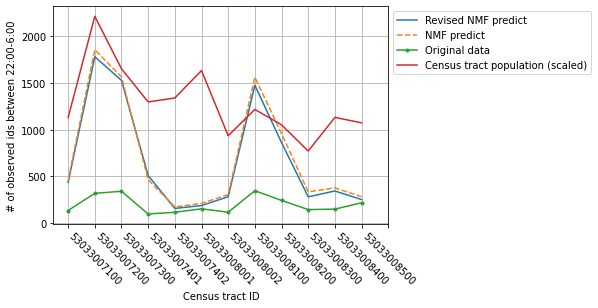

In [36]:
plot_num_idsinhomehr(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero, ct_pop, geoids)

In [44]:
def plot_num_idsinhome_census(test_dt, WH, WH_nozero, ct_pop, geoids, time_seg, percentage_index=False):    
    census_num = len(geoids)
    cur_dt = get_census_home(select_idsfor_home(test_dt, census_num, time_seg), census_num)
    est1 = get_census_home(select_idsfor_home(WH, census_num, time_seg), census_num)
    est2 = get_census_home(select_idsfor_home(WH_nozero, census_num, time_seg), census_num)
    
    if percentage_index == True:
        cur_dt = cur_dt/np.sum(cur_dt)
        est1 = est1/np.sum(est1)
        est2 = est2/np.sum(est2)
        ct_pop = ct_pop/np.sum(ct_pop)
    
    #x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, ax = plt.subplots()
    ax.plot(est1, label='Revised NMF predict')
    ax.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax.plot(cur_dt, '.-', label='Original data')
    
    ax.plot(ct_pop, label='Census tract population')
    if percentage_index == True:
        ax.set_ylabel('% of observed ids between 22:00-6:00', fontsize=12)    
    else:
        ax.set_ylabel('# of observed ids between 22:00-6:00', fontsize=12)    
    
    geo_label = ['']
    geo_label.extend(geoids)
    ax.set_xticks(np.arange(0, 13, 1))
    ax.set_xticklabels(geo_label, rotation=315)
    ax.set_xlabel('Census tract ID', fontsize=12)
    ax.grid()
    leg = ax.legend(bbox_to_anchor=(1, 1), fontsize=12)
    #ax.set_title('Hourly observation distribution (app-based data)')
    
    print('pop', scipy.stats.kstest(cur_dt, ct_pop))
    print('est1', scipy.stats.kstest(est1, ct_pop))
    print('est2', scipy.stats.kstest(est2, ct_pop))
    print('est1 vs dt', scipy.stats.kstest(est1, cur_dt))
    print('est2 vs dt', scipy.stats.kstest(est2, cur_dt))
    print('est1 vs est2', scipy.stats.kstest(est1, est2))
    
    print('pop', scipy.stats.ks_2samp(cur_dt, ct_pop))
    print('est1', scipy.stats.ks_2samp(est1, ct_pop))
    print('est2', scipy.stats.ks_2samp(est2, ct_pop))
    print('est1 vs dt', scipy.stats.ks_2samp(est1, cur_dt))
    print('est2 vs dt', scipy.stats.ks_2samp(est2, cur_dt))
    print('est1 vs est2', scipy.stats.ks_2samp(est1, est2))
    
    print('pop', scipy.stats.wilcoxon(cur_dt, ct_pop))
    print('est1', scipy.stats.wilcoxon(est1, ct_pop))
    print('est2', scipy.stats.wilcoxon(est2, ct_pop)) 
    print('est1 vs dt', scipy.stats.wilcoxon(est1, cur_dt))
    print('est2 vs dt', scipy.stats.wilcoxon(est2, cur_dt))
    print('est1 vs est2', scipy.stats.wilcoxon(est1, est2))
    
    print('pop', scipy.stats.mannwhitneyu(cur_dt, ct_pop))
    print('est1', scipy.stats.mannwhitneyu(est1, ct_pop))
    print('est2', scipy.stats.mannwhitneyu(est2, ct_pop))
    print('est1 vs dt', scipy.stats.mannwhitneyu(est1, cur_dt))
    print('est2 vs dt', scipy.stats.mannwhitneyu(est2, cur_dt))
    print('est1 vs est2', scipy.stats.mannwhitneyu(est1, est2))

In [46]:
255/281

0.9074733096085409

pop KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est1 KstestResult(statistic=0.6666666666666666, pvalue=0.007859014050964517)
est2 KstestResult(statistic=0.6666666666666666, pvalue=0.007859014050964517)
est1 vs dt KstestResult(statistic=0.75, pvalue=0.0014969550573265746)
est2 vs dt KstestResult(statistic=0.75, pvalue=0.0014969550573265746)
est1 vs est2 KstestResult(statistic=0.08333333333333333, pvalue=1.0)
pop KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est1 KstestResult(statistic=0.6666666666666666, pvalue=0.007859014050964517)
est2 KstestResult(statistic=0.6666666666666666, pvalue=0.007859014050964517)
est1 vs dt KstestResult(statistic=0.75, pvalue=0.0014969550573265746)
est2 vs dt KstestResult(statistic=0.75, pvalue=0.0014969550573265746)
est1 vs est2 KstestResult(statistic=0.08333333333333333, pvalue=1.0)
pop WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est1 WilcoxonResult(statistic=3.0, pvalue=0.00244140625)
est2 WilcoxonResult(statistic=3.0, pv

C:\Users\29700\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


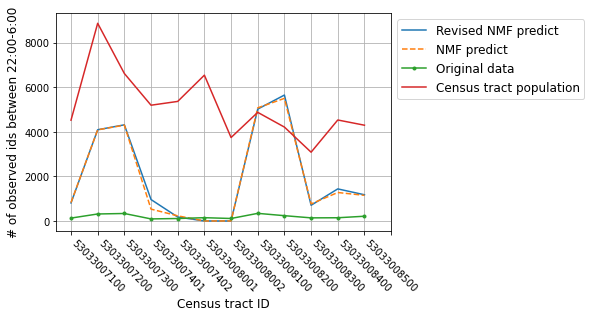

In [45]:
plot_num_idsinhome_census(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero, ct_pop, geoids, 288)

In [37]:
census_num = 12
time_seg=288
cur_dt = get_census_home(select_idsfor_home(test_matrice_reverse[:, 1:], census_num, time_seg), census_num)
est1 = get_census_home(select_idsfor_home(WH_ct, census_num, time_seg), census_num)
est2 = get_census_home(select_idsfor_home(WH_ct_nozero, census_num, time_seg), census_num)

In [41]:
print(cal_rmse(ct_pop, cur_dt, withids=False))
print(cal_rmse(ct_pop, est1, withids=False))
print(cal_rmse(ct_pop, est2, withids=False))

5161.1446485574625
3764.842150298823
3805.988417393481


pop KstestResult(statistic=0.4166666666666667, pvalue=0.2557751845677543)
est1 KstestResult(statistic=0.5833333333333334, pvalue=0.031436056203858066)
est2 KstestResult(statistic=0.5833333333333334, pvalue=0.031436056203858066)
est1 vs dt KstestResult(statistic=0.5, pvalue=0.09954677170991616)
est2 vs dt KstestResult(statistic=0.5, pvalue=0.09954677170991616)
est1 vs est2 KstestResult(statistic=0.16666666666666666, pvalue=0.9984852944874484)
pop WilcoxonResult(statistic=36.0, pvalue=0.85009765625)
est1 WilcoxonResult(statistic=35.0, pvalue=0.791015625)
est2 WilcoxonResult(statistic=35.0, pvalue=0.791015625)
est1 vs dt WilcoxonResult(statistic=33.0, pvalue=0.67724609375)
est2 vs dt WilcoxonResult(statistic=34.0, pvalue=0.7333984375)
est1 vs est2 WilcoxonResult(statistic=26.0, pvalue=0.33935546875)
pop MannwhitneyuResult(statistic=59.0, pvalue=0.47048642205878966)
est1 MannwhitneyuResult(statistic=49.0, pvalue=0.19383392855486403)
est2 MannwhitneyuResult(statistic=49.0, pvalue=0.19383392

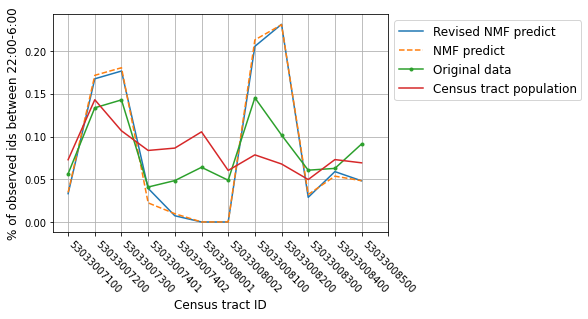

In [21]:
plot_num_idsinhome_census(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero, ct_pop, geoids, 288, True)

In [12]:
#data sources processing
geoids = sorted(list(np.unique(Seattle_ct['GEOID10'])))
#cur_dt = get_census_obsbyhr(test_matrice_reverse[:, 1:], geoids)

#check land use data
#os.listdir('census_block_data/')
os.chdir('G:/My Drive/2021/Bias')
geo_with_landuse = pd.read_csv('census_block_data/ct_with_land_use.csv')

ct_land_use = geo_with_landuse.groupby(['GEOID10', 'CLASS_DESC']).size().to_frame()

ct_land_use.reset_index(inplace=True)

ct_land_use.columns = ['GEOID10', 'CLASS_DESC','count']
ct_land_use.sort_values(by=['GEOID10','count'], ascending=True)
max_land = ct_land_use.groupby(['GEOID10']).max()
max_land.reset_index(inplace=True)

max_label = list(max_land['CLASS_DESC'].values)

x_label = []
for i in range(len(geoids)):
    x_label.append(str(geoids[i])+' ('+max_label[i]+')' )

pop KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est1 KstestResult(statistic=0.6666666666666666, pvalue=0.007859014050964517)
est2 KstestResult(statistic=0.6666666666666666, pvalue=0.007859014050964517)
pop WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est1 WilcoxonResult(statistic=3.0, pvalue=0.00244140625)
est2 WilcoxonResult(statistic=3.0, pvalue=0.00244140625)
est1 vs dt KstestResult(statistic=0.75, pvalue=0.0014969550573265746)
est2 vs dt KstestResult(statistic=0.75, pvalue=0.0014969550573265746)
est1 vs est2 KstestResult(statistic=0.08333333333333333, pvalue=1.0)
est1 vs dt WilcoxonResult(statistic=5.0, pvalue=0.0048828125)
est2 vs dt WilcoxonResult(statistic=4.0, pvalue=0.00341796875)
est1 vs est2 WilcoxonResult(statistic=21.0, pvalue=0.5076243443095237)


C:\Users\29700\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


pop KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est1 KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est2 KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
pop WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est1 WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est2 WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est1 vs dt KstestResult(statistic=0.5, pvalue=0.09954677170991616)
est2 vs dt KstestResult(statistic=0.5833333333333334, pvalue=0.031436056203858066)
est1 vs est2 KstestResult(statistic=0.25, pvalue=0.8689816711757754)
est1 vs dt WilcoxonResult(statistic=38.0, pvalue=0.9697265625)
est2 vs dt WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
est1 vs est2 WilcoxonResult(statistic=8.0, pvalue=0.01220703125)
est1 vs dt KstestResult(statistic=0.5833333333333334, pvalue=0.031436056203858066)
est2 vs dt KstestResult(statistic=0.5833333333333334, pvalue=0.031436056203858066)
est1 vs est2 KstestResult(statistic=0.25, pvalue=0.86898167117577

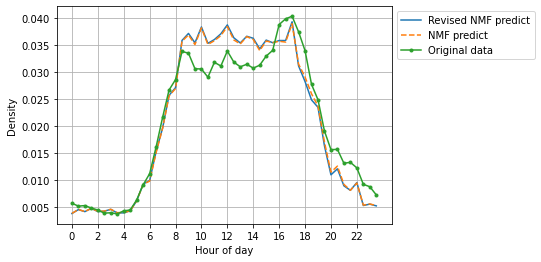

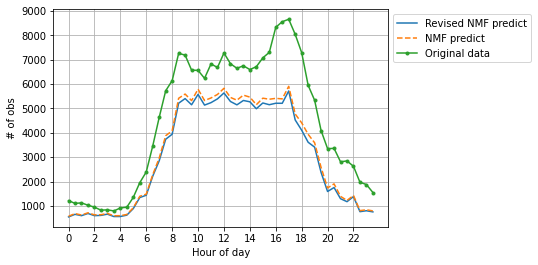

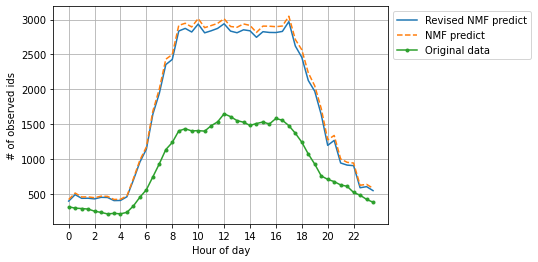

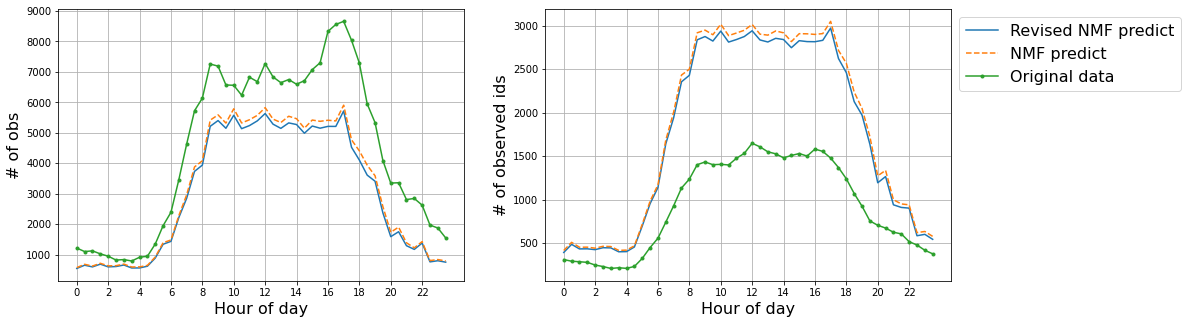

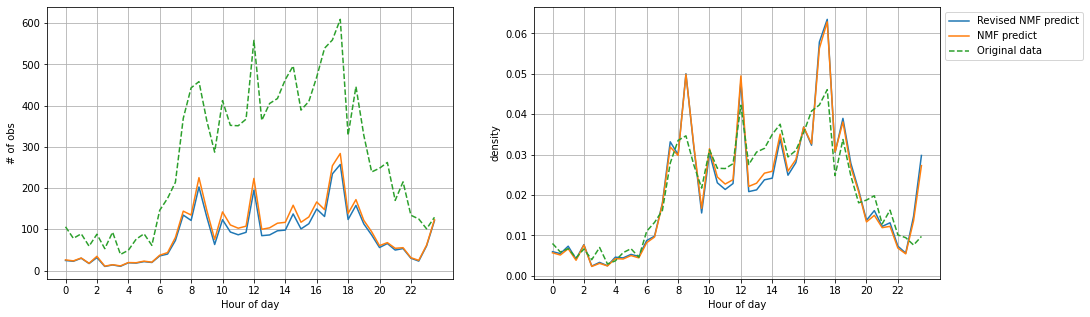

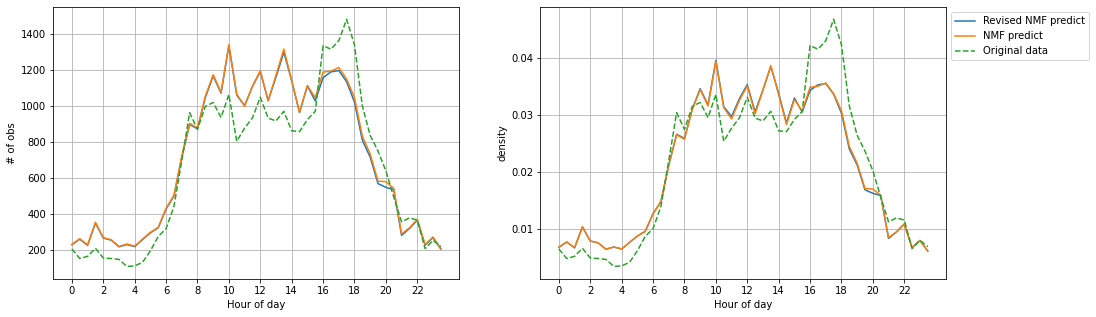

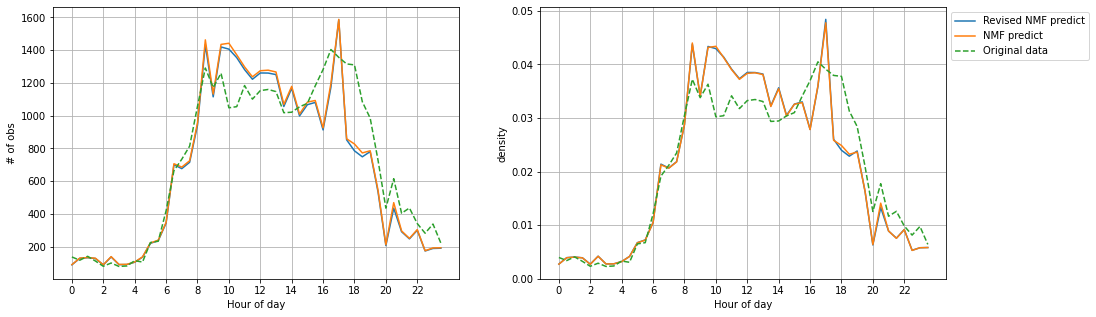

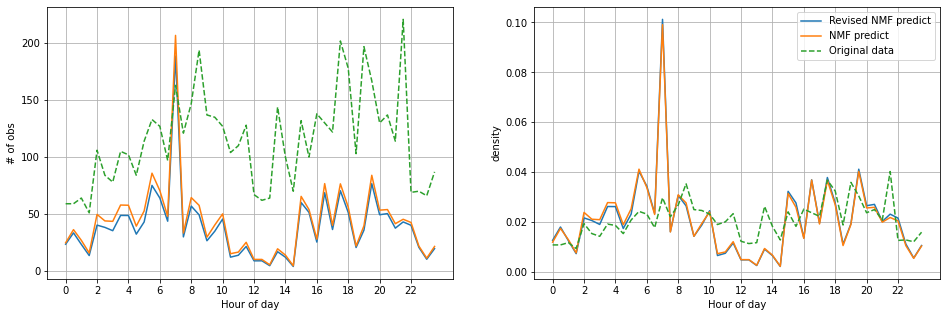

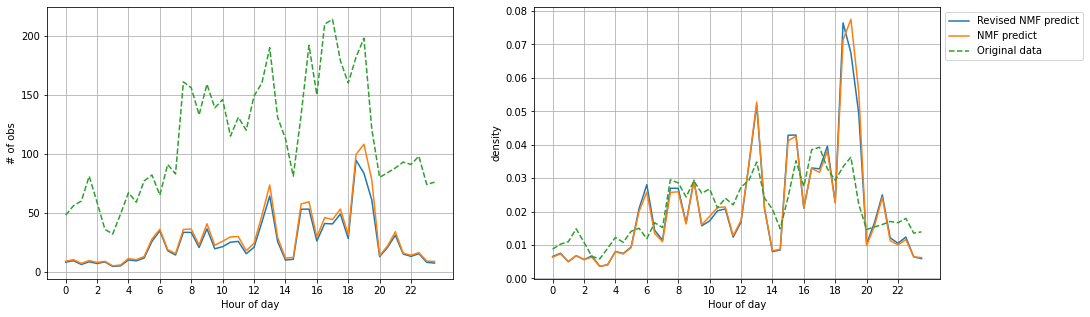

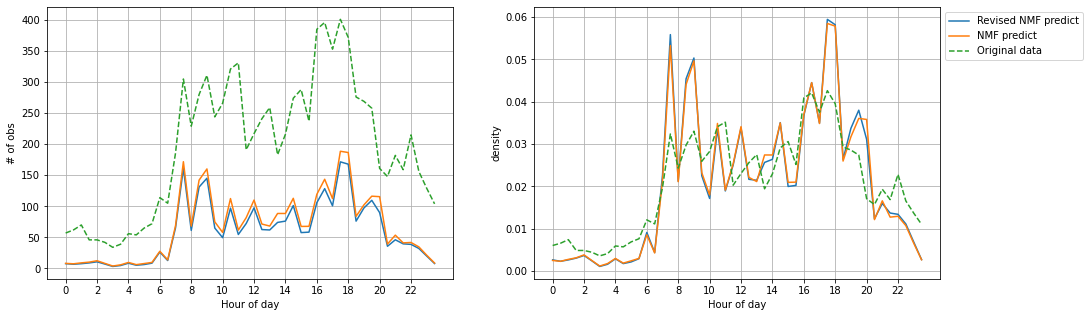

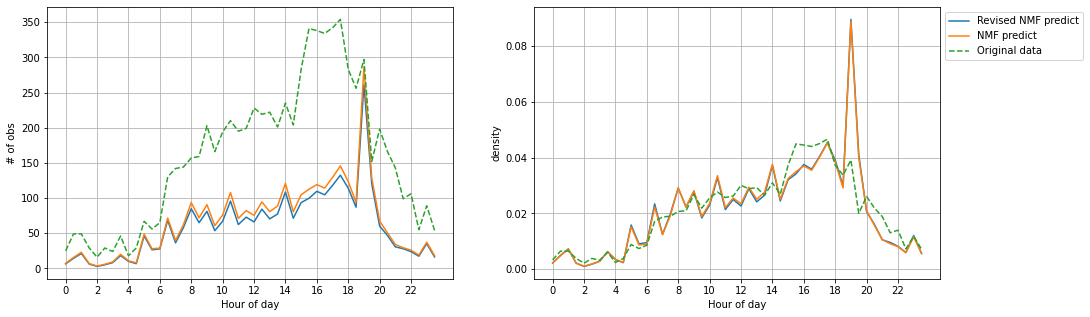

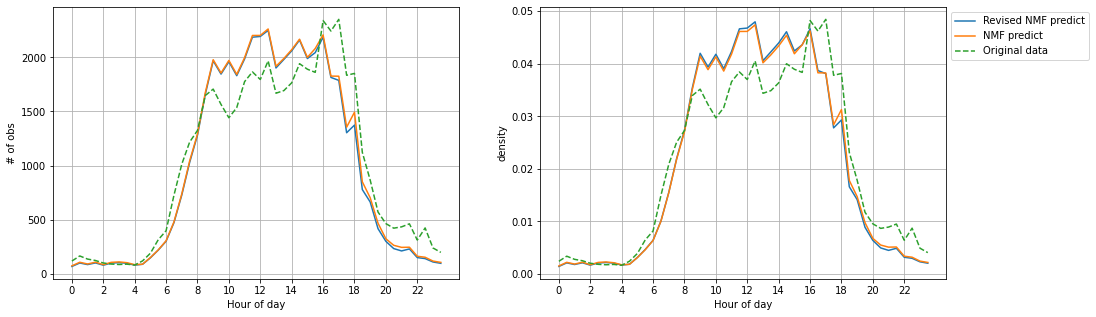

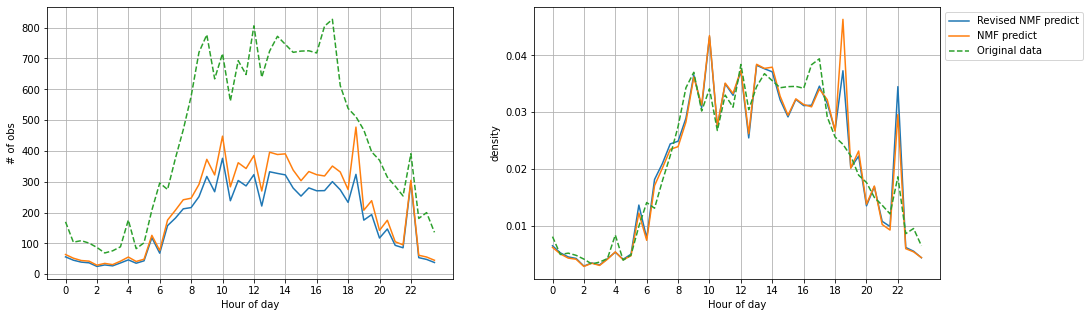

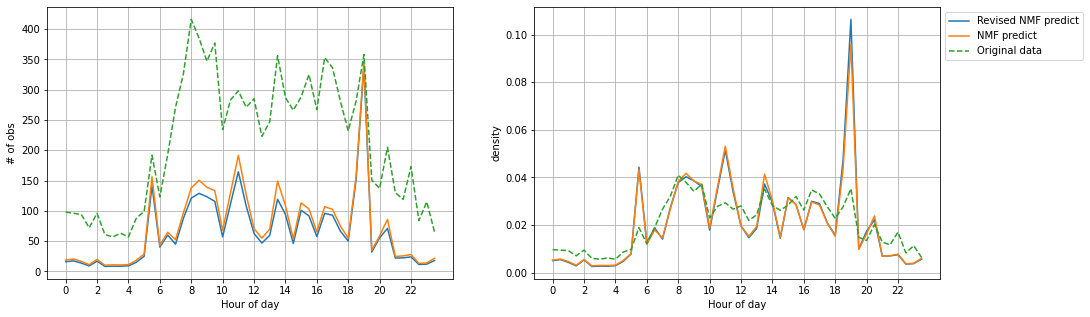

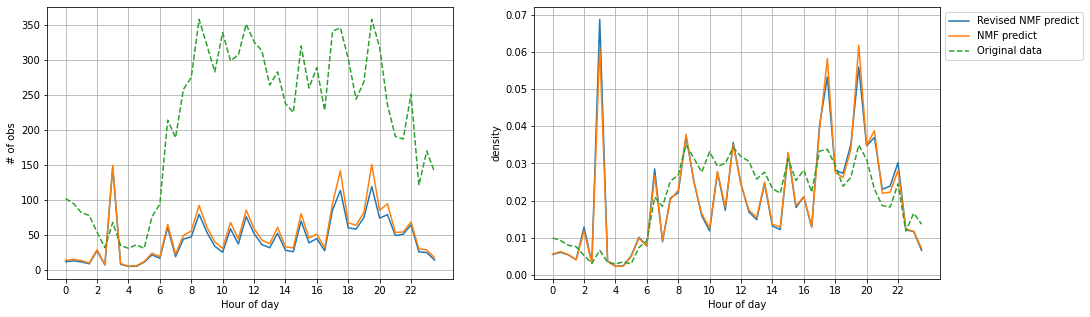

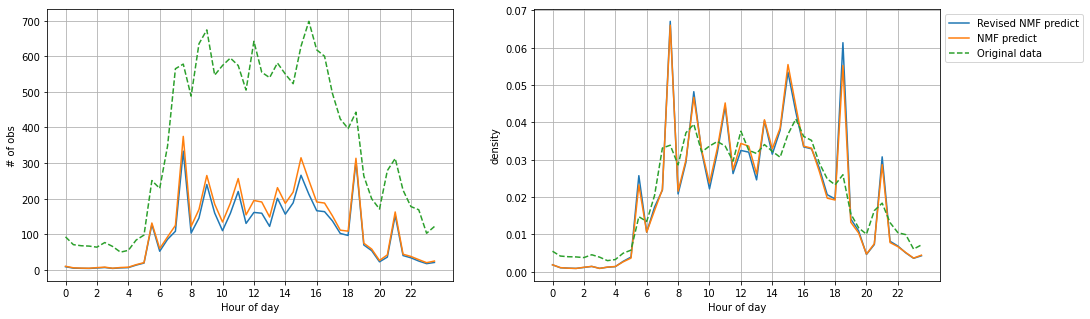

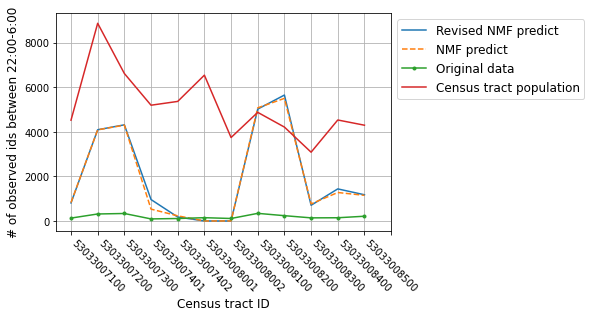

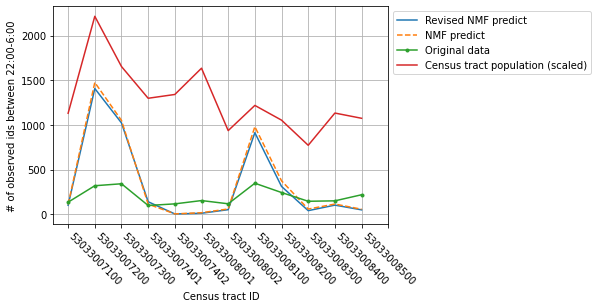

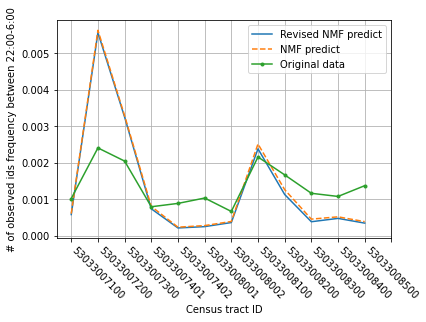

In [581]:
#estimation vs. original
#plot obs and density
sum_plot_hourly(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero)
sum_plot_hourly(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero, density_plot=False)

#plot number of ods
sumid_plot_hourly(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero)

#num obs vs num ids
plot_obs_and_observed_ids(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero) #(combine of plot ods and density)

#check hourly obs by census
census_plot_hourly(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero, geoids)

#check num ids by census
plot_num_idsinhome_census(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero, ct_pop, geoids, 288)

#check frequency (#not considering the exclusive info from the users in the estimation results)
plot_num_idsinhomehr(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero, ct_pop, geoids)
plot_num_idsinhomehr(test_matrice_reverse[:, 1:], WH_ct, WH_ct_nozero, ct_pop, geoids, True)

In [592]:
x_label

['53033007100 (Seattle Mixed)',
 '53033007200 (Seattle Mixed)',
 '53033007300 (Seattle Mixed)',
 '53033007401 (Multi-Family/Residential-Commercial)',
 '53033007402 (Multi-Family/Residential-Commercial)',
 '53033008001 (Seattle Mixed)',
 '53033008002 (Downtown)',
 '53033008100 (Downtown)',
 '53033008200 (Multi-Family)',
 '53033008300 (Multi-Family)',
 '53033008400 (Multi-Family)',
 '53033008500 (Multi-Family)']

In [ ]:
revised_dt = assign_valtoorigin_dt(test_matrice_reverse[:, 1:], WH_ct, 12, 288)
revised_dt_nozero = assign_valtoorigin_dt(test_matrice_reverse[:, 1:], WH_ct_nozero, 12, 288)

pop KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est1 KstestResult(statistic=0.6666666666666666, pvalue=0.007859014050964517)
est2 KstestResult(statistic=0.6666666666666666, pvalue=0.007859014050964517)
pop WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est1 WilcoxonResult(statistic=3.0, pvalue=0.00244140625)
est2 WilcoxonResult(statistic=3.0, pvalue=0.00244140625)
est1 vs dt KstestResult(statistic=0.75, pvalue=0.0014969550573265746)
est2 vs dt KstestResult(statistic=0.75, pvalue=0.0014969550573265746)
est1 vs est2 KstestResult(statistic=0.08333333333333333, pvalue=1.0)
est1 vs dt WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est2 vs dt WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est1 vs est2 WilcoxonResult(statistic=21.0, pvalue=0.5076243443095237)


C:\Users\29700\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


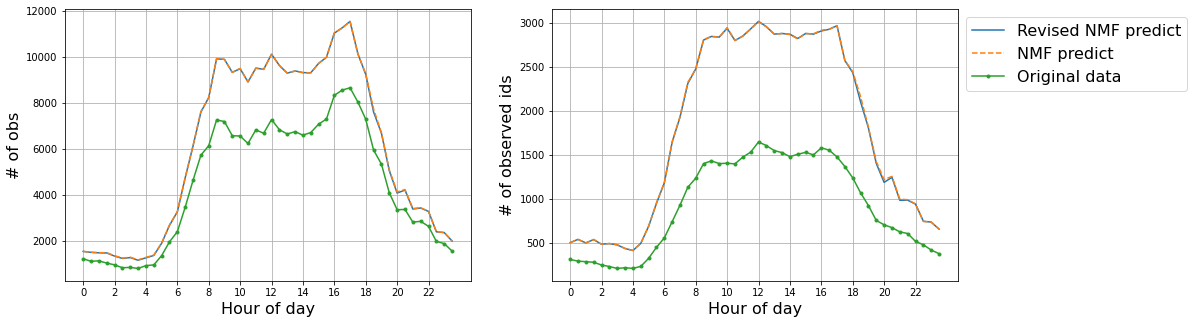

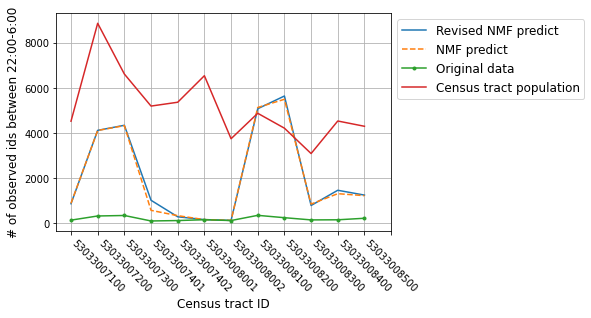

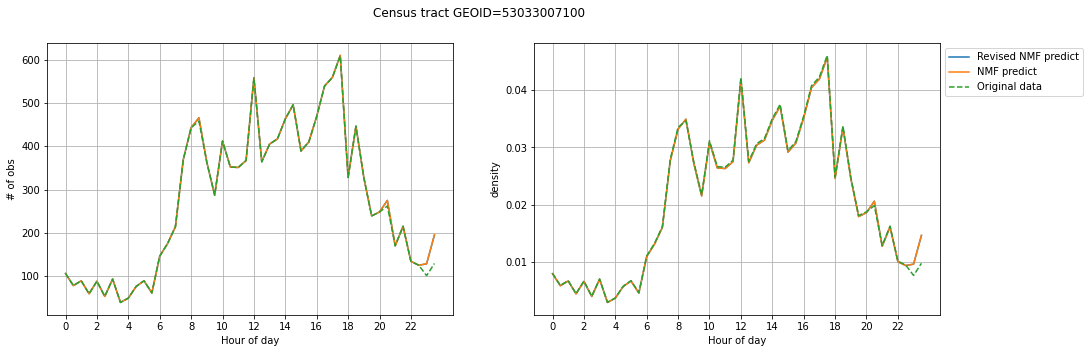

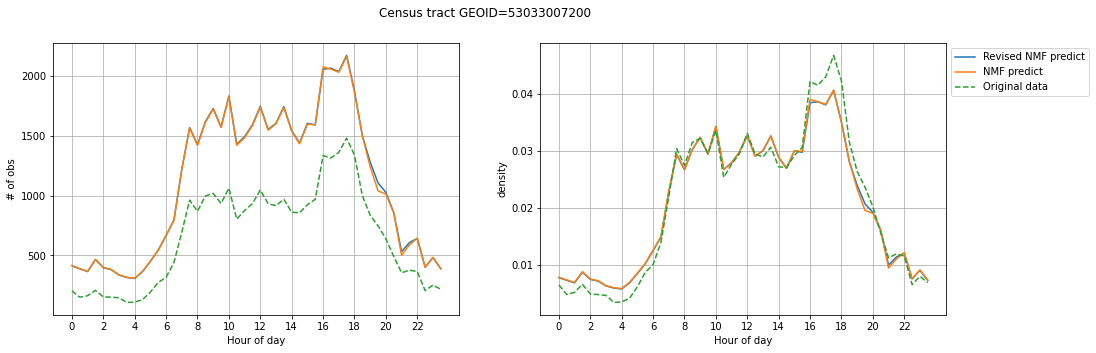

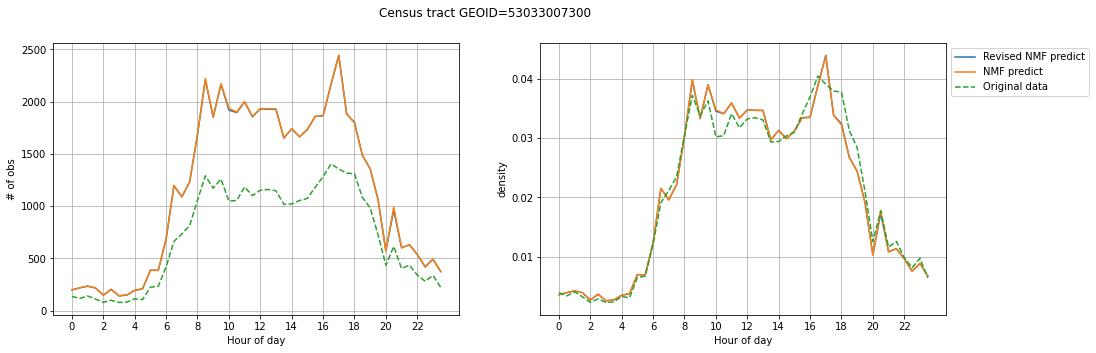

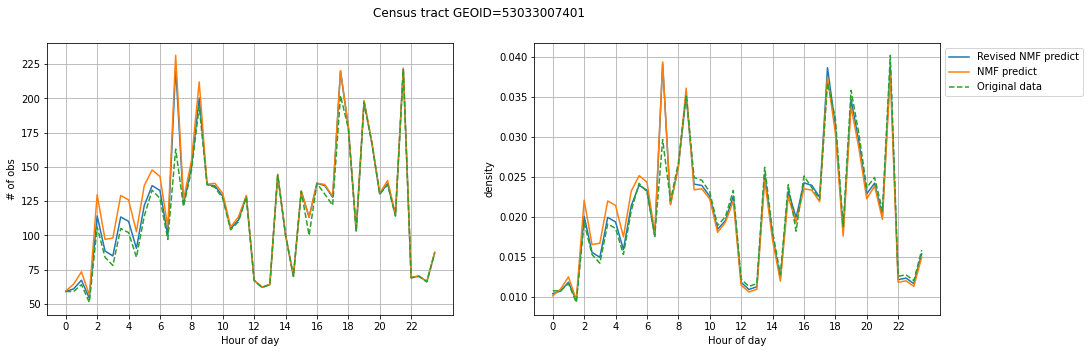

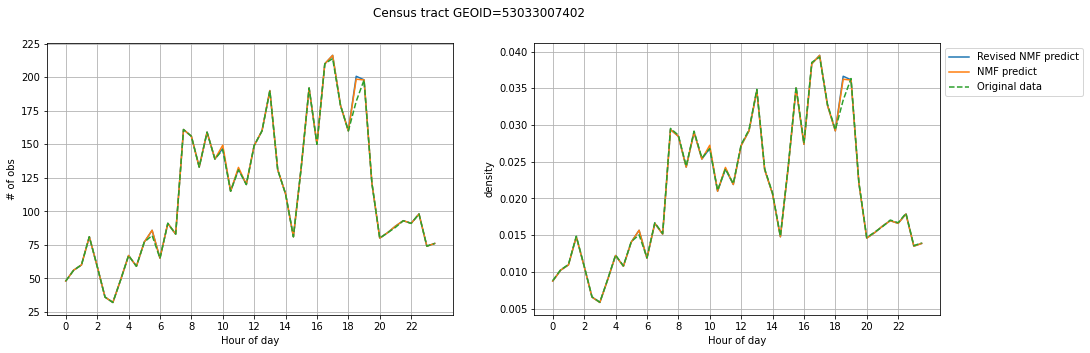

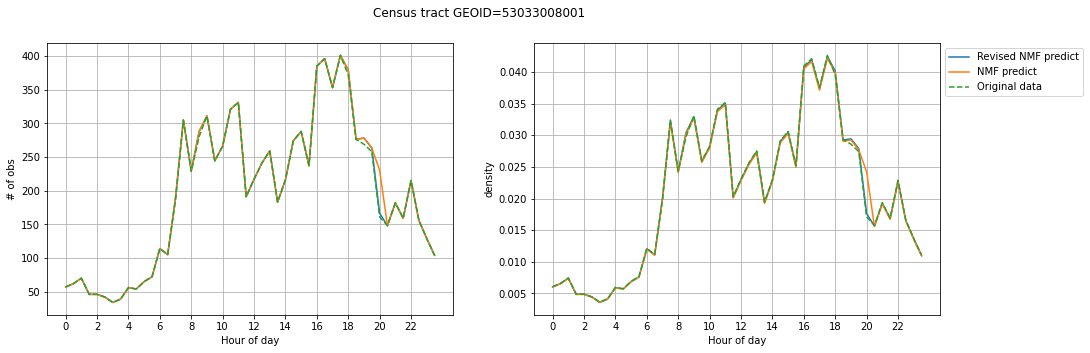

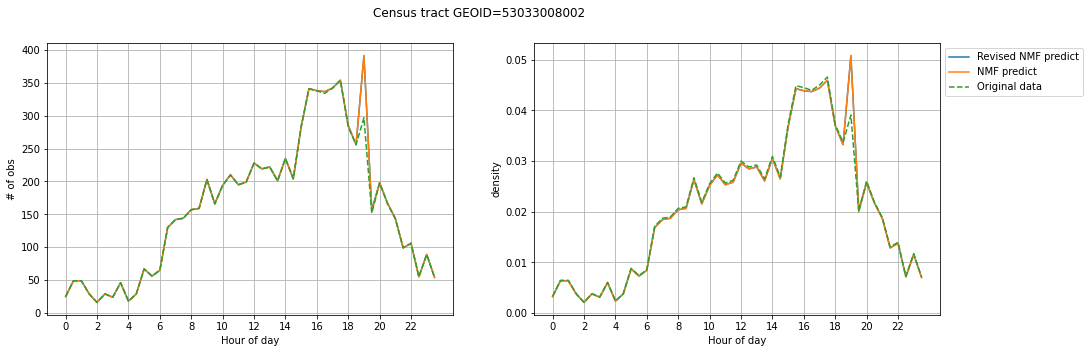

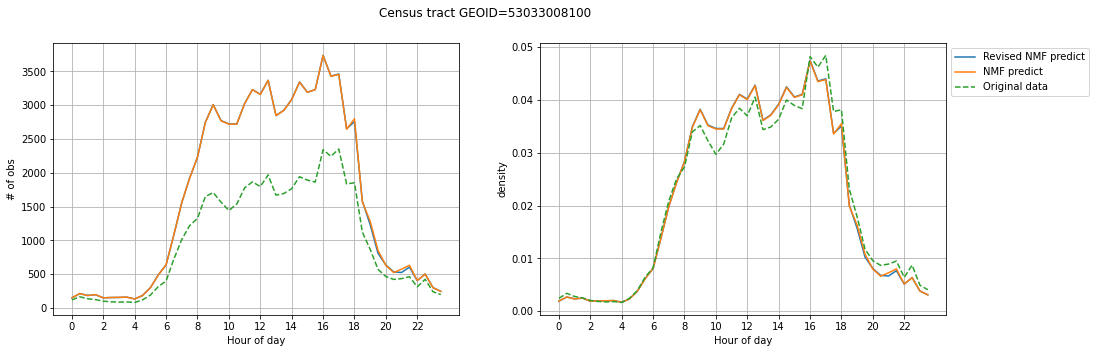

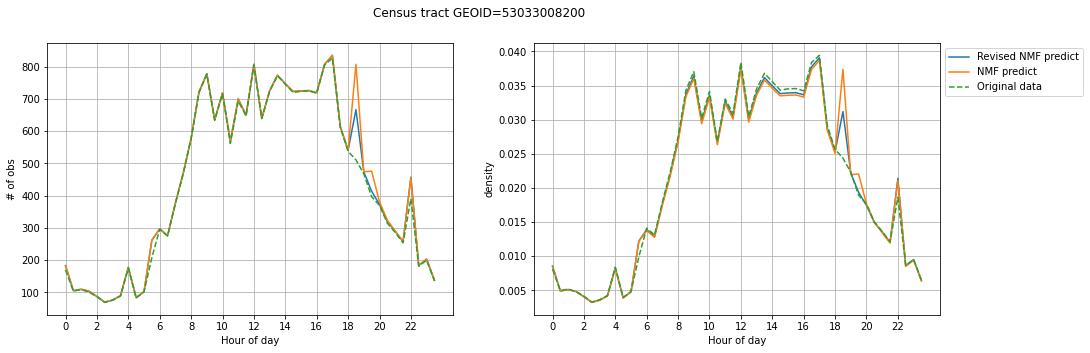

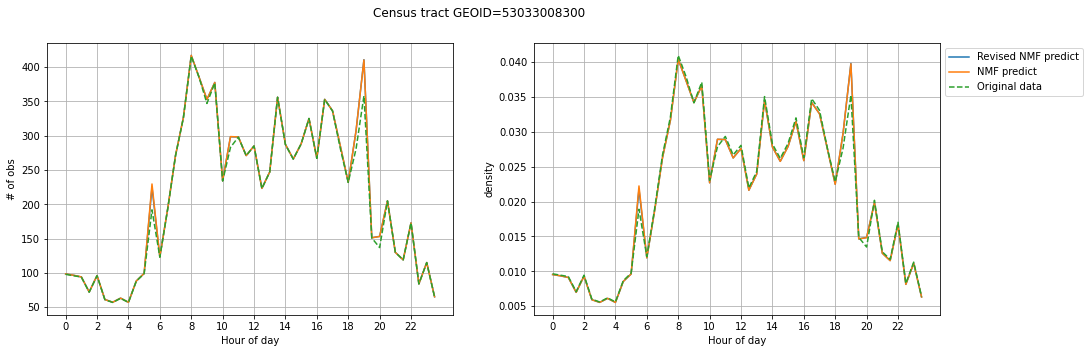

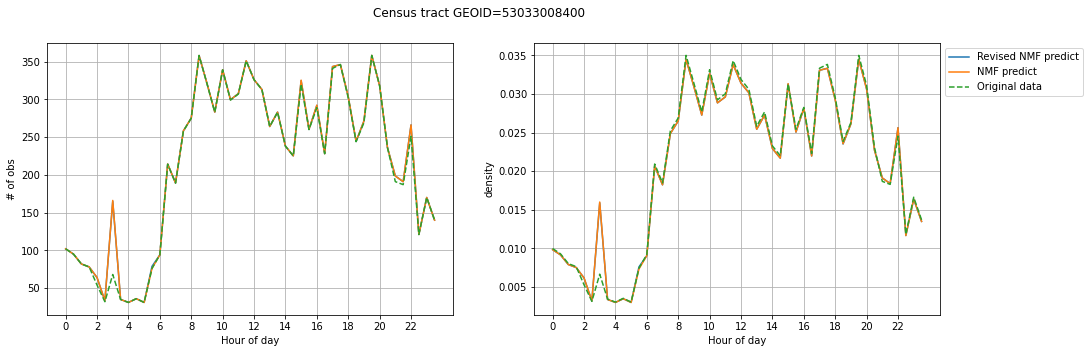

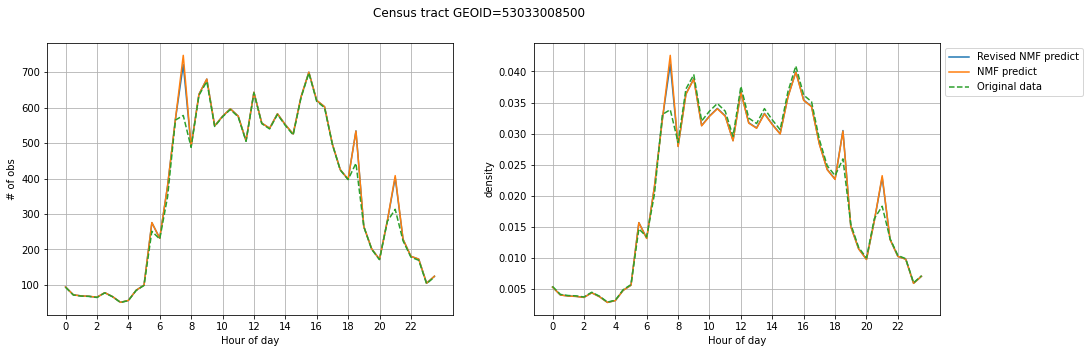

In [594]:
#revised dt vs. original dt
#check obs and num id based on the revised data
plot_obs_and_observed_ids(test_matrice_reverse[:, 1:], revised_dt, revised_dt_nozero)
plot_num_idsinhome_census(test_matrice_reverse[:, 1:], revised_dt, revised_dt_nozero, ct_pop, geoids, 288)

census_plot_hourly(test_matrice_reverse[:, 1:], revised_dt, revised_dt_nozero, geoids)

In [432]:
#previous data check
def extract_01(metrics, user_ids, item_ids):
    m_01 = np.zeros(metrics.shape)
    for person in range(len(user_ids)):
        for bin in range(288):
            max_val = 0
            max_y_idx = -1
            for loc in range(12):
                y = loc * 288 + bin
                if metrics[person][y] > max_val:
                    max_val = metrics[person][y]
                    max_y_idx = y
            if max_val > 0:
                #print(f'person {person} idx {max_y_idx} {item_ids[max_y_idx]}')
                m_01[person][max_y_idx] = max_val
    return np.copy(m_01)

In [433]:
org_m_01 = extract_01(org_m, user_ids, item_ids)

In [434]:
est_m_01 = extract_01(est_m, user_ids, item_ids)

In [435]:
sum(sum(org_m_01))

214525.0

In [436]:
sum(sum(est_m_01))

97427.5484457376

In [428]:
get_hourly_obs(org_m_01)

array([1205724., 1091680., 1092597.,  983773.,  891150.,  785978.,
        753362.,  797854.,  762583.,  881775., 1140183., 1674391.,
       2085142., 3019846., 3841951., 4689076., 5318341., 6166682.,
       6303933., 6163890., 5963737., 6091089., 6611834., 6773387.,
       7132857., 7074871., 6709695., 6773332., 6498099., 6686047.,
       6687210., 6655044., 6900825., 6604608., 6761056., 5755234.,
       5271378., 4355204., 3718845., 3188047., 2968211., 2765513.,
       2593064., 2551416., 2240741., 2078628., 1856408., 1618425.])

(array([4.122e+03, 1.331e+03, 7.660e+02, 5.220e+02, 3.100e+02, 2.040e+02,
        1.440e+02, 9.100e+01, 7.600e+01, 4.900e+01, 3.700e+01, 3.100e+01,
        2.000e+01, 1.400e+01, 7.000e+00, 1.100e+01, 8.000e+00, 7.000e+00,
        1.000e+00, 0.000e+00]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
        165., 180., 195., 210., 225., 240., 255., 270., 285., 300.]),
 <BarContainer object of 20 artists>)

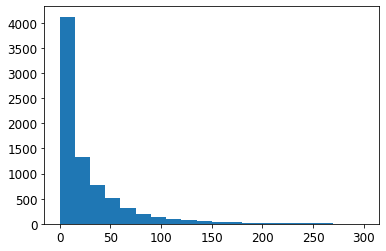

In [443]:
#plt.hist(np.sum(org_m_01, axis=1))
plt.hist(np.sum(org_m_01, axis=1), range=[0,300], bins=20)

(array([6.056e+03, 8.120e+02, 3.510e+02, 1.930e+02, 1.150e+02, 8.200e+01,
        4.100e+01, 4.100e+01, 2.000e+01, 1.200e+01, 1.600e+01, 6.000e+00,
        7.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
        165., 180., 195., 210., 225., 240., 255., 270., 285., 300.]),
 <BarContainer object of 20 artists>)

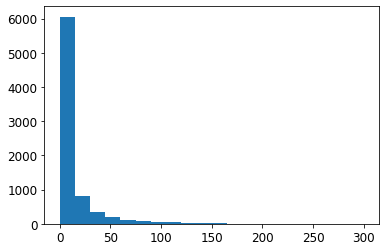

In [442]:
plt.hist(np.sum(est_m_01, axis=1), range=[0,300], bins=20)

In [329]:
x = np.arange(0, 48, 0.5)
#plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
#plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
fig, ax = plt.subplots()
ax.plot(avg_est, label='Revised data')
#ax.plot(avg_est2, label='estimated 2')
ax.plot(avg_cur_dt, '--', label='Original data')

ax.set_xticks(np.arange(0, 48, 4))
ax.set_xticklabels(np.arange(0,24,2))

ax.set_ylabel('Density')
ax.set_xlabel('Hour of day')

ax.grid()
leg = ax.legend(bbox_to_anchor=(1, 1))
#ax.set_title('Hourly observation distribution (app-based data)')


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [216]:
start_index = 0 
#number of geo zones = 12
index = []
for i in range(12):
    start_index += i*time_interval
    index.append(start_index)
    

[0, 288, 864, 1728, 2880, 4320, 6048, 8064, 10368, 12960, 15840, 19008]

In [210]:
time_interval = 288
def fill_data(matrix, time_interval):
    new_mt = np.zeros(matrix.shape)
    

'53033007300_0_0'

In [180]:
112360/1934221

0.058090569795281925

In [193]:
est_n0 = np.count_nonzero(WH)
data_n0 = np.count_nonzero(test_matrice_reverse[:, 1:])
print('est_nonzeros', est_n0)
print('dt_nonzeros', data_n0)
total_data = 7767*3456

print('est non zero per', est_n0/total_data)

print('dt non zero per', data_n0/total_data)

print('est non zero 0.01', (np.argwhere(WH > 0.01)).shape[0]/total_data)

est_nonzeros 25727485
dt_nonzeros 112360
est non zero per 0.9584518383211975
dt non zero per 0.004185859929712125
est non zero 0.01 0.07205747756414842


In [156]:
np.sum(test_matrice_reverse[0, 1:])

56.0

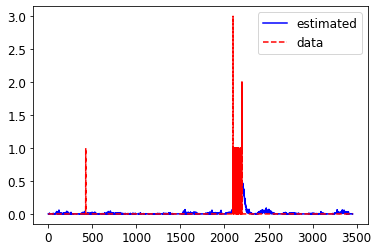

In [162]:
#x = np.linspace(0, 10, 1000)
fig, ax = plt.subplots()
ax.plot(WH[0, :], '-b', label='estimated')
ax.plot(test_matrice_reverse[0, 1:], '--r', label='data')

leg = ax.legend( )

In [ ]:
print(WH)
zero_val.append(zero_est_eval(WH, zero_test))
rmse_test, mae_test = (non_zero_est_eval(X, WH, zero_test))
rmse_val.append(rmse_test)
mae_val.append(mae_test)

### Simple test

[[1. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[1.  1. ]
 [2.  1. ]
 [3.  1.2]
 [4.  1. ]
 [5.  0.8]
 [6.  1. ]]
[[0.99813104 0.93628194]
 [1.9868344  0.94751948]
 [2.97778527 1.14543386]
 [3.96424112 0.96999457]
 [4.94274178 0.84171335]
 [5.93847476 1.01127952]]
[[0.90756947 0.85439881]
 [1.80813673 0.94445762]
 [2.97780456 1.1443937 ]
 [3.96413314 0.96944538]
 [4.94259496 0.84116233]
 [5.93829599 1.01061708]]
[[0.83204551 0.78588483]
 [1.65894234 0.94191849]
 [2.97781555 1.14359936]
 [3.9640477  0.96902157]
 [4.94250043 0.84062144]
 [5.93817968 1.00996676]]


<ipython-input-11-10c18a75df43>:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
<ipython-input-11-10c18a75df43>:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
<ipython-input-11-10c18a75df43>:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
<ipython-input-11-10c18a75df43>:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
<ipython-input-11-10c18a75df43>:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
<ipython-input-11-10c18a

[[0.76810612 0.72767289]
 [1.53249671 0.93979606]
 [2.97781967 1.14298928]
 [3.96397807 0.96869219]
 [4.9424411  0.84010285]
 [5.93810553 1.00934322]]
[[0.71327933 0.67757583]
 [1.42396278 0.9380075 ]
 [2.97781844 1.14251832]
 [3.96391996 0.96843452]
 [4.94240577 0.83961256]
 [5.93806021 1.00875366]]
[[0.66574906 0.63399027]
 [1.32978499 0.93648821]
 [2.97781319 1.14215319]
 [3.96387055 0.96823173]
 [4.94238698 0.83915288]
 [5.93803483 1.00820091]]
[[0.62415129 0.59571277]
 [1.24729097 0.93518768]
 [2.97780501 1.14186923]
 [3.96382788 0.96807132]
 [4.94237967 0.83872403]
 [5.93802335 1.0076852 ]]


<ipython-input-11-10c18a75df43>:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
<ipython-input-11-10c18a75df43>:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
<ipython-input-11-10c18a75df43>:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
<ipython-input-11-10c18a75df43>:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
<ipython-input-11-10c18a75df43>:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
<ipython-input-11-10c18a

[[0.58744169 0.56182167]
 [1.17443313 0.93406623]
 [2.97779476 1.14164799]
 [3.96379056 0.9679439 ]
 [4.94238033 0.83832499]
 [5.93802158 1.00720534]]
[[0.55480725 0.5315986 ]
 [1.10961609 0.93309251]
 [2.97778309 1.14147559]
 [3.96375759 0.96784236]
 [4.94238655 0.83795415]
 [5.93802662 1.00675938]]
[[0.52560563 0.50447505]
 [1.05157831 0.93224156]
 [2.97777051 1.14134147]
 [3.96372821 0.96776126]
 [4.9423966  0.83760959]
 [5.9380364  1.00634502]]


<ipython-input-11-10c18a75df43>:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
<ipython-input-11-10c18a75df43>:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
<ipython-input-11-10c18a75df43>:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
<ipython-input-11-10c18a75df43>:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Text(0, 0.5, 'mae')

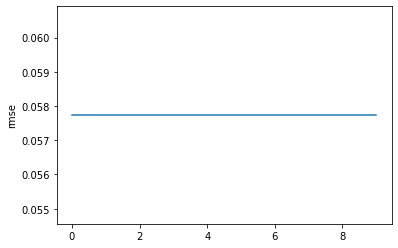

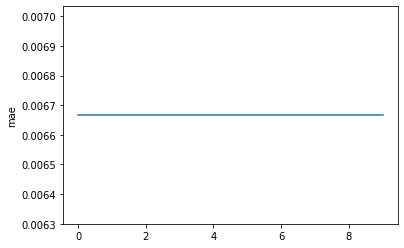

In [12]:
## simple test
zero_test = np.zeros(X.shape)
zero_test[0] += 1
zero_test[1][0] = 1

#model = NMF_w0(n_components=18, init='nndsvd', zero_weight=0.1, max_iter=10, alpha=0.1, l1_ratio=0.1, random_state=42)
#W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
#model = NMF_w0(n_components=2, alpha=0.1, max_iter=1000, l1_ratio=0.1, zero_weight=zero_w, solver="zero", random_state=42)
#W = model.fit_transform_w0(X, zero_test)
#H = model.components_
#WH = np.dot(W, H)
#print(cal_rmse(X, WH))
#print(cal_rmse(X, WH, withids=False))
#print(X)
#print(WH)

def add_val2lst(val, lst):
    if init == True:
        lst = []
    lst.append(val)
    return(lst)

zero_val = []
rmse_val = []
mae_val = []

print(zero_test)
print(X)

for zero_w in 0.1*np.array(list(range(10))):
    model = NMF_w0(n_components=2, alpha=0.1, max_iter=1000, l1_ratio=0.1, zero_weight=zero_w, solver="zero", random_state=42)
    W = model.fit_transform_w0(X, zero_test)
    H = model.components_
    WH = np.dot(W, H)
    
    print(WH)
    zero_val.append(zero_est_eval(WH, zero_test))
    rmse_test, mae_test = (non_zero_est_eval(X, WH, zero_test))
    rmse_val.append(rmse_test)
    mae_val.append(mae_test)

plt.figure(1)
plt.plot(rmse_val)
plt.ylabel("rmse")

plt.figure(2)
plt.plot(mae_val)
plt.ylabel("mae")
#notice that the results of model without zero index is the same for solver='zero' and solver='mu' (test verified)

In [2]:
os.chdir('G:/My Drive/2021/Bias/')
model_result = pd.read_csv('nmf_est_result.csv')

In [3]:
model_result_ma = model_result.to_numpy()

In [4]:
k = np.array(list(range(2, 19)))
l1 = np.round(0.1*np.array(list(range(10))),2)
alpha_para = np.round(0.1*np.array(list(range(10))),2)
zero_w = np.round(0.1*np.array(list(range(1,11))),2)

In [45]:
model_result.columns

Index(['model_with_zero', ' k', ' l1_ratio', ' alpha_w', ' alpha_h',
       ' zero_weight', ' max_iter', ' random_state', 'non_zero_num',
       'zero_per', ' rmse', ' mae', 'run_time'],
      dtype='object')

In [6]:
model_result.head(3)
#model_result[' rmse'][(model_result['model_with_zero']==1) & (model_result[' zero_weight']==0.1) & (model_result[' alpha_w']==0)]

,model_with_zero,k,l1_ratio,alpha_w,alpha_h,zero_weight,max_iter,random_state,non_zero_num,zero_per,rmse,mae,run_time
0,1,2,0.0,0.0,0.0,0.1,1000,42,104.0,0.999764,0.155635,0.042633,NaN
1,1,3,0.0,0.0,0.0,0.1,1000,42,506.0,0.998850,0.155438,0.042472,NaN
2,1,4,0.0,0.0,0.0,0.1,1000,42,542.0,0.998768,0.155031,0.042132,NaN


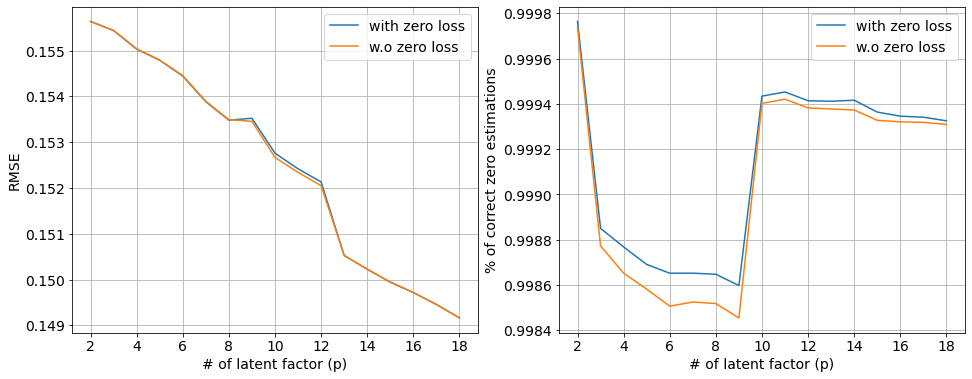

In [7]:
#k value
val_with0 = model_result[' rmse'].values[:17]
val_wo0 = model_result[' rmse'].values[17:34]

zero_per_with0 = model_result['zero_per'].values[:17]
zero_per_wo0 = model_result['zero_per'].values[17:34]

plt.rc('font', size=14)
plt.rc('legend', fontsize=14)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(k, val_with0, label='with zero loss')
ax1.plot(k, val_wo0, label='w.o zero loss')
ax2.plot(k, zero_per_with0, label='with zero loss')
ax2.plot(k, zero_per_wo0, label='w.o zero loss')

ax1.grid(True)
ax2.grid(True)

ax1.set_xlabel('# of latent factor (p)')
ax1.set_ylabel("RMSE")
ax2.set_xlabel('# of latent factor (p)')
ax2.set_ylabel("% of correct zero estimations")

ax1.legend()
ax2.legend()

In [8]:
alpha_withzero_zp = model_result['zero_per'].values[87:97]
alpha_wozero_zp = model_result['zero_per'].values[107:117]

In [17]:
model_result.iloc[44:52]

,model_with_zero,k,l1_ratio,alpha_w,alpha_h,zero_weight,max_iter,random_state,non_zero_num,zero_per,rmse,mae,run_time
44,1,10,0.0,0.0,0.0,0.2,1000,42,235.0,0.999466,0.152743,0.040273,2010.950693
45,1,10,0.0,0.0,0.0,0.3,1000,42,221.0,0.999498,0.152733,0.040275,2010.002795
46,1,10,0.0,0.0,0.0,0.4,1000,42,218.0,0.999505,0.152725,0.040270,2014.639644
47,1,10,0.0,0.0,0.0,0.5,1000,42,209.0,0.999525,0.152721,0.040272,2038.865235
48,1,10,0.0,0.0,0.0,0.6,1000,42,200.0,0.999546,0.152716,0.040270,1994.960378
49,1,10,0.0,0.0,0.0,0.7,1000,42,191.0,0.999566,0.152716,0.040271,2009.494919
50,1,10,0.0,0.0,0.0,0.8,1000,42,174.0,0.999605,0.152709,0.040269,2038.171034
51,1,10,0.0,0.0,0.0,0.9,1000,42,170.0,0.999614,0.152710,0.040269,2050.492254


In [9]:
alpha_withzero_rmse = model_result[' rmse'].values[87:97]
alpha_wozero_rmse = model_result[' rmse'].values[107:117]

In [10]:
zero_w_zp = []
val = model_result['zero_per'].values[25]
zero_w_zp.append(val)
val = model_result['zero_per'].values[8]
zero_w_zp.append(val)
zero_weight = model_result['zero_per'].values[44:52]
zero_w_zp.extend(list(zero_weight))

zero_w_rmse = []
val = model_result[' rmse'].values[25]
zero_w_rmse.append(val)
val = model_result[' rmse'].values[8]
zero_w_rmse.append(val)
zero_weight = model_result[' rmse'].values[44:52]
zero_w_rmse.extend(list(zero_weight))

In [11]:
len(zero_w_zp)

10

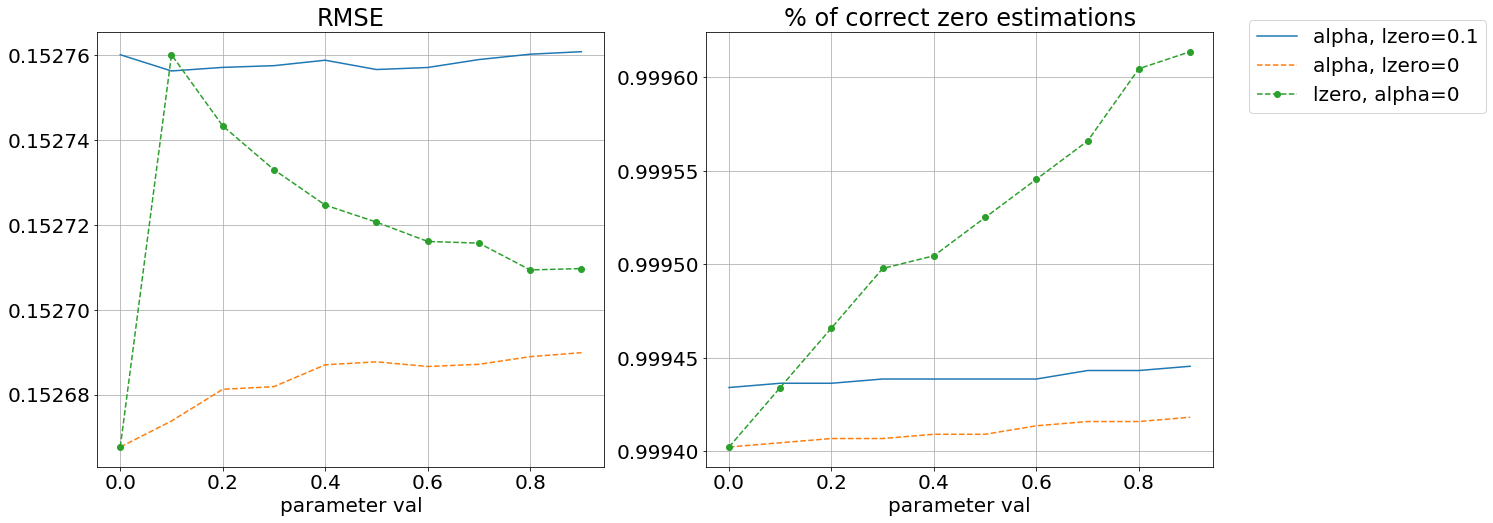

In [41]:
plt.rc('font', size=20)
plt.rc('legend', fontsize=20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.plot(alpha_para, alpha_withzero_rmse, label='alpha, lzero=0.1')
ax1.plot(alpha_para, alpha_wozero_rmse, '--', label='alpha, lzero=0')
ax1.plot(alpha_para, zero_w_rmse, '--o', label='lzero, alpha=0')
ax2.plot(alpha_para, alpha_withzero_zp, label='alpha, lzero=0.1')
ax2.plot(alpha_para, alpha_wozero_zp,'--', label='alpha, lzero=0')
ax2.plot(alpha_para, zero_w_zp, '--o', label='lzero, alpha=0')

ax1.grid(True)
ax2.grid(True)

ax1.set_title("RMSE")
ax2.set_title("% of correct zero estimations")
ax1.set_xlabel("parameter val")
ax2.set_xlabel("parameter val")

#ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax2.legend(bbox_to_anchor=(1.05, 1.05))

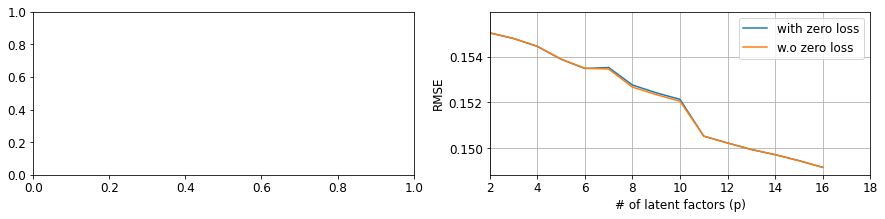

In [35]:
plt.subplots(1, 2, figsize=(15, 3))

plt.plot(val_with0, label='with zero loss')
plt.plot(val_wo0, label='w.o zero loss')
plt.xlim(2, 18, 1)
plt.grid()
plt.ylabel('RMSE')
plt.xlabel('# of latent factors (p)')
plt.legend()

In [19]:
val_wo0

array([0.15563418, 0.15544069, 0.15503948, 0.15479201, 0.1544542 ,
       0.1538926 , 0.15349174, 0.15345563, 0.15266764, 0.15234048,
       0.15205108, 0.15052923, 0.15022607, 0.14994785, 0.14972036,
       0.14945654, 0.14916269])

,model_with_zero,k,l1_ratio,alpha_w,alpha_h,zero_weight,max_iter,random_state,non_zero_num,zero_per,rmse,mae,run_time
0,1,2,0.0,0.0,0.0,0.1,1000,42,104.0,0.999764,0.155635,0.042633,NaN
1,1,3,0.0,0.0,0.0,0.1,1000,42,506.0,0.998850,0.155438,0.042472,NaN
2,1,4,0.0,0.0,0.0,0.1,1000,42,542.0,0.998768,0.155031,0.042132,NaN


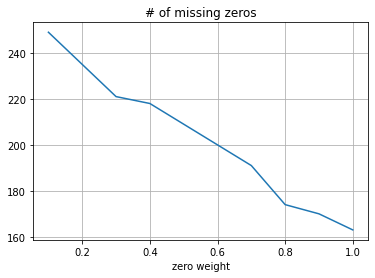

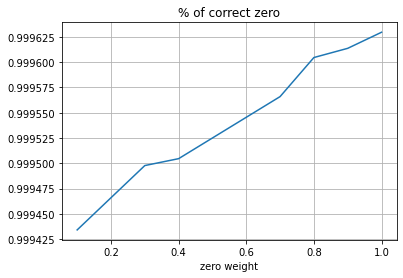

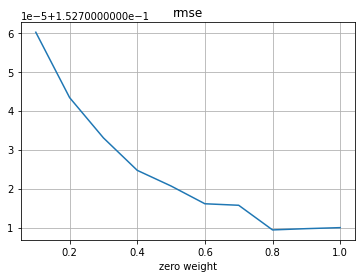

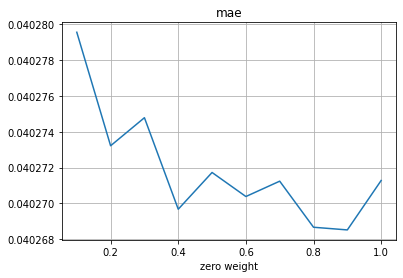

In [18]:
keys = ['# of missing zeros', '% of correct zero', 'rmse', 'mae']
for i in range(4):
    plt.figure(i)
    est_w0 = list(model_result_ma[44:53, 8+i])
    est_w0.insert(0, model_result_ma[8, 8+i])
    plt.plot(zero_w, est_w0)
    plt.grid()
    plt.title(keys[i])
    plt.xlabel('zero weight')

[2.5001908701027155e-05, 7.735094081905905e-05, 0.0001160349134729615, 0.00010921895702059788, 0.0001456302417020105, 0.00012742671182668747, 0.00012970236784772433, 0.0001433620038514668, 3.183201144344542e-05, 3.1830431904193554e-05, 3.183166226683443e-05, 3.4106073197470236e-05, 4.320122982054642e-05, 3.638114834230228e-05, 2.5012369395119216e-05, 2.2738984922765624e-05, 1.5917742932551115e-05]


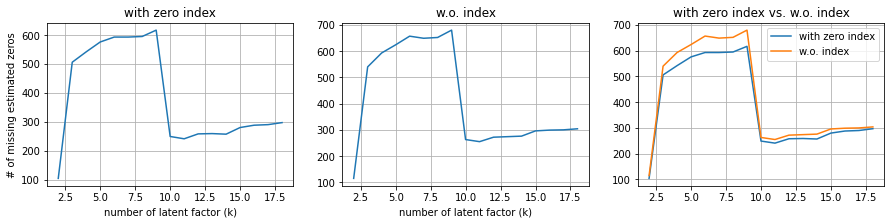

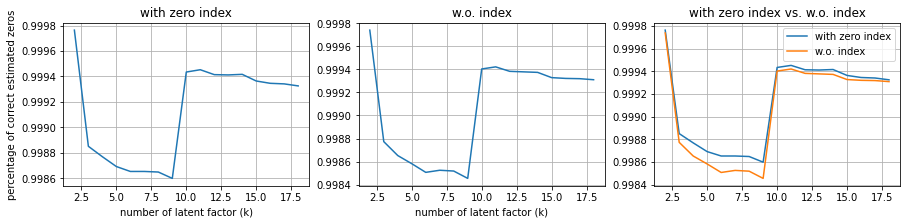

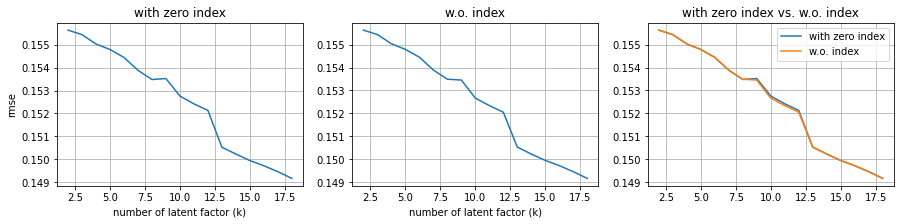

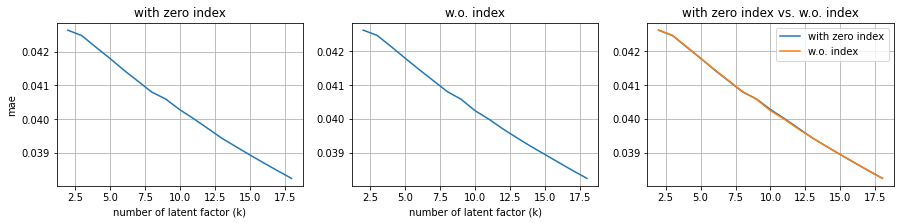

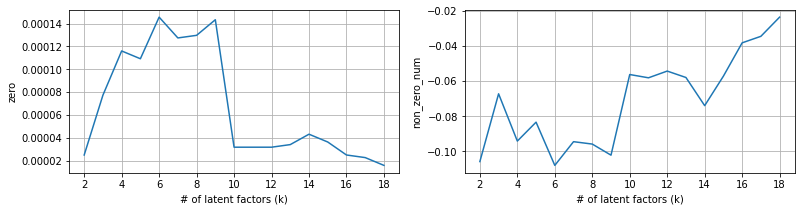

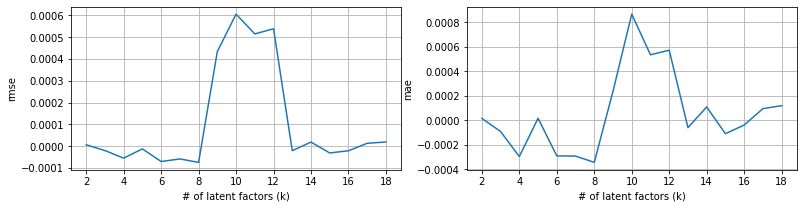

In [200]:
#plot test
compare_plot(model_result_ma[:17, 8], model_result_ma[17:34, 8], 'with zero index',\
             'w.o. index', range(2, 19), 'number of latent factor (k)', '# of missing estimated zeros')

compare_plot(model_result_ma[:17, 9], model_result_ma[17:34, 9], 'with zero index',\
             'w.o. index', range(2, 19), 'number of latent factor (k)', 'percentage of correct estimated zeros')

compare_plot(model_result_ma[:17, 10], model_result_ma[17:34, 10], 'with zero index',\
             'w.o. index', range(2, 19), 'number of latent factor (k)', 'rmse')

compare_plot(model_result_ma[:17, 11], model_result_ma[17:34, 11], 'with zero index',\
             'w.o. index', range(2, 19), 'number of latent factor (k)', 'mae')

keys = ['zero', 'non_zero_num', 'rmse', 'mae']

difference_plot([list(model_result_ma[:17, 9]), list(model_result_ma[17:34, 9])],
                [list(model_result_ma[:17, 8]), list(model_result_ma[17:34, 8])],
                [list(model_result_ma[:17, 10]), list(model_result_ma[17:34, 10])],
                [list(model_result_ma[:17, 11]), list(model_result_ma[17:34, 11])],
                range(2,19),
                '# of latent factors (k)')

In [ ]:
def plot_est_result(dict_, x_range, x_label):
    keys = list(dict_.keys())
    
    for i in range(2):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
        ax1.plot(x_range, ss_k[keys[2*i]])
        ax2.plot(x_range, ss_k[keys[2*i+1]])
        for ax in ax1, ax2:
            ax.grid(True)

        ax1.set_ylabel(keys[2*i])
        ax2.set_ylabel(keys[2*i+1])
        ax1.set_xlabel(x_label)
        ax2.set_xlabel(x_label)

def compare_plot(lst1, lst2, label1, label2, xrange, xlabel, ylabel):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    ax1.plot(xrange, lst1)
    ax2.plot(xrange, lst2)
    ax3.plot(xrange, lst1, label = label1)
    ax3.plot(xrange, lst2, label = label2)
    ax3.legend()
    
    for ax in ax1, ax2, ax3:
        ax.grid(True)

    ax1.set_title(label1)
    ax2.set_title(label2)
    ax3.set_title(label1 + ' vs. ' + label2)
    ax1.set_xlabel(xlabel)
    ax2.set_xlabel(xlabel)
    ax2.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
      

def cal_diff_per(lst_combine):
    lst1, lst2 = lst_combine[0], lst_combine[1]
    per = list((np.array(lst1) - np.array(lst2))/(np.array(lst1)))
    return(per)

def plot_two_fig(lst1, lst2, label1, label2, xrange, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
    ax1.plot(xrange, lst1)
    ax2.plot(xrange, lst2)
    
    for ax in ax1, ax2:
        ax.grid(True)
        
    ax1.set_ylabel(label1)
    ax2.set_ylabel(label2)
    ax1.set_xlabel(xlabel)
    ax2.set_xlabel(xlabel)
    

def difference_plot(zero, non_zero_num, rmse, mae, xrange, xlabel):
    keys = ['zero', 'non_zero_num', 'rmse', 'mae']
    
    per_zero = cal_diff_per(zero)
    print(per_zero)
    per_non_zero_num = cal_diff_per(non_zero_num)
    per_rmse = cal_diff_per(rmse)
    per_mae = cal_diff_per(mae)
    
    plot_two_fig(per_zero, per_non_zero_num, keys[0], keys[1], xrange, xlabel)
    plot_two_fig(per_rmse, per_mae, keys[2], keys[3], xrange, xlabel)

In [ ]:
#sensitive test
test_lf = list(range(2, 19))


#for num_lf in test_lf:
#    for reg_l in l1:
#        for a in alpha_para:
def create_ss_dict(dict_):
    keys = ['zero', 'non_zero_num', 'rmse', 'mae']
    for i in keys:
        dict_[i] = []
    return(dict_)

def assign_val(ss_dict, val_lst):
    lst_range = len(val_lst)
    keys = list(ss_dict.keys())
    for i in range(lst_range):
        ss_dict[keys[i]].append(val_lst[i])
    return(ss_dict)
      
#plot zero index, non zero num, rmse, mae

        

In [ ]:
'''
#done in laptop
#sensitive test for k    
ss_k = create_ss_dict({})
for k in test_lf:
    dict_keys = 'k='+str(k)+', lambda=0, alpha=0, w0=0.1'
    start = time.time()
    model = NMF_w0(n_components=k, alpha=0, max_iter=1000, l1_ratio=0, random_state=42, zero_weight=0.1, init='nndsvd')
    W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
    H = model.components_
    WH = np.dot(W, H)
    end = time.time()
    print(dict_keys)
    print(f'running time={end-start}')
    print(cal_rmse(test_matrice_reverse, WH))
    print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    
    non_zero_num, zero_index  = zero_est_eval(WH, Zero_index, print_non_zero=True)
    rmse_, mae_ = non_zero_est_eval(test_matrice_reverse, WH, Zero_index, withid=True)
    
    ss_k = assign_val(ss_k, [zero_index, non_zero_num, rmse_, mae_])
    
#plot_result(ss_k)

ss_k_wo0 = create_ss_dict({})
for k in test_lf:
    dict_keys = 'k='+str(k)+', lambda=0, alpha=0, w0=0'
    start = time.time()
    model = NMF_w0(n_components=k, alpha=0, max_iter=1000, l1_ratio=0, random_state=42, \
                   zero_weight=0, init='nndsvd', solver='zero')
    W = model.fit_transform_w0(test_matrice_reverse[:, 1:], 0)
    H = model.components_
    WH = np.dot(W, H)
    end = time.time()
    print(dict_keys)
    print(f'running time={end-start}')
    print(cal_rmse(test_matrice_reverse, WH))
    print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    
    non_zero_num, zero_index  = zero_est_eval(WH, Zero_index, print_non_zero=True)
    rmse_, mae_ = non_zero_est_eval(test_matrice_reverse, WH, Zero_index, withid=True)
    
    ss_k_wo0 = assign_val(ss_k_wo0, [zero_index, non_zero_num, rmse_, mae_])
    
#plot_result(ss_k_wo0)

#create csv to save model results
os.chdir('G:/My Drive/2021/Bias')
with open('nmf_est_result.txt', 'w') as f:
    f.write('model_with_zero, k, l1_ratio, alpha_w, alpha_h, zero_weight, max_iter, random_state, rmse, mae, zero_per, non_zero_num\n')
    rows = len(ss_k['zero'])
    dict_keys = list(ss_k.keys())
    
    for i in range(rows):
        writelines = '1,'+str(i+2)+',0,0,0,0.1,1000,42,'
        a = 0
        for dic_key in dict_keys:
            if a == 3:
                writelines = writelines+str(ss_k[dic_key][i])
                writelines = writelines+'\n'
            else:
                writelines = writelines+str(ss_k[dic_key][i])+','
            a += 1
        f.write(writelines)
            
#def save2text(pathfile, savename, write_content)

with open('nmf_est_result.txt', 'a') as f:
    rows = len(ss_k_wo0['zero'])
    dict_keys = list(ss_k_wo0.keys())
    
    for i in range(rows):
        writelines = '0,'+str(i+2)+',0,0,0,0,1000,42,'
        a = 0
        for dic_key in dict_keys:
            if a == 3:
                writelines = writelines+str(ss_k_wo0[dic_key][i])
                writelines = writelines+'\n'
            else:
                writelines = writelines+str(ss_k_wo0[dic_key][i])+','
            a += 1
        f.write(writelines)

f.close()
        '''

In [ ]:
#parameter order
#zero index, k, lambda, alpha_w, alpha_h, w0, max_iter, random_state
params = ['zero_index', 'k', 'lambda', 'alpha_w', 'alpha_h', 'w0', 'max_iter', 'random_state']
def create_test_param_dict(parameter_lst, params):
    keys = list(range(8))
    parameter_dicts = {}
    for i in keys:
        parameter_dicts[params[i]] = parameter_lst[i]
    return(parameter_dicts)

def get_dict_keys(param_list, params):
    int_para = [0, 1, 6, 7]
    dict_keys = ''
    if len(param_list) != len(params):
        print('Error, wrong input paramter format, length not match')
    num_param = len(param_list)
    for i in range(len(param_list)):
        if i != num_param-1:
            if i not in int_para:
                dict_keys = dict_keys+params[i]+'='+str(param_list[i])+', '
            else:
                dict_keys = dict_keys+params[i]+'='+str(int(param_list[i]))+', '
        else:
            dict_keys = dict_keys+params[i]+'='+str(int(param_list[i]))
    return(dict_keys)
            
def writelines(paramlst, pathfile):
    num_param = len(paramlst)
    lines = ''
    for i in range(num_param):
        if i < num_param-1:
            lines = lines + str(paramlst[i]) + ','
        else:
            lines = lines + str(paramlst[i]) + '\n'
    with open(pathfile, 'a') as f:
        f.write(lines)  
    f.close()
        
def model_estimation(param_arr, test_matrice, zero_matrice, dict_keys):
    #['zero_index', 'k', 'lambda', 'alpha_w', 'alpha_h', 'w0', 'max_iter', 'random_state']
    print(param_arr)
    param_list = param_arr.tolist()
    print(param_list)
    zero_index, k, l1, a_w, a_h, w0, iter_num, rand_seed = param_list
    start = time.time()
    if int(zero_index) == 0:
        model = NMF_w0(n_components=int(k), alpha_W=a_w, alpha_H=a_h, max_iter=int(iter_num),\
                       l1_ratio=l1, random_state=int(rand_seed), zero_weight=w0, \
                       init='nndsvd', solver="zero")
        W = model.fit_transform_w0(test_matrice[:,1:], 0)
    else:
        model = NMF_w0(n_components=int(k), alpha_W=a_w, alpha_H=a_h, max_iter=int(iter_num),\
                       l1_ratio=l1, random_state=int(rand_seed), zero_weight=w0, \
                       init='nndsvd', solver="zero")
        W = model.fit_transform_w0(test_matrice[:,1:], zero_matrice)
    H = model.components_
    WH = np.dot(W, H)
    end = time.time()
    run_time = end-start
    print(dict_keys)
    print(f'running time={end-start}')
    #print(cal_rmse(test_matrice_reverse, WH))
    #print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))

    zero_index, non_zero_num = zero_est_eval(WH, zero_matrice, print_non_zero=True)
    rmse_, mae_ = non_zero_est_eval(test_matrice, WH, zero_matrice, withid=True)

    #print(param_list)
    #print(rmse_, mae_, zero_index, non_zero_num)
    
    #rmse, mae, zero_per, non_zero_num
    param_list.append(zero_index)
    param_list.append(non_zero_num)
    param_list.append(rmse_)
    param_list.append(mae_)
    param_list.append(run_time)
    #print(type(param_list))
    
    return(param_list)
    
        
def param_group_separate(test_parameter, 
                         params, 
                         test_parameters_dict,  
                         para_val, 
                         print_index=True):
    
    if len(test_parameter) > 0:
        combined_para_lst = []
        #test parameter separately
        for para in test_parameter:
            para_index = params.index(para)
            for vals in test_parameters_dict[para]:
                para_update = para_val.copy()
                para_update[para_index] = vals
                combined_para_lst.append(para_update)
        single_para = False
    else:
        combined_para_lst = para_val
        single_para = True
    if print_index == True:
        print(combined_para_lst)
    return(combined_para_lst, single_para)

def combine_2paras(lst1, lst2):
    unique_combinations = [] 
    permut = itertools.permutations(lst1, len(lst2))

    for comb in permut:
        zipped = zip(comb, lst2)
        unique_combinations.extend(list(zipped))
    return(list(set(unique_combinations)))

def get_repeat_num(val_len, index_num, divide_num, repeat_array):
    val_repeat = val_len.copy()
    val_repeat.pop(index_num)
    
    repeat_num = 1
    for num in val_repeat:
        repeat_num *= num
            
    new_arr = np.tile(np.repeat(repeat_array, repeat_num/divide_num), divide_num)
    
    divide_num *= val_len[index_num]
    return(new_arr, divide_num)

def param_combined(test_parameter, params, test_parameters_dict, para_val, print_index=True): 
    test_para_loc = []
    for test_para in test_parameter:
        index_loc = params.index(test_para)
        test_para_loc.append(index_loc)

        #get the index loc of each parameter
    num_test_para = len(test_para_loc)
    test_val = []
    for i in test_para_loc:
        test_val.append(test_parameters_dict[params[i]])

    #check length of the parameter
    val_len = []
    repeat_len = {}
    total_val = 1
    for i in range(num_test_para):
        num_var = len(test_val[i])
        val_len.append(num_var)
        total_val = total_val*num_var

    input_para = np.tile(para_val, (total_val, 1))
    input_para = input_para.astype(float)

    val_num = {}

    divide_num = 1
    for i in range(num_test_para):
        val_num[test_para_loc[i]], divide_num = get_repeat_num(val_len, i, divide_num, test_val[i])

    for i in range(num_test_para):
        input_para[:, test_para_loc[i]] = val_num[test_para_loc[i]]
    if print_index == True:
        print(input_para)
    
    single_para = False
    return(input_para, single_para)

def convert2lst(combined_set):
    revise_vals = combined_set
    #print(type(revise_vals[0]))
    
    if type(revise_vals[0]) is tuple:
        print('more than two eles applied')
        combined_lst = []
        while type(revise_vals[0]) not in [int, float]:
            combined_lst.insert(0, revise_vals[-1])
            revise_vals = revise_vals[0]
        combined_lst.insert(0, revise_vals)
    else:
        combined_lst = list(combined_set)
    return(combined_lst)


    combined_lst = []
    for ele in combined_p:
        para_cur = para_val.copy()
        for i in range(len(test_para_convert)):
            para_cur[test_para_convert[i]] = ele[i]
        combined_lst.append(para_cur)
        
    singla_para = False
    
    if print_index == True:
        print(combined_lst)
    
    return(combined_lst, singla_para)

def parameter_test(test_parameters_dict, 
                   params,
                   cur_dict_keys,
                   test_matrice, 
                   zero_matrice, 
                   savepath, 
                   combine_index = False,
                   print_index = True):
    #get test param
    num_params = len(params)
    test_parameter = []

    #get and confirm the tested parameters
    for para_name in test_parameters_dict:
        if type(test_parameters_dict[para_name]) not in [int, float]:
            print('test paramters: '+para_name)
            test_parameter.append(para_name)
        
    #combine the parameter together
    para_val = []
    for i in range(num_params):
        if params[i] in test_parameter:
            para_val.append(0)
        else:
            para_val.append(test_parameters_dict[params[i]])
    #print(test_parameter)
    
    if combine_index == False:
        combined_para_lst, single_para = param_group_separate(test_parameter, params, 
                                                              test_parameters_dict, para_val, 
                                                              print_index=True)
    else:
        print(test_parameter)
        combined_para_lst, single_para = param_combined(test_parameter, params, 
                                                        test_parameters_dict, para_val, 
                                                        print_index=True)
                 
    if single_para == False:
        for param_list in combined_para_lst:
            #print(param_list)
            dict_keys = get_dict_keys(param_list, params)
            if dict_keys not in cur_dict_keys:
                cur_dict_keys.append(dict_keys)
                input_list = param_list.copy()
                output_list = model_estimation(input_list, test_matrice, zero_matrice, dict_keys)
                writelines(output_list, savepath)
    else:
        dict_keys = get_dict_keys(combined_para_lst, params)
        if dict_keys not in cur_dict_keys:
            cur_dict_keys.append(dict_keys)
            input_list = combined_para_lst.copy()
            output_list = model_estimation(input_list, test_matrice, zero_matrice, dict_keys)
            print(output_list)
            writelines(output_list, savepath)

In [ ]:
cur_dict_keys = []
for k in range(2, 19):
    dict_key = 'zero_index='+'1, '+'k='+str(k)+', lambda=0.0, alpha_w=0.0, alpha_h=0.0, w0=0.1, max_iter=1000, random_state=42'
    cur_dict_keys.append(dict_key)
    dict_key = 'zero_index='+'0, '+'k='+str(k)+', lambda=0.0, alpha=0.0, w0=0.0, max_iter=1000, random_state=42'
    cur_dict_keys.append(dict_key)

In [ ]:
k = np.array(list(range(2, 19)))
l1 = np.round(0.1*np.array(list(range(10))),2)
alpha_para = np.round(0.1*np.array(list(range(10))),2)
zero_w = np.round(0.1*np.array(list(range(1,11))),2)

['zero_index', 'k', 'lambda', 'alpha_w', 'alpha_h', 'w0', 'max_iter', 'random_state']
w0_test_dict = create_test_param_dict([1, [9, 10], 0, 0, 0, zero_w, 1000, 42], params)

parameter_test(w0_test_dict, params, 
               cur_dict_keys, test_matrice_reverse, 
               Zero_index, 'nmf_est_result.txt', 
               combine_index = True,
               print_index = False)

In [ ]:
#sensitive test for w0 

ss_w = create_ss_dict({})
for w in np.round(0.1*np.array(list(range(10))),2):
    for k in range(9,11):
        dict_keys = 'k='+str(k)+', lambda=0, alpha=0, w0='+str(w)
        start = time.time()
        model = NMF_w0(n_components=k, alpha_W=0.1, alpha_H=0.1, max_iter=1000, l1_ratio=0.1, random_state=42, zero_weight=w, init='nndsvd', solver="zero")
        W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
        H = model.components_
        WH = np.dot(W, H)
        end = time.time()
        print(dict_keys)
        print(f'running time={end-start}')
        print(cal_rmse(test_matrice_reverse, WH))
        print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    
        zero_index, non_zero_num = zero_est_eval(WH, Zero_index, print_non_zero=True)
        rmse_, mae_ = non_zero_est_eval(test_matrice_reverse, WH, Zero_index, withid=True)
    
        ss_w = assign_val(ss_w, [zero_index, non_zero_num, rmse_, mae_])
        break
    
#plot_result(ss_k)

In [ ]:
ss_l_2 = create_ss_dict({})
for l in l1:
    dict_keys = 'k=2, lambda='+str(l)+', alpha=0, w0=0.1'
    start = time.time()
    model = NMF_w0(n_components=2, alpha=0, max_iter=1000, l1_ratio=l, random_state=42, zero_weight=0.1, init='nndsvd')
    W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
    H = model.components_
    WH = np.dot(W, H)
    end = time.time()
    print(dict_keys)
    print(f'running time={end-start}')
   # print(cal_rmse(test_matrice_reverse, WH))
   # print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    
    zero_index, non_zero_num = zero_est_eval(WH, Zero_index, print_non_zero=True)
    rmse_, mae_ = non_zero_est_eval(test_matrice_reverse, WH, Zero_index, withid=True)
    
    ss_l_2 = assign_val(ss_l_2, [zero_index, non_zero_num, rmse, mae])
    
plot_result(ss_l_2)  

In [ ]:
ss_l_18 = create_ss_dict({})
for l in l1:
    dict_keys = 'k=18, lambda='+str(l)+', alpha=0, w0=0.1'
    start = time.time()
    model = NMF_w0(n_components=18, alpha=0, max_iter=1000, l1_ratio=l, random_state=42, zero_weight=0.1, init='nndsvd
                   
                   n')
    W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
    H = model.components_
    WH = np.dot(W, H)
    end = time.time()
    print(dict_keys)
    print(f'running time={end-start}')
   # print(cal_rmse(test_matrice_reverse, WH))
   # print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))
    
    zero_index, non_zero_num = zero_est_eval(WH, Zero_index, print_non_zero=True)
    rmse_, mae_ = non_zero_est_eval(test_matrice_reverse, WH, Zero_index, withid=True)
    
    ss_l_18 = assign_val(ss_l_18, [zero_index, non_zero_num, rmse, mae])
    
plot_result(ss_l_18)  

### previous result
with zeros result
rmse 0.1551735847797948
rmse_round 0.1556811991833514
non zero count: 75
zero_est_per: 0.9998295698570432

without zeros result
0.1551718476126179
0.15568321249265427
78
0.9998227526513249

In [ ]:
#for log matrix check
def c2logmatrix(matrix, withids=True):
    log_m = matrix.copy()
    if withids == True:
        log_m = logm[:, 1:]
    log_m += 1
    log_m = np.log(log_m)
    return(log_m)

def convert_log_mx(matrix, toint=True):
    matrix_ct = matrix.copy()
    matrix_ct = np.exp(matrix_ct)
    matrix_ct -= 1
    if toint == True:
        matrix_ct = np.round(matrix_ct, 0)
        
    return(matrix_ct)

In [ ]:
zero_matrix = np.zeros(test_matrice_reverse[:, 1:].shape)
#model = NMF_w0(n_components=18, init='nndsvd', zero_weight=0.1, max_iter=10, alpha=0.1, l1_ratio=0.1, random_state=42)
model = NMF_w0(n_components=2, alpha=0.1, max_iter=100, l1_ratio=0.1, random_state=42, zero_weight=0.1)
#W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
W = model.fit_transform_w0(test_matrice_reverse[:,1:], zero_matrix)
H = model.components_
WH = np.dot(W, H)

#print(cal_rmse(X, WH, withids=False))
#print(X)
#print(WH)

In [36]:
a = np.zeros((2,2))
a += 1

In [37]:
a

array([[1., 1.],
       [1., 1.]])

In [38]:
#log data
test_matrice_reverse.shape
test_log = np.log(test_matrice_reverse[:, 1:] + 1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
model = NMF_w0(n_components=18, alpha=0.1, max_iter=100, l1_ratio=0.1, random_state=42, zero_weight=0.1)
#W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
W = model.fit_transform_w0(test_log, Zero_index)
H = model.components_
WH = np.dot(W, H)

<ipython-input-11-10c18a75df43>:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
<ipython-input-11-10c18a75df43>:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [54]:
model = NMF_w0(n_components=18, alpha=0.1, max_iter=100, l1_ratio=0.1, random_state=42, zero_weight=0.1)
#W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
H = model.components_
WH_origindt = np.dot(W, H)

<ipython-input-11-10c18a75df43>:1078: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
<ipython-input-11-10c18a75df43>:164: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [52]:
def log_vs_nlog(log_pred, ori_pred, test_dt, parameters):
    log_pred_c = convert_log_mx(log_pred)
    print(parameters)
    print('log test predict result, unique obs \n', np.unique(log_pred_c))
    print('log rmse = ', cal_rmse(test_dt, log_pred_c))

    print('origin test predict result, unique obs \n', np.unique(np.round(ori_pred, 0)))
    print('rmse = ', cal_rmse(test_dt, np.round(ori_pred, 0)))
    
params = 'n_components=2, alpha=0.1, max_iter=100, l1_ratio=0.1, random_state=42, zero_weight=0.1'
log_vs_nlog(WH, WH_origindt, test_matrice_reverse, params)

n_components=2, alpha=0.1, max_iter=100, l1_ratio=0.1, random_state=42, zero_weight=0.1
log test predict result, unique obs 
 [0. 1. 2. 3.]
log rmse =  0.155931910841438
origin test predict result, unique obs 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 15. 21. 22. 41. 43. 83.]
rmse =  0.15564173726548688


In [55]:
params = 'n_components=18, alpha=0.1, max_iter=100, l1_ratio=0.1, random_state=42, zero_weight=0.1'
log_vs_nlog(WH, WH_origindt, test_matrice_reverse, params)

n_components=18, alpha=0.1, max_iter=100, l1_ratio=0.1, random_state=42, zero_weight=0.1
log test predict result, unique obs 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 12.]
log rmse =  0.15251055617648746
origin test predict result, unique obs 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 20. 21. 22. 23. 25. 28. 29. 30. 33. 34. 35. 36. 37. 41. 44. 45. 46. 47.
 48. 49. 50. 52. 53. 57. 58. 64. 65. 66. 67. 68. 70. 79. 84.]
rmse =  0.14918818934506947


In [56]:
del(WH)
del(WH_origindt)
del(WH_ct)

In [ ]:
print(cal_rmse(test_matrice_reverse, WH))
print(cal_rmse(test_matrice_reverse, np.round(WH, 0)))

In [ ]:
model = NMF_w0(n_components=2, alpha=0.1, max_iter=100, l1_ratio=0.1, random_state=42, solver="zero", zero_weight=0.1)
#W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
W = model.fit_transform_w0(test_matrice_reverse[:,1:], 0)
H = model.components_
WH = np.dot(W, H)

print(cal_rmse(test_matrice_reverse, WH))

In [ ]:
#cal_rmse(test_matrice_reverse, WH)

In [ ]:
def NMF_est_(test_matrice, zero_matrice, num_lf, reg_l, a, w0):
    model = NMF_w0(n_components=num_lf, init='nndsvd', l1_ratio=reg_l, alpha=a, zero_weight=w0, max_iter=1000)
    W = model.fit_transform_w0(test_matrice[:, 1:], zero_matrice)
    H = model.components_
    WH = np.dot(W, H)
    
    Zero_est = np.multiply(WH, zero_matrice)
    Zeros = np.zeros(WH.shape) 
    Zeros_diff = Zero_est - Zeros
    zero_val = np.linalg.norm(Zeros_diff)
    
    zero_per = np.round(np.count_nonzero(Zero_est)/np.count_nonzero(zero_matrice),5)
    
    return(WH, zero_val, zero_per)    


test_lf = list(range(2, 19))
l1 = np.round(0.1*np.array(list(range(10))),2)
alpha_para = np.round(0.1*np.array(list(range(10))),2)
zero_w = [0.1, 0.3, 0.5]
rmse_dict = {}
zero_score = {}
zero_pred_num = {}
rmse_w0 = {}

mae_dict = {}
mae_w0 = {}

for num_lf in test_lf:
    for reg_l in l1:
        for a in alpha_para:
            for w0 in zero_w:
                dict_keys = 'k='+str(num_lf)+', lambda='+str(reg_l)+', alpha='+str(a)+', w0='+str(w0)
                start = time.time()
                pred_dt, zero_val, zero_per = NMF_est_(test_matrix, Zero_index, num_lf, reg_l, a, w0)
                end = time.time()
                print(dict_keys)
                print(f'running time={end-start}')

                rmse_dict[dict_keys]= round(cal_rmse(test_matrix, pred_dt),9)
                mae_dict[dict_keys] = round(cal_mae(test_matrix, pred_dt),9)

                zero_score[dict_keys] = zero_val
                zero_pred_num[dict_keys] = zero_per

return(rmse_dict, mae_dict, zero_score, zero_pred_num)

In [ ]:
rmse_dict_, mae_dict_, zero_score_, zero_pred_num_ = get_best_NMFwzero(test_matrice_reverse, Zero_index)

In [ ]:
#X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
#zero_test = np.zeros(X.shape)
#zero_test[0] += 1
start = time.time()
model = NMF_w0(n_components=2, init='nndsvd', zero_weight=0.1, l1_ratio=0.1, alpha=0.1)
W = model.fit_transform_w0(test_matrice_reverse[:, 1:], Zero_index)
H = model.components_
#print(np.dot(W, H))
print(cal_rmse(test_matrice_reverse, np.dot(W, H)))
end = time.time()
print(f'running time={end-start}')

In [ ]:
#comparing code
#multiplcative descent
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
zero_test = np.zeros(X.shape)
zero_test[0] += 1

model = NMF_w0(n_components=2, solver='mu', init='random', random_state=42)
W = model.fit_transform_w0(test_matrice_reverse[:,1:], 0)
H = model.components_
#print(np.dot(W, H))
print(cal_rmse(test_matrice_reverse, np.dot(W, H)))

In [ ]:
#original method
from sklearn.decomposition import NMF
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
model = NMF(n_components=2, init='random', solver='mu', random_state=42)
W = model.fit_transform(X)
H = model.components_
#print(np.dot(W, H))
#print(cal_rmse(X, np.dot(W, H), withids=False))

In [ ]:

'''
def _update_gradient_descent_w0(X, zero_reg, W, Ht, l1_reg, l2_reg, zero_weight, random_state, update_H):
    """Helper function for _fit_coordinate_descent.
    Update W to minimize the objective function, iterating once over all
    coordinates. By symmetry, to update H, one can call
    _update_coordinate_descent(X.T, Ht, W, ...).
    """
    #here we code without cython
    if type(zero_reg) == int:
        pass
    else:
        zero_matrix = np.zeros(X.shape)
        zero_diff = np.multiply(np.dot(W, H), zero_reg) - zero_matrix
        #print(zero_diff.shape)
    
    if not update_H:
        XdHt = safe_sparse_dot(X, Ht)
        
        if zero_weight != 0:
            zero_derivate = zero_weight*np.dot(np.multiply(np.multiply(np.dot(W, Ht.T), 
                                                                       zero_reg), 
                                                           zero_reg), 
                                               Ht) - np.dot(np.multiply(zero_matrix, zero_reg), Ht)
            #print(zero_derivate)
            XdHt -= zero_derivate
        else:
            pass
        
        if l2_reg != 0:
            WtW = np.dot(W.T, W)
            n_identity = WtW.shape[0]
            reg_constriant = 4*l2_reg*np.dot(W, (WtW-np.identity(n_identity)))
            XdHt -= reg_constriant
        else:
            pass
        
        if l1_reg != 0:
            XdHt -= l1_reg
        else:
            pass
        
        #print(reg_constriant)
        _numerator = XdHt
        _denominator = np.linalg.multi_dot([W, H, Ht])
        
        delta_ = np.divide(_numerator, _denominator)
    else:
        WtX =  safe_sparse_dot(W.T, X)
        if zero_weight != 0:
            zero_derivate = zero_weight*np.dot(W.T, np.multiply(np.multiply(np.dot(W, Ht.T),
                                                                            zero_reg), 
                                                                zero_reg)) - np.dot(W.T, np.multiply(zero_matrix, zero_reg))
            #print(zero_derivate)
            WtX -= zero_derivate
        else:
            pass
        
        if l2_reg != 0:    
            HtH = np.dot(Ht, Ht.T)
            n_identity = HtH.shape[0]
            reg_constriant = 4*l2_reg*np.dot(Ht.T, (HtH-np.identity(n_identity)))
            WtX -= reg_constriant
        else:
            pass
        
        if l1_reg != 0:
            WtX -= l1_reg
        else:
            pass
        
        #print(reg_constriant)
        _numerator = WtX
        _denominator = np.linalg.multi_dot([W.T, W, H])
        delta_ = np.divide(_numerator, _denominator)
        
    return(delta_)

def obj_loss_w0(
    X, 
    zero_reg,
    W, 
    H,
    zero_weight=0.1,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
):
    obj = 0.5*np.linalg.norm(X-np.dot(W, H))
    if l1_reg_W != 0:
        reg_constriant = l1_reg_W*np.linalg.norm(W.flatten(order="F"), 1)
    else:
        reg_constriant = 0
        
    if l1_reg_H != 0:
        reg_constriant += l1_reg_H*np.linalg.norm(H.flatten(order="F"), 1)
    else:
        reg_constriant += 0
        
    if l2_reg_W != 0:
        reg_constriant += l2_reg_W*np.linalg.norm(W)
    else:
        reg_constriant += 0
        
    if l2_reg_H != 0:
        reg_constriant += l2_reg_H*np.linalg.norm(H)
    else:
        reg_constriant += 0
        
    if zero_weight != 0:
        zero_constriant = zero_weight*np.linalg.norm((np.multiply(np.dot(W, H), zero_reg)-np.zeros(X.shape)))
    else:
        zero_constriant = 0
        
    return(obj+zero_constriant+reg_constriant)
    

def _fit_gradient_descent_w0(
    X,
    zero_reg,
    W,
    H,
    tol=1e-4,
    max_iter=200,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    zero_weight=0.1,
    update_H=True,
    random_state=None,
):
    # so W and Ht are both in C order in memory
    Ht = check_array(H.T, order="C")
    X = check_array(X, accept_sparse="csr")
    #print(W.shape, H.shape, X.shape)
    #print(max_iter)
    rng = check_random_state(random_state)
    
    obj_init = obj_loss_w0(X, zero_reg, W, H, zero_weight, l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)
    print('step 0')
    print(W, H)
    for n_iter in range(1, max_iter + 1):
        delta_W = _update_gradient_descent_w0(X, zero_reg, W, Ht, l1_reg_W, l2_reg_W, zero_weight, rng, update_H=False)
        W *= delta_W
        print(cal_rmse(X, np.dot(W, H), withids=False))
        
        delta_H = _update_gradient_descent_w0(X, zero_reg, W, Ht, l1_reg_H, l2_reg_H, zero_weight, rng, update_H=True)
        H *= delta_H 
        print(cal_rmse(X, np.dot(W, H), withids=False))
        Ht = H.T
        
        print('step'+str(n_iter))
        print(W, H)
        
        obj_cur = obj_loss_w0(X, zero_reg, W, H, zero_weight, l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)
        if obj_cur <= tol:
            break
    print(obj_cur)
    
    return W, H, n_iter'''